In [263]:
# Setup chunk to install and load required packages
knitr::opts_chunk$set(warning = FALSE, message = FALSE)
suppressWarnings(if(!require("pacman")) install.packages("pacman"))

pacman::p_load('tidyverse', 'tidymodels', 'glmnet',
               'randomForest', 'xgboost','patchwork',
               'paletteer', 'here', 'doParallel', 'summarytools', 'statip')


In [264]:
# Initialize library
library(tidyverse)
library(patchwork)
library(statip)
library(glue)
library(summarytools)
library(tidymodels)
library(lubridate)
library(paletteer)
library(ggplot2)
#library(dplyr)
#library(statsr)
#library(GGally)
library(ggpubr)

In [265]:
# Import the data into the R session
load("Saarbrucken.RData")
#Irr_data <- read_csv(file = "C:/Users/Daud/Google Drive/Phd Saarland/Paper by Dd/Phd_Themes/Res.2-Genration modeling (S-01.12.17)/Analysis of weather parameters/Saarbruecken-hour.csv", sep = ";")

# View first few rows
Saar_hour %>% 
  slice_head(n = 10)

y,m,dm,h,G_Bh,G_Gref,G_Gh,G_Dh,G_Gk,G_Dk,⋯,Az,Sd,PV,FF,DD,p,PAR,D.RR,Snd,RR
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<dbl>,<int>,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<int>,<dbl>
2005,1,1,1,0,0,0,0,0,0,⋯,-177.4,0,0,1.5,263,971,0,0,0,4.6
2005,1,1,2,0,0,0,0,0,0,⋯,-152.2,0,0,1.0,252,971,0,0,0,0.2
2005,1,1,3,0,0,0,0,0,0,⋯,-128.3,0,0,0.7,249,971,0,0,0,0.3
2005,1,1,4,0,0,0,0,0,0,⋯,-111.1,0,0,1.1,265,971,0,0,0,0.1
2005,1,1,5,0,0,0,0,0,0,⋯,-97.3,0,0,1.1,263,971,0,0,0,0.1
2005,1,1,6,0,0,0,0,0,0,⋯,-85.6,0,0,1.4,252,971,0,0,0,0.0
2005,1,1,7,0,0,0,0,0,0,⋯,-75.2,0,0,1.0,276,971,0,0,0,0.1
2005,1,1,8,0,0,0,0,0,0,⋯,-64.4,0,0,1.7,237,971,0,0,0,0.0
2005,1,1,9,0,0,1,1,1,1,⋯,-53.4,0,1,1.5,259,971,1,0,0,0.0


In [266]:
# Take a quick glance at the data
glimpse(Saar_hour)

Rows: 8,760
Columns: 33
$ y      <int> 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 200…
$ m      <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ dm     <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ h      <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, …
$ G_Bh   <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ G_Gref <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 8, 10, 9, 6, 3, 0, 0, 0, 0, 0,…
$ G_Gh   <int> 0, 0, 0, 0, 0, 0, 0, 0, 1, 14, 28, 41, 49, 44, 32, 17, 2, 0, 0,…
$ G_Dh   <int> 0, 0, 0, 0, 0, 0, 0, 0, 1, 14, 28, 41, 49, 44, 32, 17, 2, 0, 0,…
$ G_Gk   <int> 0, 0, 0, 0, 0, 0, 0, 0, 1, 14, 28, 40, 48, 43, 32, 17, 2, 0, 0,…
$ G_Dk   <int> 0, 0, 0, 0, 0, 0, 0, 0, 1, 14, 28, 40, 48, 43, 32, 17, 2, 0, 0,…
$ G_Bn   <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ G_Gex  <int> 0, 0, 0, 0, 0, 0, 0, 0, 9, 169, 308, 396, 430, 405, 324, 193, 1…
$ Lg     <int> 0

In [267]:
# Create a data frame of numeric features & label
numeric_features <- Saar_hour %>% 
  select(-c(y, m, dm, h))

glimpse(numeric_features)


Rows: 8,760
Columns: 29
$ G_Bh   <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ G_Gref <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 8, 10, 9, 6, 3, 0, 0, 0, 0, 0,…
$ G_Gh   <int> 0, 0, 0, 0, 0, 0, 0, 0, 1, 14, 28, 41, 49, 44, 32, 17, 2, 0, 0,…
$ G_Dh   <int> 0, 0, 0, 0, 0, 0, 0, 0, 1, 14, 28, 41, 49, 44, 32, 17, 2, 0, 0,…
$ G_Gk   <int> 0, 0, 0, 0, 0, 0, 0, 0, 1, 14, 28, 40, 48, 43, 32, 17, 2, 0, 0,…
$ G_Dk   <int> 0, 0, 0, 0, 0, 0, 0, 0, 1, 14, 28, 40, 48, 43, 32, 17, 2, 0, 0,…
$ G_Bn   <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ G_Gex  <int> 0, 0, 0, 0, 0, 0, 0, 0, 9, 169, 308, 396, 430, 405, 324, 193, 1…
$ Lg     <int> 0, 0, 0, 0, 0, 0, 0, 0, 124, 1687, 3446, 4917, 5921, 5312, 3906…
$ Ld     <int> 0, 0, 0, 0, 0, 0, 0, 0, 123, 1687, 3446, 4917, 5921, 5312, 3906…
$ Ta     <dbl> 6.2, 6.8, 6.6, 6.5, 6.4, 6.2, 6.1, 6.0, 6.1, 6.3, 6.4, 6.7, 6.8…
$ Ts     <dbl> 3.5, 3.8, 3.3, 3.5, 3.4, 3.5, 3.1, 3.5, 5.5, 5.9, 6.2, 6.5, 6.8…
$ Tsky   <dbl> -

In [268]:
# Create a data frame of categorical features & label
categorical_features <- Saar_hour %>% 
  select(c(y, m, dm, h, PV))

glimpse(categorical_features)

Rows: 8,760
Columns: 5
$ y  <int> 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2005, 2…
$ m  <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ dm <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ h  <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, …
$ PV <int> 0, 0, 0, 0, 0, 0, 0, 0, 1, 12, 25, 35, 42, 38, 28, 15, 1, 0, 0, 0, …


In [269]:
# correlation matrix in R using mtcars dataframe
Corr_num <- numeric_features %>% 
    select(-c(PV))
x <-Corr_num 
y <- numeric_features[22]
Corr_res = cor(x, y)

Corr_res[order(Corr_res, decreasing = TRUE),]

G_Gk          PAR           Lg         G_Gh       G_Gref           hs 
 0.998565559  0.998251769  0.977410019  0.975646792  0.954480226  0.891064289 
       G_Gex         G_Bh           Sd           Ld         G_Dk         G_Dh 
 0.885024651  0.846570380  0.814694372  0.806098285  0.786837939  0.769510617 
        G_Bn           Ts           Ta           Tp            p           Td 
 0.764413471  0.697502995  0.527578823  0.400361989  0.293791802  0.236557538 
       PrecW         Tsky           FF           Az           DD         D.RR 
 0.211427345  0.151306856  0.024798116  0.021683706  0.003412233 -0.036718357 
          RR          Snd            N           RH 
-0.073970587 -0.121022612 -0.274957902 -0.655815654

In [270]:
Corr_cat <- categorical_features %>% 
    select(-c(PV))
x <-Corr_cat
y <- categorical_features[5]
cor(x, y)

Warning message in cor(x, y):
"the standard deviation is zero"


,PV
y,NA
m,-0.05679053
dm,0.00819102
h,0.02846829


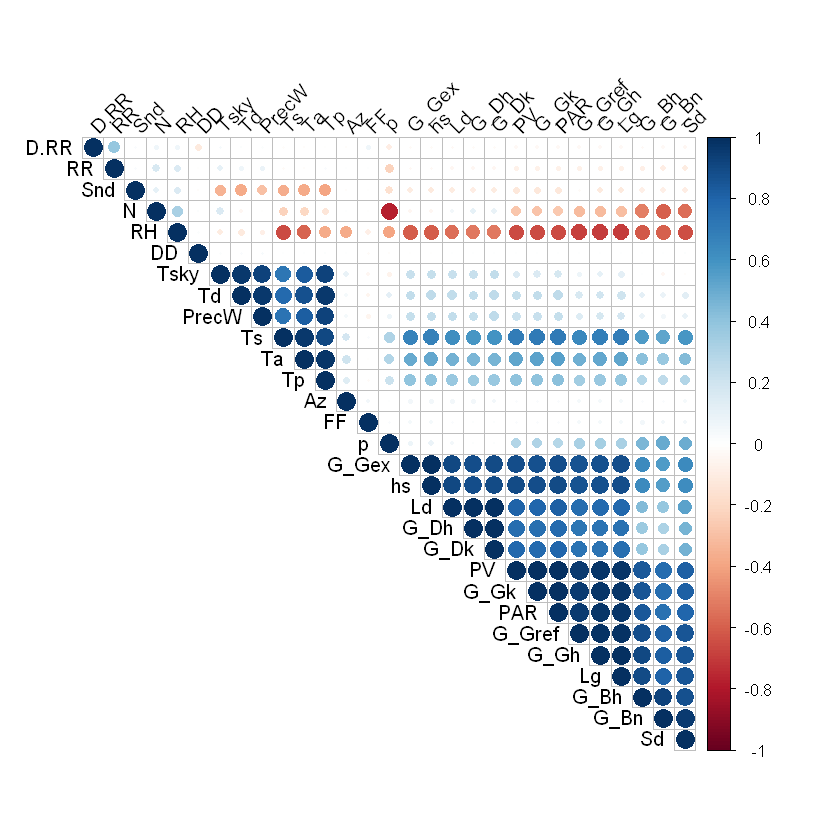

In [271]:
library(corrplot)

#Corr_Saar <- numeric_features %>% 

corrplot(cor(numeric_features), type = "upper", order = "hclust", 
         tl.col = "black", tl.srt = 45 # show only upper side
)

In [272]:
# Obtain summary stats for feature and label columns
Saar_hour %>% 
  # Select features and label
  select(c(m, dm, h, G_Gk, Lg, G_Gh, G_Gref, hs, G_Gex, G_Bh, Sd, Ld, G_Dk, G_Dh, G_Bn, Ts, Ta, PV)) %>% 
  # Summary stats
  descr(order = "preserve",
        stats = c('mean', 'sd', 'min', 'q1', 'med', 'q3', 'max'),
        round.digits = 6)

,m,dm,h,G_Gk,Lg,G_Gh,G_Gref,hs,G_Gex,G_Bh,Sd,Ld,G_Dk,G_Dh,G_Bn,Ts,Ta,PV
Mean,6.526027,15.720548,12.500000,105.6212,14227.71,130.1075,26.94132,13.33564,288.1753,66.54932,12.05171,7897.613,58.39977,63.55868,127.0110,9.588082,9.901918,85.34224
Std.Dev,3.448048,8.796749,6.922582,169.9389,22717.00,209.7949,43.03469,17.99469,372.8120,153.71793,19.46439,11735.800,87.77023,96.88775,251.9117,9.435693,7.698511,132.99255
Min,1.000000,1.000000,1.000000,0.0000,0.00,0.0000,0.00000,0.00000,0.0000,0.00000,0.00000,0.000,0.00000,0.00000,0.0000,-12.900000,-10.100000,0.00000
Q1,4.000000,8.000000,6.500000,0.0000,0.00,0.0000,0.00000,0.00000,0.0000,0.00000,0.00000,0.000,0.00000,0.00000,0.0000,2.300000,4.100000,0.00000
Median,7.000000,16.000000,12.500000,2.0000,166.00,2.0000,0.00000,0.10000,13.0000,0.00000,0.00000,165.500,2.00000,2.00000,0.0000,8.600000,9.700000,1.00000
Q3,10.000000,23.000000,18.500000,154.0000,21172.50,191.0000,40.00000,23.90000,553.0000,30.00000,17.00000,12242.000,89.50000,94.00000,84.0000,16.100000,15.700000,131.00000
Max,12.000000,31.000000,24.000000,833.0000,103055.00,970.0000,281.00000,64.20000,1190.0000,871.00000,60.00000,54648.000,409.00000,453.00000,992.0000,40.500000,32.100000,609.00000


`geom_smooth()` using formula 'y ~ x'



[[1]]


`geom_smooth()` using formula 'y ~ x'



[[1]]


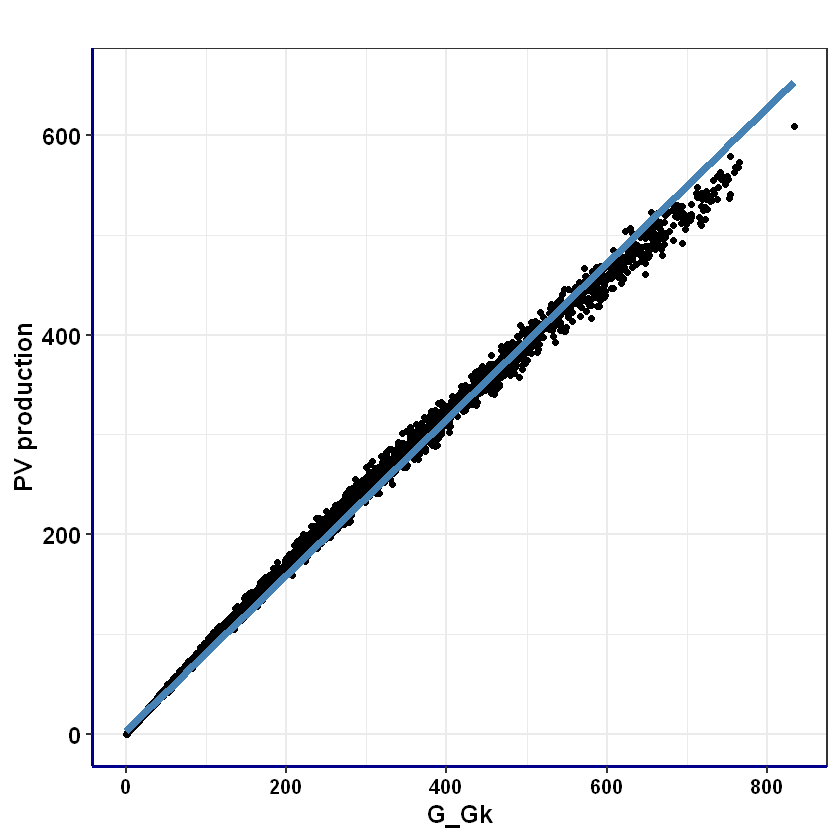

`geom_smooth()` using formula 'y ~ x'



[[1]]


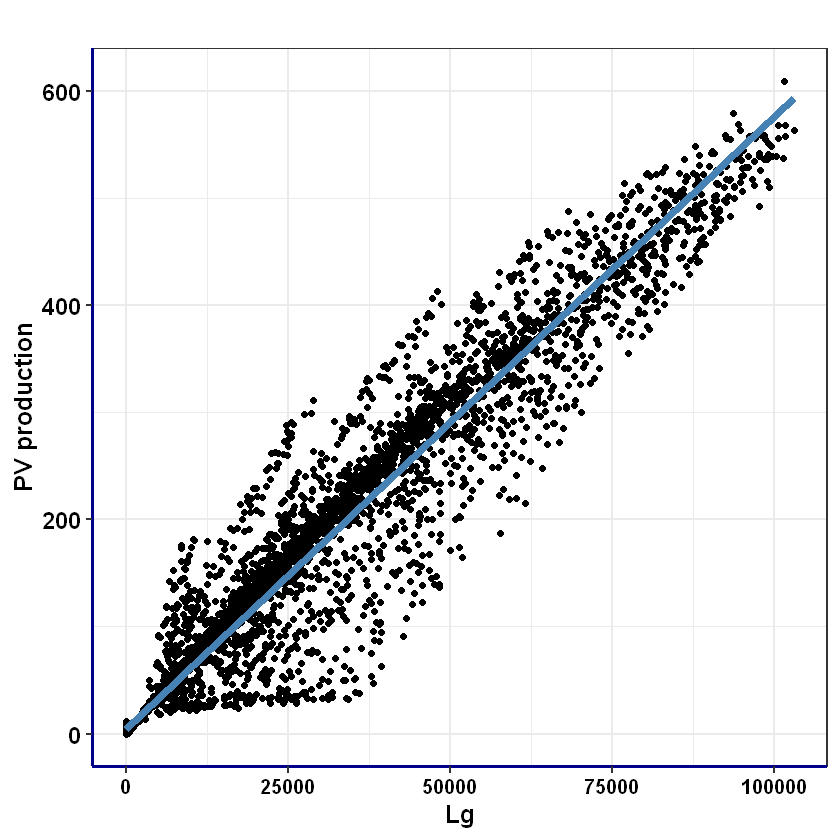

`geom_smooth()` using formula 'y ~ x'



[[1]]


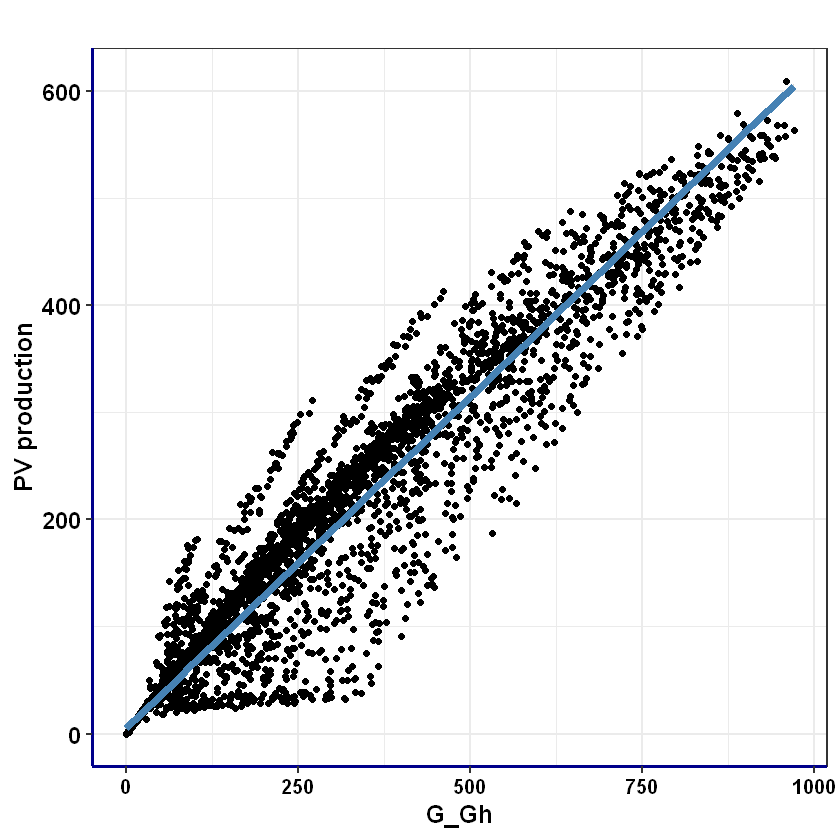

`geom_smooth()` using formula 'y ~ x'



[[1]]


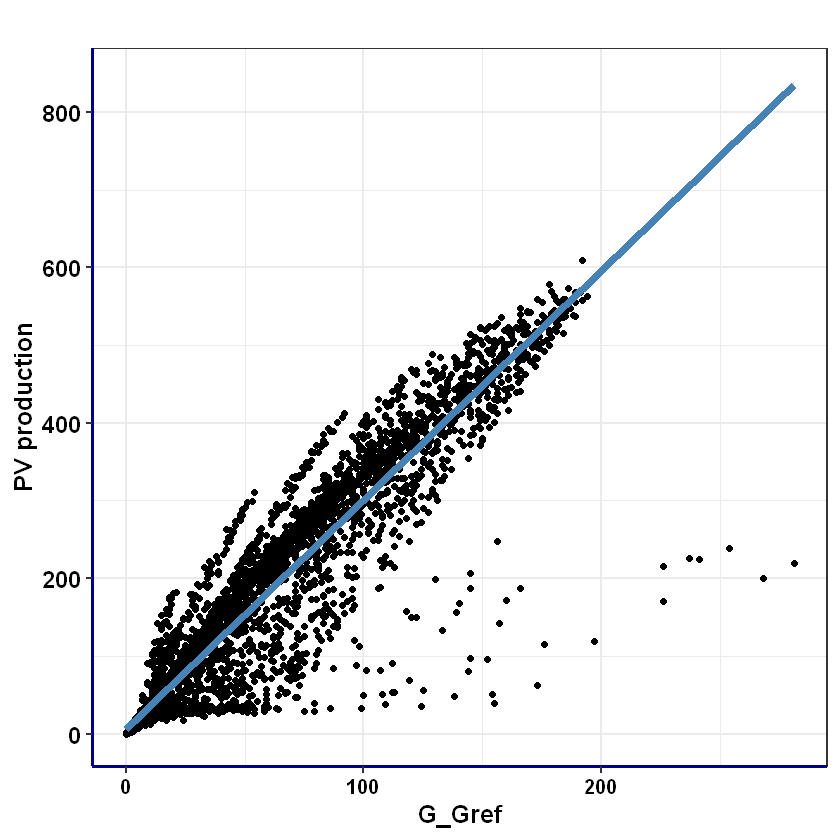

`geom_smooth()` using formula 'y ~ x'



[[1]]


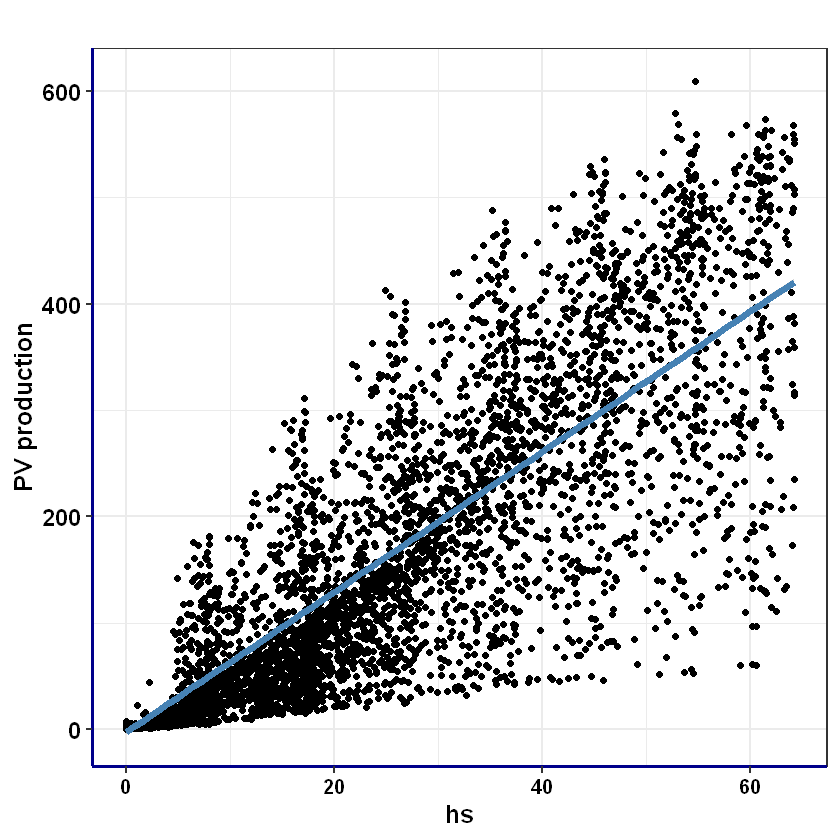

`geom_smooth()` using formula 'y ~ x'



[[1]]


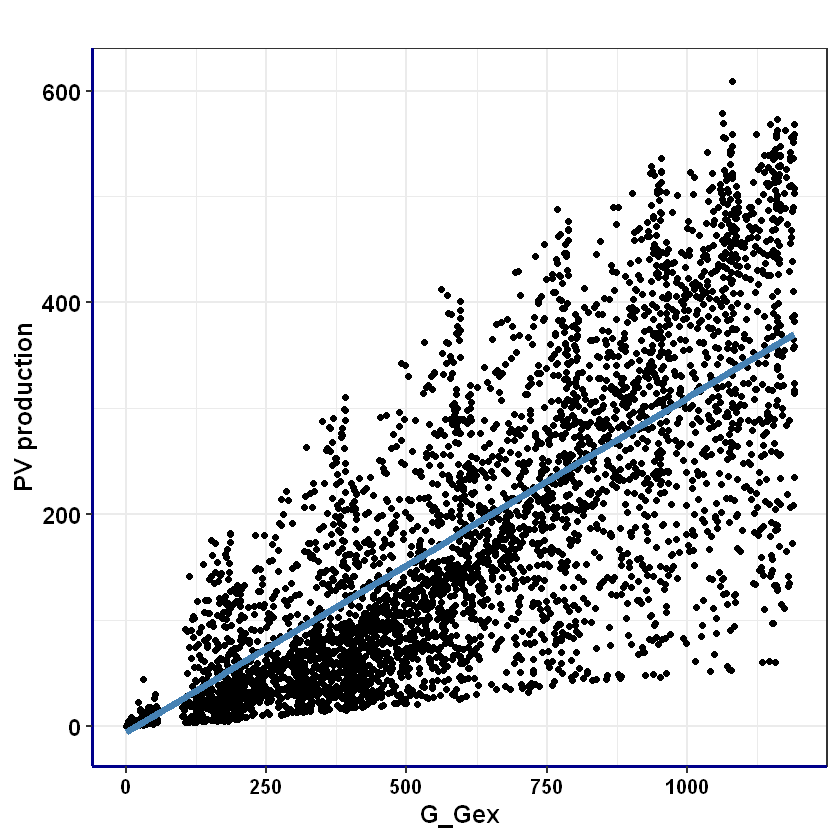

`geom_smooth()` using formula 'y ~ x'



[[1]]


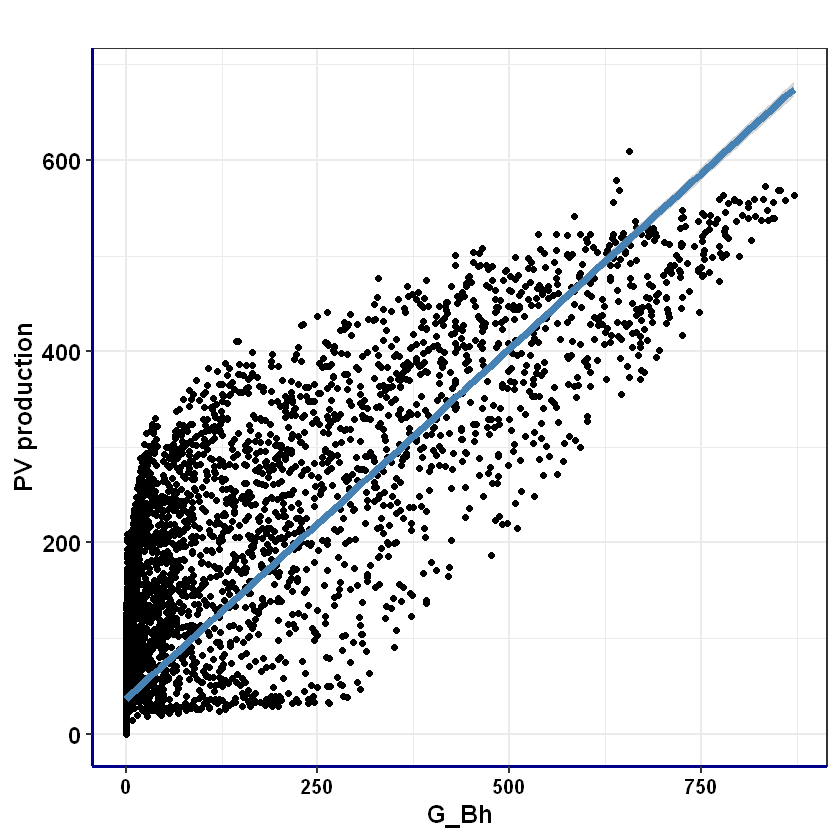

`geom_smooth()` using formula 'y ~ x'



[[1]]


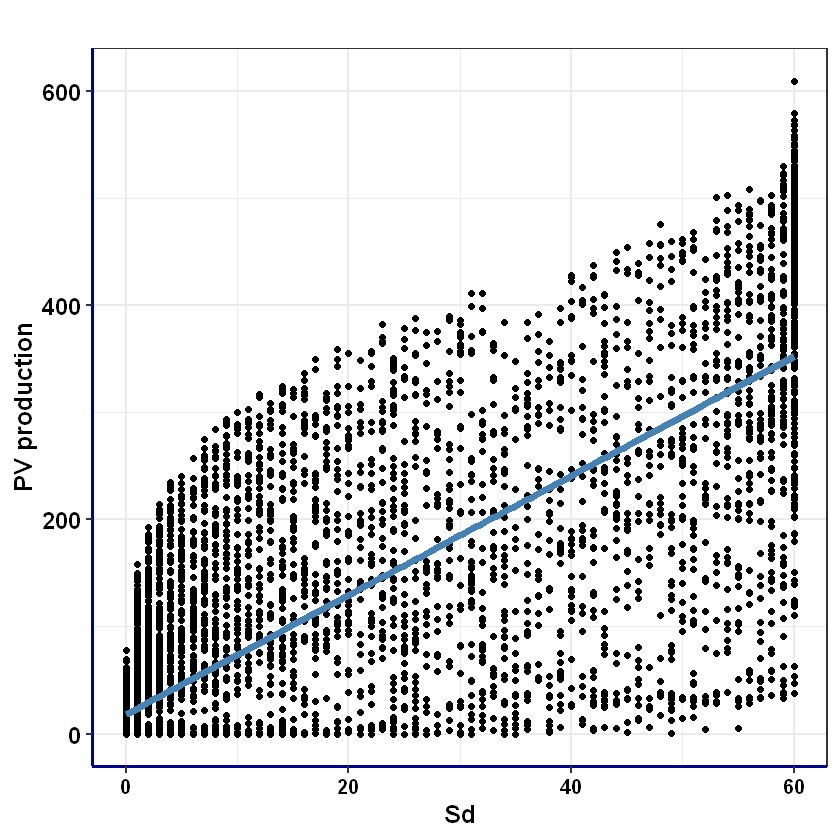

`geom_smooth()` using formula 'y ~ x'



[[1]]


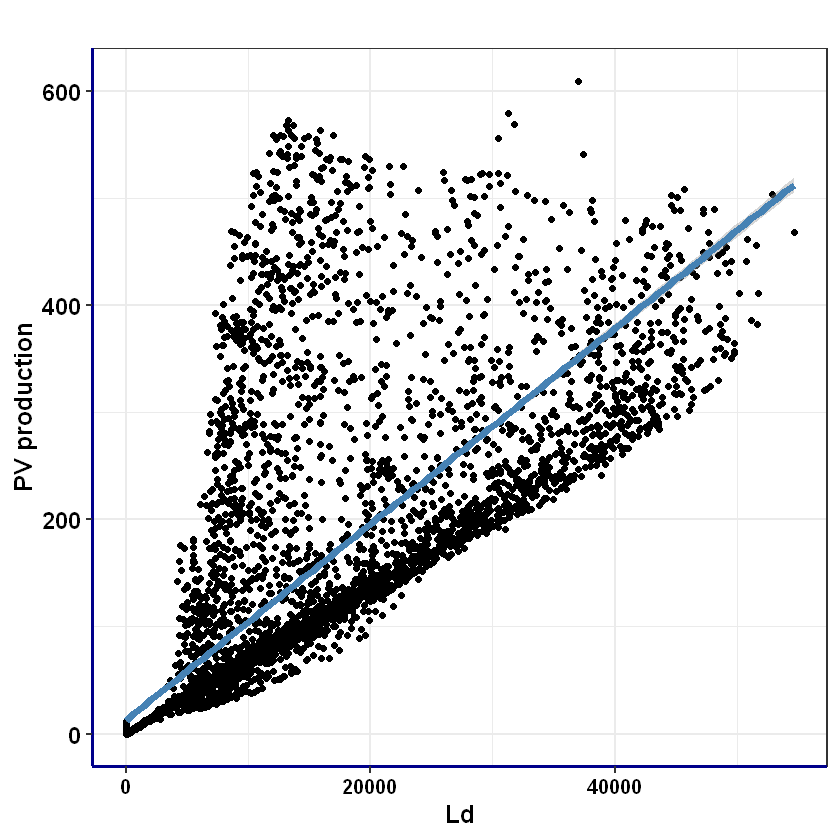

`geom_smooth()` using formula 'y ~ x'



[[1]]


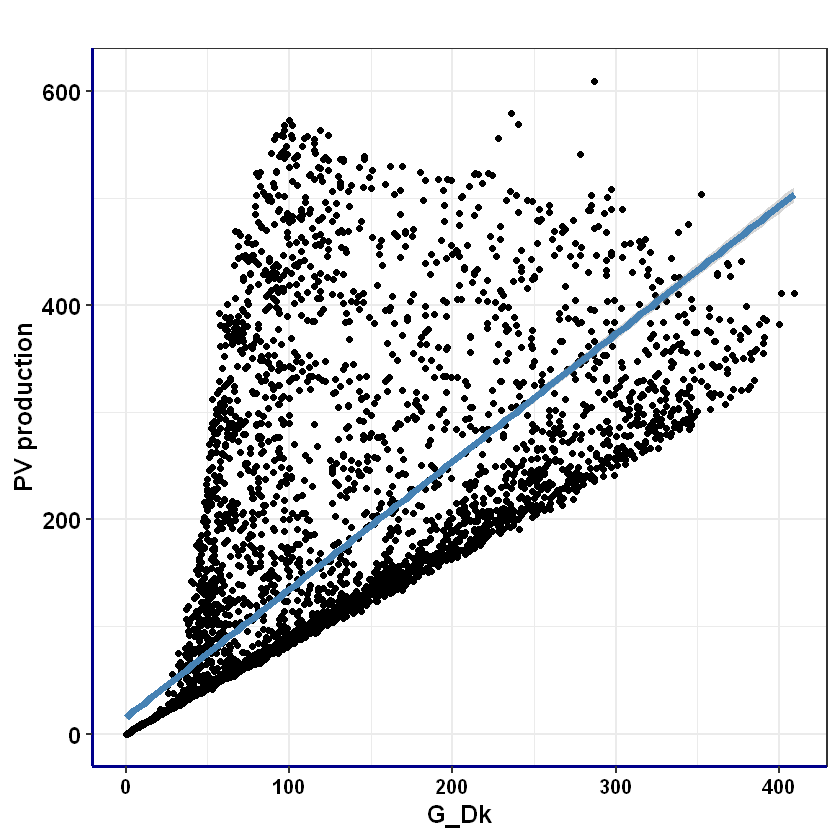

`geom_smooth()` using formula 'y ~ x'



[[1]]


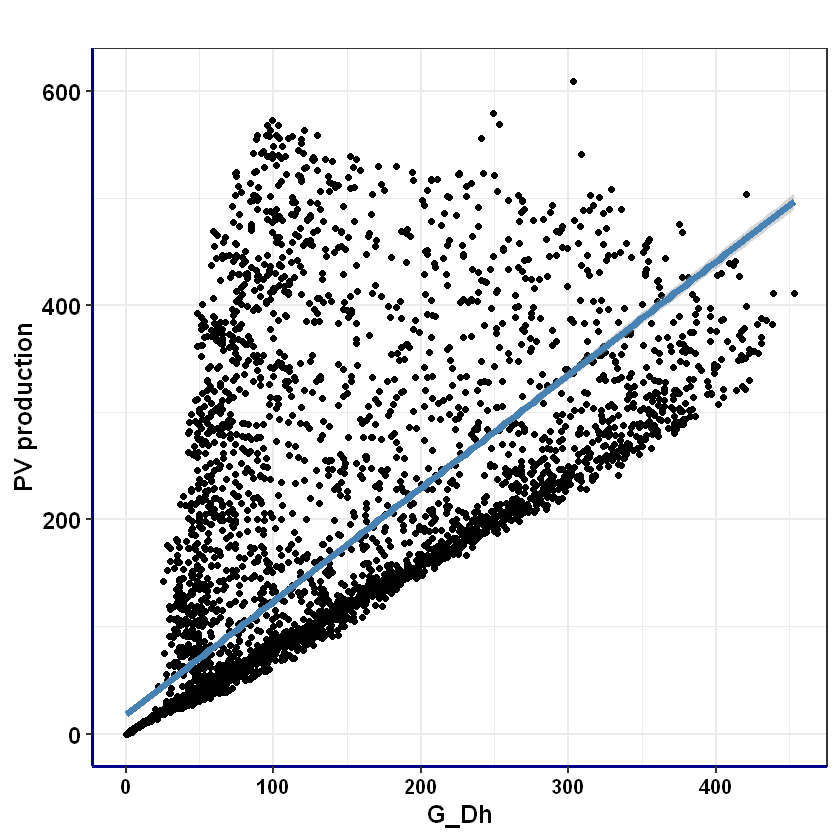

`geom_smooth()` using formula 'y ~ x'



[[1]]


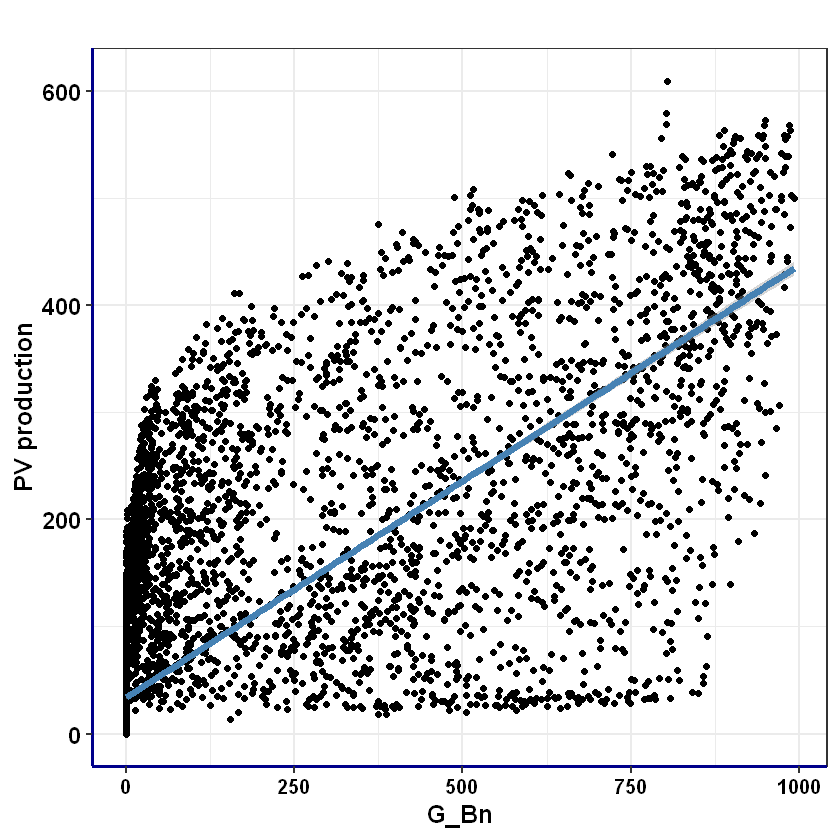

`geom_smooth()` using formula 'y ~ x'



[[1]]


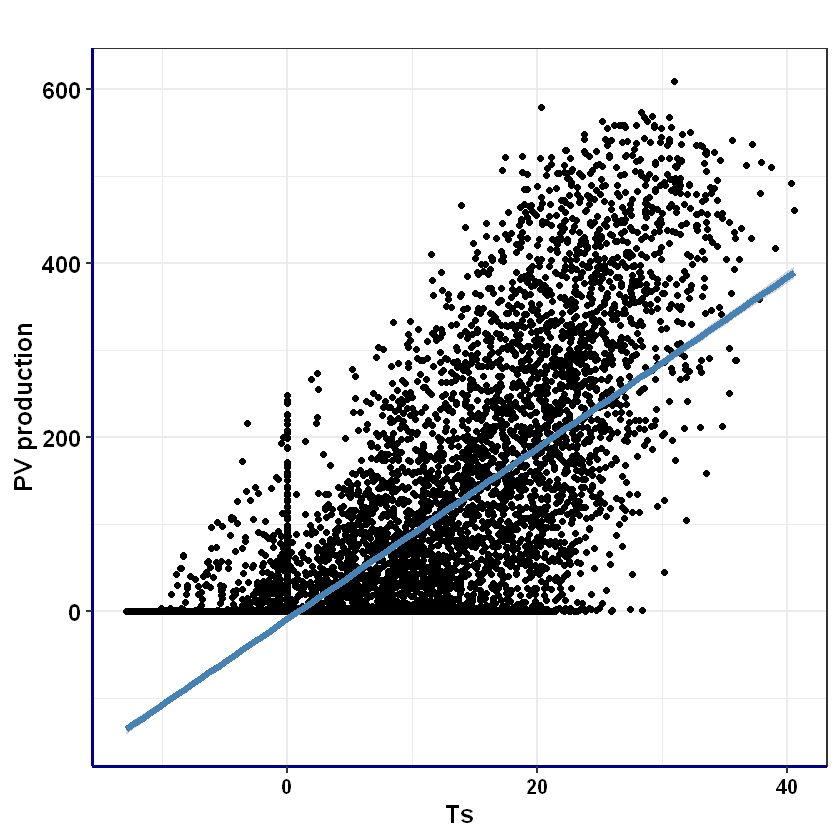

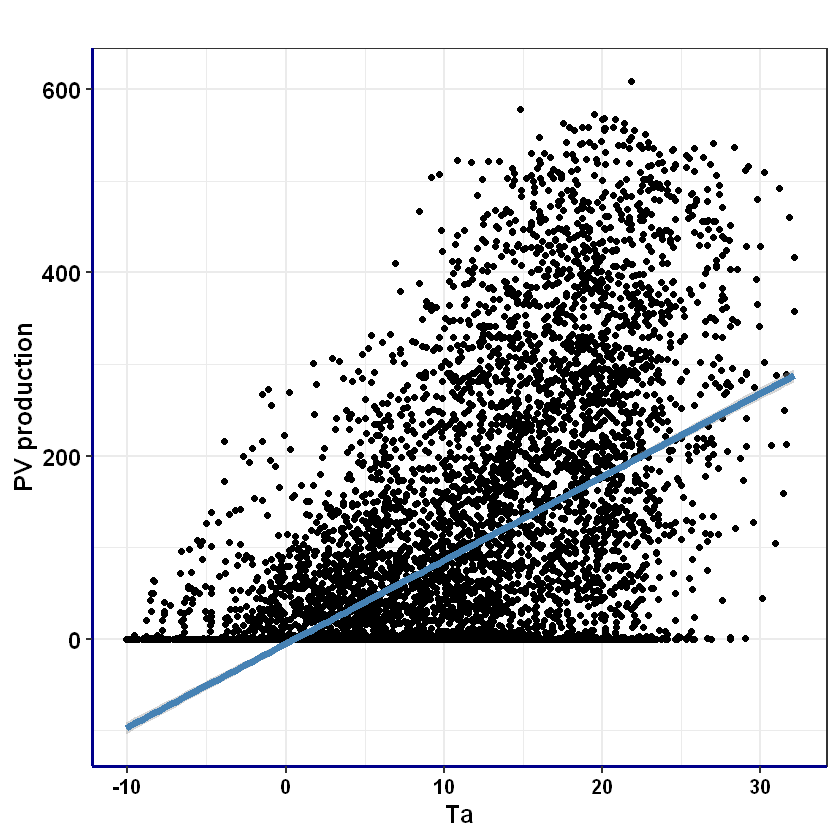

In [276]:
#G_Gk
G_Gk_r<-ggplot(Saar_hour, aes(G_Gk, PV))+

  geom_point()+
  geom_smooth(method = "lm", size = 2, linetype = 1, col="steelblue")+
    theme_bw(base_family = "", base_size = 15)+
    labs(x = "G_Gk")+
    labs(y = "PV production")+
    labs(title = "")+
    #scale_fill_discrete(labels=NULL, breaks = NULL)+
    theme(
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black"),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))
  
list(G_Gk_r)

#Lg
Lg_r<-ggplot(Saar_hour, aes(Lg, PV))+

  geom_point()+
  geom_smooth(method = "lm", size = 2, linetype = 1, col="steelblue")+
    theme_bw(base_family = "", base_size = 15)+
    labs(x = "Lg")+
    labs(y = "PV production")+
    labs(title = "")+
    #scale_fill_discrete(labels=NULL, breaks = NULL)+
    theme(
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black"),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))
  
list(Lg_r)

#G_Gh
G_Gh_r<-ggplot(Saar_hour, aes(G_Gh, PV))+

  geom_point()+
  geom_smooth(method = "lm", size = 2, linetype = 1, col="steelblue")+
    theme_bw(base_family = "", base_size = 15)+
    labs(x = "G_Gh")+
    labs(y = "PV production")+
    labs(title = "")+
    #scale_fill_discrete(labels=NULL, breaks = NULL)+
    theme(
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black"),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))
  
list(G_Gh_r)

#G_Gref
G_Gref_r<-ggplot(Saar_hour, aes(G_Gref, PV))+

  geom_point()+
  geom_smooth(method = "lm", size = 2, linetype = 1, col="steelblue")+
    theme_bw(base_family = "", base_size = 15)+
    labs(x = "G_Gref")+
    labs(y = "PV production")+
    labs(title = "")+
    #scale_fill_discrete(labels=NULL, breaks = NULL)+
    theme(
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black"),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))
  
list(G_Gref_r)

#hs
hs_r<-ggplot(Saar_hour, aes(hs, PV))+

  geom_point()+
  geom_smooth(method = "lm", size = 2, linetype = 1, col="steelblue")+
    theme_bw(base_family = "", base_size = 15)+
    labs(x = "hs")+
    labs(y = "PV production")+
    labs(title = "")+
    #scale_fill_discrete(labels=NULL, breaks = NULL)+
    theme(
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black"),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))
  
list(hs_r)

#G_Gex
G_Gex_r<-ggplot(Saar_hour, aes(G_Gex, PV))+

  geom_point()+
  geom_smooth(method = "lm", size = 2, linetype = 1, col="steelblue")+
    theme_bw(base_family = "", base_size = 15)+
    labs(x = "G_Gex")+
    labs(y = "PV production")+
    labs(title = "")+
    #scale_fill_discrete(labels=NULL, breaks = NULL)+
    theme(
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black"),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))
  
list(G_Gex_r)

#G_Bh

G_Bh_r<-ggplot(Saar_hour, aes(G_Bh, PV))+

  geom_point()+
  geom_smooth(method = "lm", size = 2, linetype = 1, col="steelblue")+
    theme_bw(base_family = "", base_size = 15)+
    labs(x = "G_Bh")+
    labs(y = "PV production")+
    labs(title = "")+
    #scale_fill_discrete(labels=NULL, breaks = NULL)+
    theme(
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black"),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))
  
list(G_Bh_r)

#Sd
Sd_r<-ggplot(Saar_hour, aes(Sd, PV))+

  geom_point()+
  geom_smooth(method = "lm", size = 2, linetype = 1, col="steelblue")+
    theme_bw(base_family = "", base_size = 15)+
    labs(x = "Sd")+
    labs(y = "PV production")+
    labs(title = "")+
    #scale_fill_discrete(labels=NULL, breaks = NULL)+
    theme(
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black"),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))
  
list(Sd_r)

#Ld
Ld_r<-ggplot(Saar_hour, aes(Ld, PV))+

  geom_point()+
  geom_smooth(method = "lm", size = 2, linetype = 1, col="steelblue")+
    theme_bw(base_family = "", base_size = 15)+
    labs(x = "Ld")+
    labs(y = "PV production")+
    labs(title = "")+
    #scale_fill_discrete(labels=NULL, breaks = NULL)+
    theme(
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black"),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))
  
list(Ld_r)

#G_Dk
G_Dk_r<-ggplot(Saar_hour, aes(G_Dk, PV))+

  geom_point()+
  geom_smooth(method = "lm", size = 2, linetype = 1, col="steelblue")+
    theme_bw(base_family = "", base_size = 15)+
    labs(x = "G_Dk")+
    labs(y = "PV production")+
    labs(title = "")+
    #scale_fill_discrete(labels=NULL, breaks = NULL)+
    theme(
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black"),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))
  
list(G_Dk_r)

#G_Dh
G_Dh_r<-ggplot(Saar_hour, aes(G_Dh, PV))+

  geom_point()+
  geom_smooth(method = "lm", size = 2, linetype = 1, col="steelblue")+
    theme_bw(base_family = "", base_size = 15)+
    labs(x = "G_Dh")+
    labs(y = "PV production")+
    labs(title = "")+
    #scale_fill_discrete(labels=NULL, breaks = NULL)+
    theme(
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black"),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))
  
list(G_Dh_r)

#G_Bn
G_Bn_r<-ggplot(Saar_hour, aes(G_Bn, PV))+

  geom_point()+
  geom_smooth(method = "lm", size = 2, linetype = 1, col="steelblue")+
    theme_bw(base_family = "", base_size = 15)+
    labs(x = "G_Bn")+
    labs(y = "PV production")+
    labs(title = "")+
    #scale_fill_discrete(labels=NULL, breaks = NULL)+
    theme(
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black"),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))
  
list(G_Bn_r)

#Ts
Ts_r<-ggplot(Saar_hour, aes(Ts, PV))+

  geom_point()+
  geom_smooth(method = "lm", size = 2, linetype = 1, col="steelblue")+
    theme_bw(base_family = "", base_size = 15)+
    labs(x = "Ts")+
    labs(y = "PV production")+
    labs(title = "")+
    #scale_fill_discrete(labels=NULL, breaks = NULL)+
    theme(
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black"),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))
 list(Ts_r)

#Ta
Ta_r<-ggplot(Saar_hour, aes(Ta, PV))+

  geom_point()+
  geom_smooth(method = "lm", size = 2, linetype = 1, col="steelblue")+
    theme_bw(base_family = "", base_size = 15)+
    labs(x = "Ta")+
    labs(y = "PV production")+
    labs(title = "")+
    #scale_fill_discrete(labels=NULL, breaks = NULL)+
    theme(
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black"),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))
 list(Ta_r)

In [169]:
anyNA(Saar_hour)
#colSums(is.na(Saar_hour))
#rowSums(is.na(Saar_hour))

[1] FALSE

Minimum:  0 
Mean:  85.34 
Median:  1 
Mode:  0 
Maximum:  609

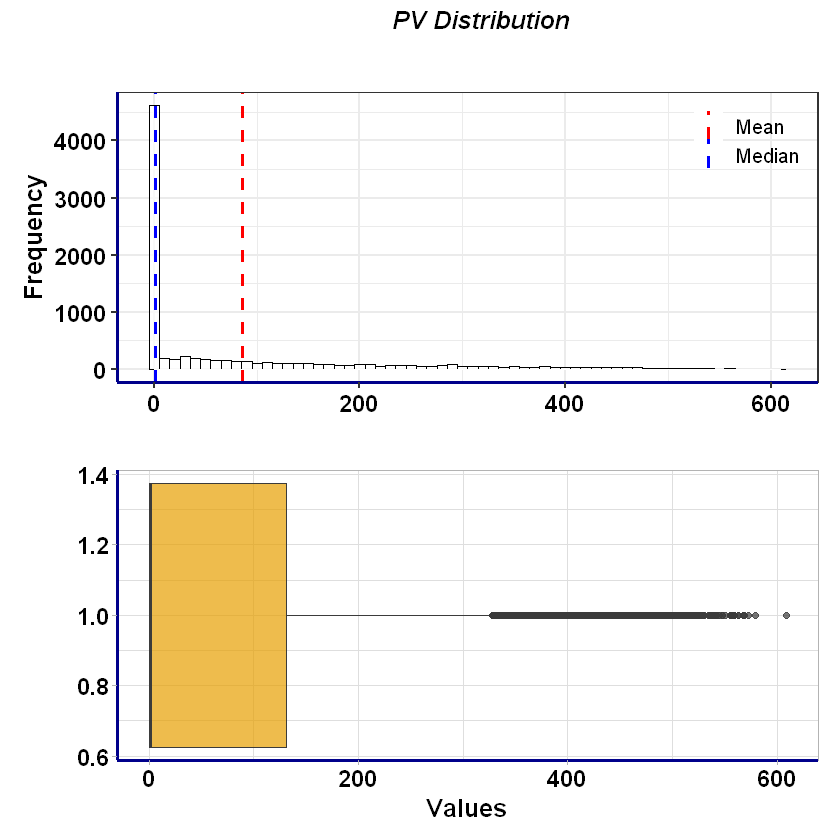

In [277]:
#PV 

theme_set(theme_light())

# Plot a histogram
hist_plt <- Saar_hour %>% 
  ggplot(mapping = aes(x = PV)) + 
  geom_histogram(bins = 100, binwidth = 10, colour ="black",fill="white", alpha = 0.7) +
  geom_density(aes(PV), alpha = 0.2, fill="orangered", color="white")+
    theme_bw(base_family = "", base_size = 15)+
  # Add lines for mean and median
  geom_vline(aes(xintercept = mean(PV), color = 'Mean'), linetype = "dashed", size = 1) +
  geom_vline(aes(xintercept = median(PV), color = 'Median'), linetype = "dashed", size = 1 ) +
  xlab("") +
  ylab("Frequency") +
  labs(title ="")+
  scale_color_manual(name = "", values = c(Mean = "red", Median = "blue")) +
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))

# Plot a box plot
box_plt <- Saar_hour %>% 
  ggplot(aes(x = PV, y = 1)) +
  geom_boxplot(fill = "#E69F00", color = "gray23", alpha = 0.7) +
    # Add titles and labels
  xlab("Values")+
  ylab("")+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))


# Combine plots
(hist_plt / box_plt) +
  plot_annotation(title = 'PV Distribution',
                  theme = theme(plot.title = element_text(hjust = 0.6, size=15, face="bold.italic")))


# Get summary statistics
min_val <- min(Saar_hour$PV)
max_val <- max(Saar_hour$PV)
mean_val <- mean(Saar_hour$PV)
med_val <- median(Saar_hour$PV)
mod_val <- mfv(Saar_hour$PV)

# Print the stats
cat(
  "Minimum: ", round(min_val, 2),
   "\nMean: ", round(mean_val, 2),
   "\nMedian: ", round(med_val, 2),
   "\nMode: ", round(mod_val, 2),
   "\nMaximum: ", round(max_val, 2)
)


Minimum:  0 
Mean:  105.62 
Median:  2 
Mode:  0 
Maximum:  833

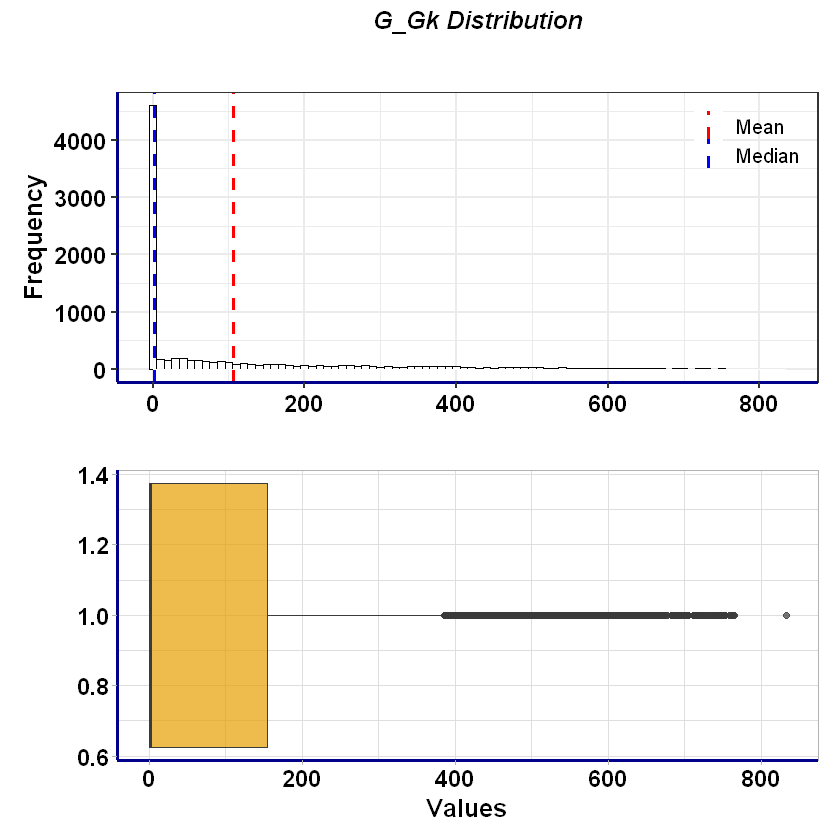

In [410]:
#G_Gk

theme_set(theme_light())

# Plot a histogram
hist_plt <- Saar_hour %>% 
  ggplot(mapping = aes(x = G_Gk)) + 
  geom_histogram(bins = 100, binwidth = 10, colour ="black",fill="white", alpha = 0.7) +
  geom_density(aes(G_Gk), alpha = 0.2, fill="orangered", color="white")+
    theme_bw(base_family = "", base_size = 15)+
  # Add lines for mean and median
  geom_vline(aes(xintercept = mean(G_Gk), color = 'Mean'), linetype = "dashed", size = 1) +
  geom_vline(aes(xintercept = median(G_Gk), color = 'Median'), linetype = "dashed", size = 1 ) +
  xlab("") +
  ylab("Frequency") +
  labs(title ="")+
  scale_color_manual(name = "", values = c(Mean = "red", Median = "blue")) +
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))

# Plot a box plot
box_plt <- Saar_hour %>% 
  ggplot(aes(x = G_Gk, y = 1)) +
  geom_boxplot(fill = "#E69F00", color = "gray23", alpha = 0.7) +
    # Add titles and labels
  xlab("Values")+
  ylab("")+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))


# Combine plots
(hist_plt / box_plt) +
  plot_annotation(title = 'G_Gk Distribution',
                  theme = theme(plot.title = element_text(hjust = 0.6, size=15, face="bold.italic")))


# Get summary statistics
min_val <- min(Saar_hour$G_Gk)
max_val <- max(Saar_hour$G_Gk)
mean_val <- mean(Saar_hour$G_Gk)
med_val <- median(Saar_hour$G_Gk)
mod_val <- mfv(Saar_hour$G_Gk)

# Print the stats
cat(
  "Minimum: ", round(min_val, 2),
   "\nMean: ", round(mean_val, 2),
   "\nMedian: ", round(med_val, 2),
   "\nMode: ", round(mod_val, 2),
   "\nMaximum: ", round(max_val, 2)
)


Minimum:  0 
Mean:  14227.71 
Median:  166 
Mode:  0 
Maximum:  103055

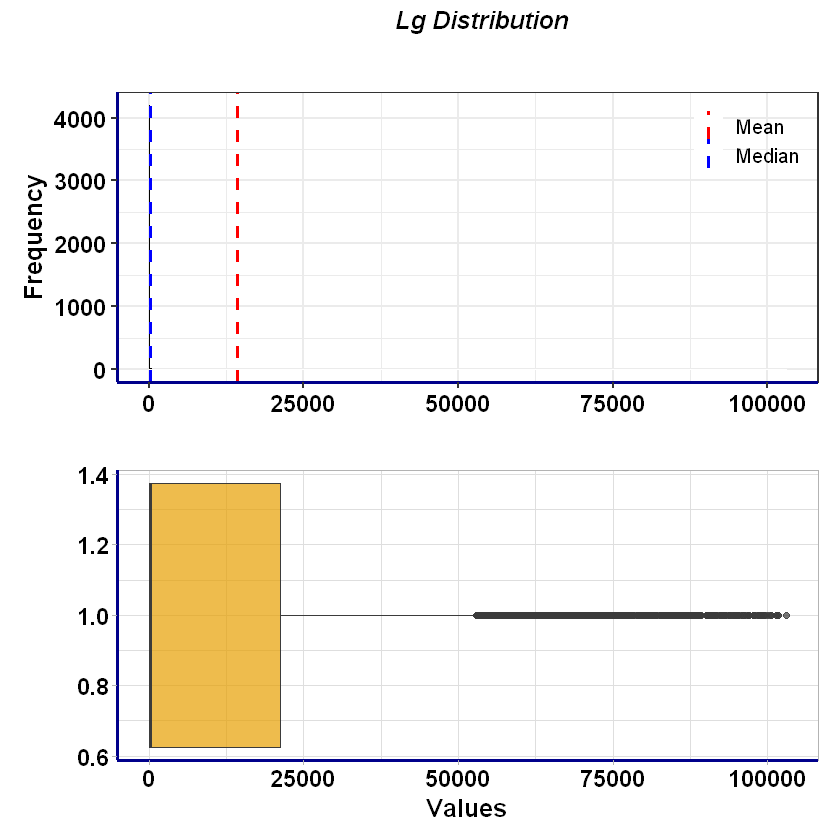

In [411]:
#Lg

theme_set(theme_light())

# Plot a histogram
hist_plt <- Saar_hour %>% 
  ggplot(mapping = aes(x = Lg)) + 
  geom_histogram(bins = 100, binwidth = 10, colour ="black",fill="white", alpha = 0.7) +
  geom_density(aes(Lg), alpha = 0.2, fill="orangered", color="white")+
    theme_bw(base_family = "", base_size = 15)+
  # Add lines for mean and median
  geom_vline(aes(xintercept = mean(Lg), color = 'Mean'), linetype = "dashed", size = 1) +
  geom_vline(aes(xintercept = median(Lg), color = 'Median'), linetype = "dashed", size = 1 ) +
  xlab("") +
  ylab("Frequency") +
  labs(title ="")+
  scale_color_manual(name = "", values = c(Mean = "red", Median = "blue")) +
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))

# Plot a box plot
box_plt <- Saar_hour %>% 
  ggplot(aes(x = Lg, y = 1)) +
  geom_boxplot(fill = "#E69F00", color = "gray23", alpha = 0.7) +
    # Add titles and labels
  xlab("Values")+
  ylab("")+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))


# Combine plots
(hist_plt / box_plt) +
  plot_annotation(title = 'Lg Distribution',
                  theme = theme(plot.title = element_text(hjust = 0.6, size=15, face="bold.italic")))


# Get summary statistics
min_val <- min(Saar_hour$Lg)
max_val <- max(Saar_hour$Lg)
mean_val <- mean(Saar_hour$Lg)
med_val <- median(Saar_hour$Lg)
mod_val <- mfv(Saar_hour$Lg)

# Print the stats
cat(
  "Minimum: ", round(min_val, 2),
   "\nMean: ", round(mean_val, 2),
   "\nMedian: ", round(med_val, 2),
   "\nMode: ", round(mod_val, 2),
   "\nMaximum: ", round(max_val, 2)
)


Minimum:  0 
Mean:  130.11 
Median:  2 
Mode:  0 
Maximum:  970

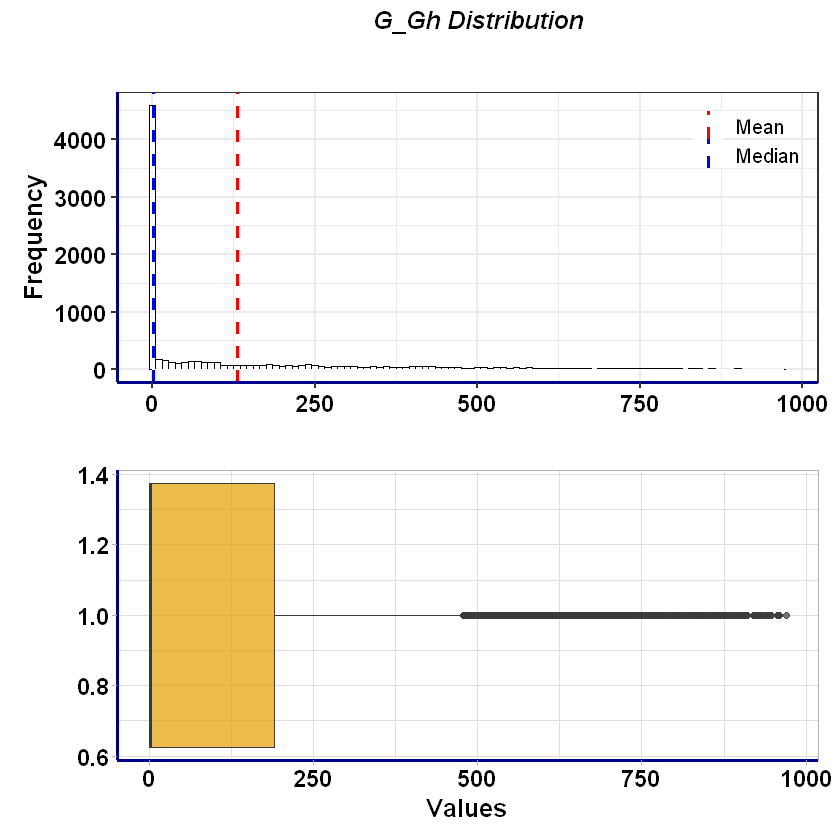

In [412]:
#G_Gh

theme_set(theme_light())

# Plot a histogram
hist_plt <- Saar_hour %>% 
  ggplot(mapping = aes(x = G_Gh)) + 
  geom_histogram(bins = 100, binwidth = 10, colour ="black",fill="white", alpha = 0.7) +
  geom_density(aes(G_Gh), alpha = 0.2, fill="orangered", color="white")+
    theme_bw(base_family = "", base_size = 15)+
  # Add lines for mean and median
  geom_vline(aes(xintercept = mean(G_Gh), color = 'Mean'), linetype = "dashed", size = 1) +
  geom_vline(aes(xintercept = median(G_Gh), color = 'Median'), linetype = "dashed", size = 1 ) +
  xlab("") +
  ylab("Frequency") +
  labs(title ="")+
  scale_color_manual(name = "", values = c(Mean = "red", Median = "blue")) +
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))

# Plot a box plot
box_plt <- Saar_hour %>% 
  ggplot(aes(x = G_Gh, y = 1)) +
  geom_boxplot(fill = "#E69F00", color = "gray23", alpha = 0.7) +
    # Add titles and labels
  xlab("Values")+
  ylab("")+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))


# Combine plots
(hist_plt / box_plt) +
  plot_annotation(title = 'G_Gh Distribution',
                  theme = theme(plot.title = element_text(hjust = 0.6, size=15, face="bold.italic")))


# Get summary statistics
min_val <- min(Saar_hour$G_Gh)
max_val <- max(Saar_hour$G_Gh)
mean_val <- mean(Saar_hour$G_Gh)
med_val <- median(Saar_hour$G_Gh)
mod_val <- mfv(Saar_hour$G_Gh)

# Print the stats
cat(
  "Minimum: ", round(min_val, 2),
   "\nMean: ", round(mean_val, 2),
   "\nMedian: ", round(med_val, 2),
   "\nMode: ", round(mod_val, 2),
   "\nMaximum: ", round(max_val, 2)
)


Minimum:  0 
Mean:  26.94 
Median:  0 
Mode:  0 
Maximum:  281

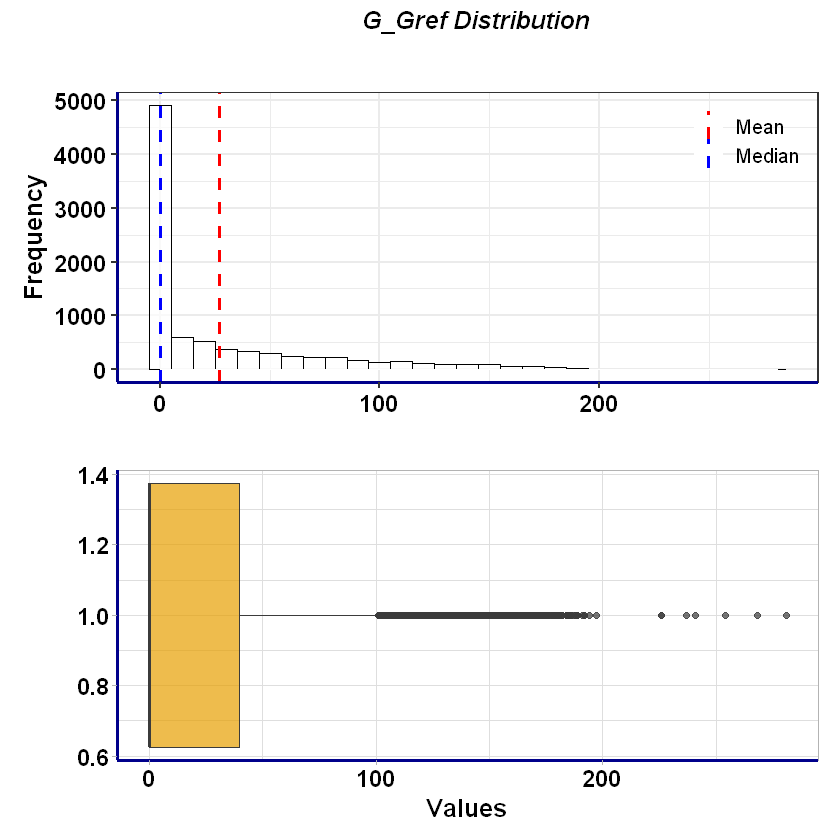

In [413]:
#G_Gref

theme_set(theme_light())

# Plot a histogram
hist_plt <- Saar_hour %>% 
  ggplot(mapping = aes(x = G_Gref)) + 
  geom_histogram(bins = 100, binwidth = 10, colour ="black",fill="white", alpha = 0.7) +
  geom_density(aes(G_Gref), alpha = 0.2, fill="orangered", color="white")+
    theme_bw(base_family = "", base_size = 15)+
  # Add lines for mean and median
  geom_vline(aes(xintercept = mean(G_Gref), color = 'Mean'), linetype = "dashed", size = 1) +
  geom_vline(aes(xintercept = median(G_Gref), color = 'Median'), linetype = "dashed", size = 1 ) +
  xlab("") +
  ylab("Frequency") +
  labs(title ="")+
  scale_color_manual(name = "", values = c(Mean = "red", Median = "blue")) +
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))

# Plot a box plot
box_plt <- Saar_hour %>% 
  ggplot(aes(x = G_Gref, y = 1)) +
  geom_boxplot(fill = "#E69F00", color = "gray23", alpha = 0.7) +
    # Add titles and labels
  xlab("Values")+
  ylab("")+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))


# Combine plots
(hist_plt / box_plt) +
  plot_annotation(title = 'G_Gref Distribution',
                  theme = theme(plot.title = element_text(hjust = 0.6, size=15, face="bold.italic")))


# Get summary statistics
min_val <- min(Saar_hour$G_Gref)
max_val <- max(Saar_hour$G_Gref)
mean_val <- mean(Saar_hour$G_Gref)
med_val <- median(Saar_hour$G_Gref)
mod_val <- mfv(Saar_hour$G_Gref)

# Print the stats
cat(
  "Minimum: ", round(min_val, 2),
   "\nMean: ", round(mean_val, 2),
   "\nMedian: ", round(med_val, 2),
   "\nMode: ", round(mod_val, 2),
   "\nMaximum: ", round(max_val, 2)
)


Minimum:  0 
Mean:  13.34 
Median:  0.1 
Mode:  0 
Maximum:  64.2

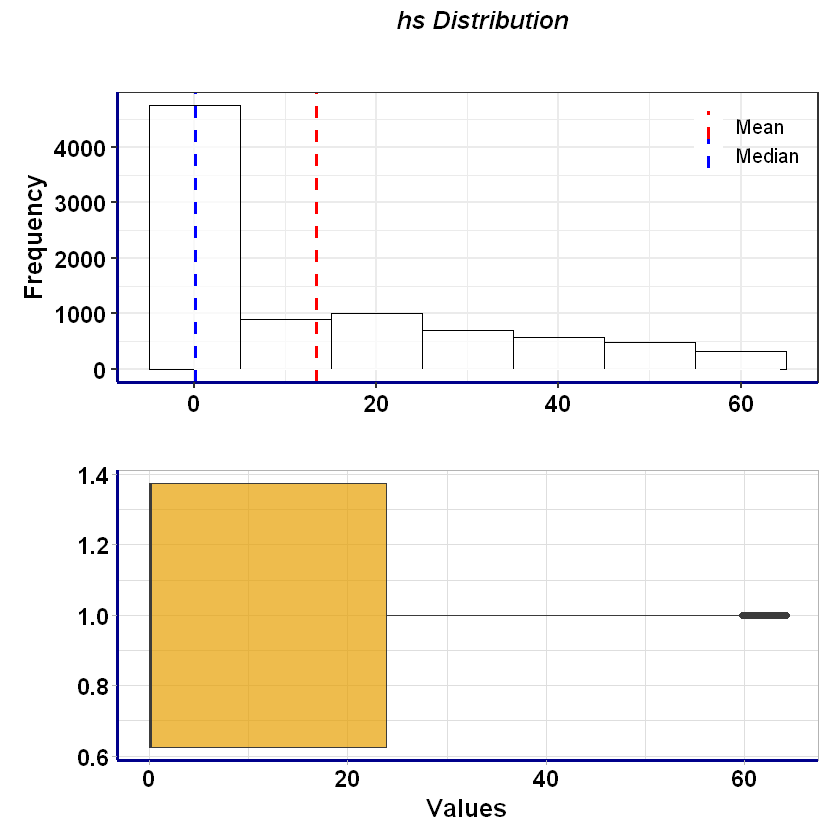

In [414]:
#hs

theme_set(theme_light())

# Plot a histogram
hist_plt <- Saar_hour %>% 
  ggplot(mapping = aes(x = hs)) + 
  geom_histogram(bins = 100, binwidth = 10, colour ="black",fill="white", alpha = 0.7) +
  geom_density(aes(hs), alpha = 0.2, fill="orangered", color="white")+
    theme_bw(base_family = "", base_size = 15)+
  # Add lines for mean and median
  geom_vline(aes(xintercept = mean(hs), color = 'Mean'), linetype = "dashed", size = 1) +
  geom_vline(aes(xintercept = median(hs), color = 'Median'), linetype = "dashed", size = 1 ) +
  xlab("") +
  ylab("Frequency") +
  labs(title ="")+
  scale_color_manual(name = "", values = c(Mean = "red", Median = "blue")) +
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))

# Plot a box plot
box_plt <- Saar_hour %>% 
  ggplot(aes(x = hs, y = 1)) +
  geom_boxplot(fill = "#E69F00", color = "gray23", alpha = 0.7) +
    # Add titles and labels
  xlab("Values")+
  ylab("")+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))


# Combine plots
(hist_plt / box_plt) +
  plot_annotation(title = 'hs Distribution',
                  theme = theme(plot.title = element_text(hjust = 0.6, size=15, face="bold.italic")))


# Get summary statistics
min_val <- min(Saar_hour$hs)
max_val <- max(Saar_hour$hs)
mean_val <- mean(Saar_hour$hs)
med_val <- median(Saar_hour$hs)
mod_val <- mfv(Saar_hour$hs)

# Print the stats
cat(
  "Minimum: ", round(min_val, 2),
   "\nMean: ", round(mean_val, 2),
   "\nMedian: ", round(med_val, 2),
   "\nMode: ", round(mod_val, 2),
   "\nMaximum: ", round(max_val, 2)
)


Minimum:  0 
Mean:  288.18 
Median:  13 
Mode:  0 
Maximum:  1190

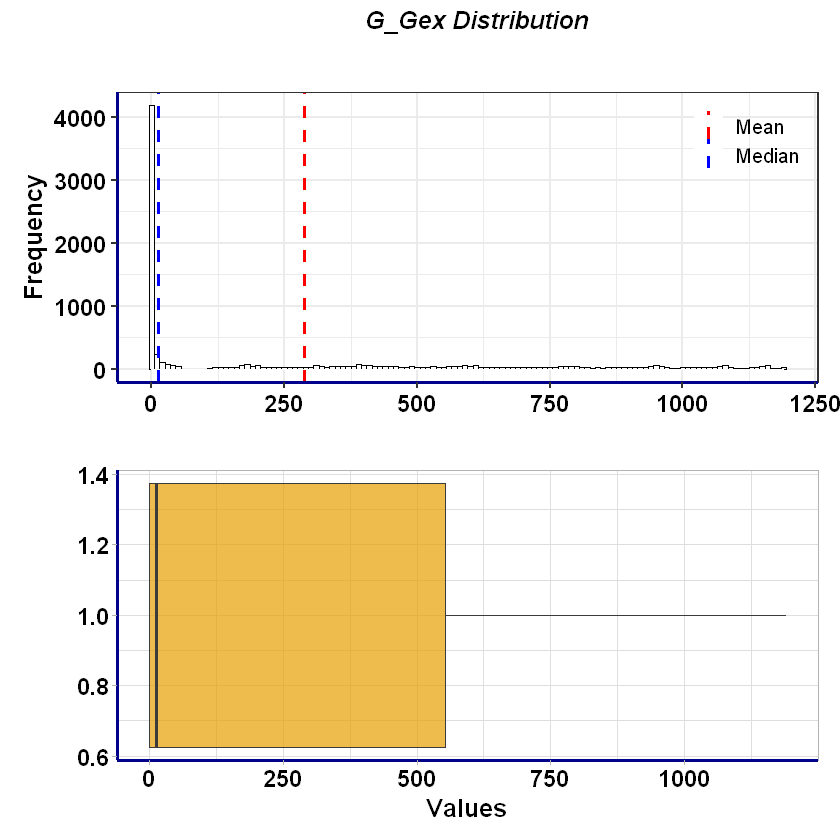

In [415]:
#G_Gex

theme_set(theme_light())

# Plot a histogram
hist_plt <- Saar_hour %>% 
  ggplot(mapping = aes(x = G_Gex)) + 
  geom_histogram(bins = 100, binwidth = 10, colour ="black",fill="white", alpha = 0.7) +
  geom_density(aes(G_Gex), alpha = 0.2, fill="orangered", color="white")+
    theme_bw(base_family = "", base_size = 15)+
  # Add lines for mean and median
  geom_vline(aes(xintercept = mean(G_Gex), color = 'Mean'), linetype = "dashed", size = 1) +
  geom_vline(aes(xintercept = median(G_Gex), color = 'Median'), linetype = "dashed", size = 1 ) +
  xlab("") +
  ylab("Frequency") +
  labs(title ="")+
  scale_color_manual(name = "", values = c(Mean = "red", Median = "blue")) +
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))

# Plot a box plot
box_plt <- Saar_hour %>% 
  ggplot(aes(x = G_Gex, y = 1)) +
  geom_boxplot(fill = "#E69F00", color = "gray23", alpha = 0.7) +
    # Add titles and labels
  xlab("Values")+
  ylab("")+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))


# Combine plots
(hist_plt / box_plt) +
  plot_annotation(title = 'G_Gex Distribution',
                  theme = theme(plot.title = element_text(hjust = 0.6, size=15, face="bold.italic")))


# Get summary statistics
min_val <- min(Saar_hour$G_Gex)
max_val <- max(Saar_hour$G_Gex)
mean_val <- mean(Saar_hour$G_Gex)
med_val <- median(Saar_hour$G_Gex)
mod_val <- mfv(Saar_hour$G_Gex)

# Print the stats
cat(
  "Minimum: ", round(min_val, 2),
   "\nMean: ", round(mean_val, 2),
   "\nMedian: ", round(med_val, 2),
   "\nMode: ", round(mod_val, 2),
   "\nMaximum: ", round(max_val, 2)
)


Minimum:  0 
Mean:  66.55 
Median:  0 
Mode:  0 
Maximum:  871

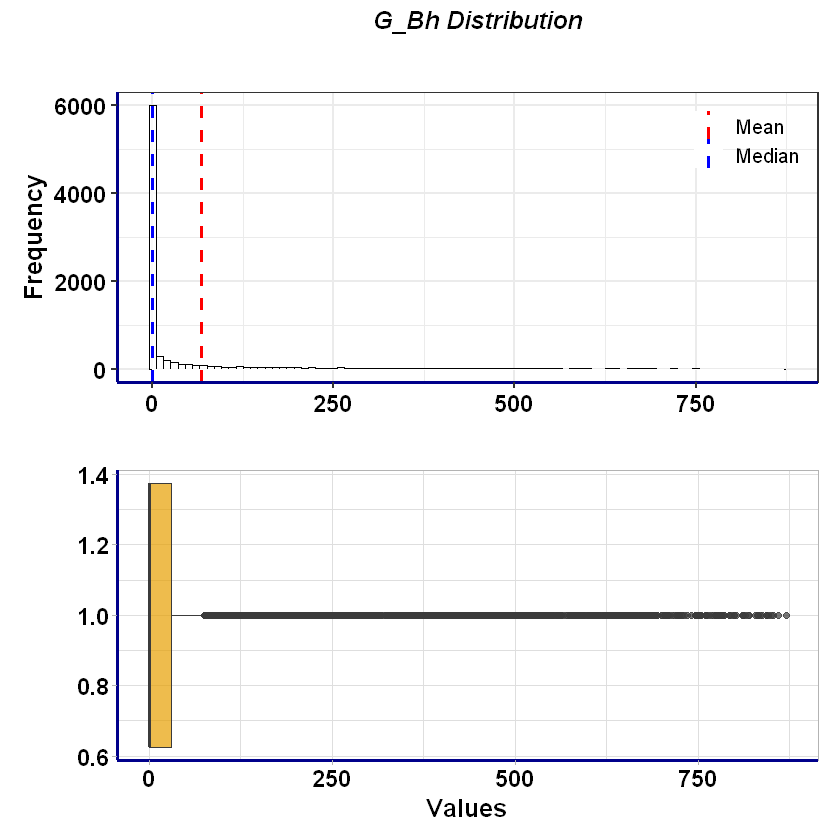

In [416]:
#G_Bh

theme_set(theme_light())

# Plot a histogram
hist_plt <- Saar_hour %>% 
  ggplot(mapping = aes(x = G_Bh)) + 
  geom_histogram(bins = 100, binwidth = 10, colour ="black",fill="white", alpha = 0.7) +
  geom_density(aes(G_Bh), alpha = 0.2, fill="orangered", color="white")+
    theme_bw(base_family = "", base_size = 15)+
  # Add lines for mean and median
  geom_vline(aes(xintercept = mean(G_Bh), color = 'Mean'), linetype = "dashed", size = 1) +
  geom_vline(aes(xintercept = median(G_Bh), color = 'Median'), linetype = "dashed", size = 1 ) +
  xlab("") +
  ylab("Frequency") +
  labs(title ="")+
  scale_color_manual(name = "", values = c(Mean = "red", Median = "blue")) +
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))

# Plot a box plot
box_plt <- Saar_hour %>% 
  ggplot(aes(x = G_Bh, y = 1)) +
  geom_boxplot(fill = "#E69F00", color = "gray23", alpha = 0.7) +
    # Add titles and labels
  xlab("Values")+
  ylab("")+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))


# Combine plots
(hist_plt / box_plt) +
  plot_annotation(title = 'G_Bh Distribution',
                  theme = theme(plot.title = element_text(hjust = 0.6, size=15, face="bold.italic")))


# Get summary statistics
min_val <- min(Saar_hour$G_Bh)
max_val <- max(Saar_hour$G_Bh)
mean_val <- mean(Saar_hour$G_Bh)
med_val <- median(Saar_hour$G_Bh)
mod_val <- mfv(Saar_hour$G_Bh)

# Print the stats
cat(
  "Minimum: ", round(min_val, 2),
   "\nMean: ", round(mean_val, 2),
   "\nMedian: ", round(med_val, 2),
   "\nMode: ", round(mod_val, 2),
   "\nMaximum: ", round(max_val, 2)
)


Minimum:  0 
Mean:  12.05 
Median:  0 
Mode:  0 
Maximum:  60

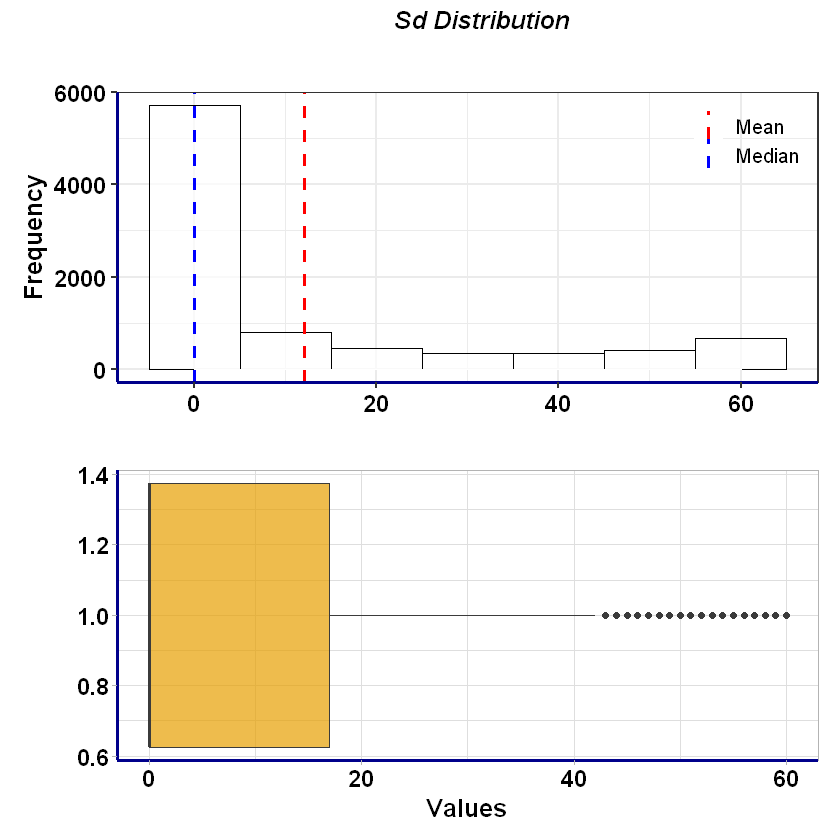

In [417]:
#Sd

theme_set(theme_light())

# Plot a histogram
hist_plt <- Saar_hour %>% 
  ggplot(mapping = aes(x = Sd)) + 
  geom_histogram(bins = 100, binwidth = 10, colour ="black",fill="white", alpha = 0.7) +
  geom_density(aes(Sd), alpha = 0.2, fill="orangered", color="white")+
    theme_bw(base_family = "", base_size = 15)+
  # Add lines for mean and median
  geom_vline(aes(xintercept = mean(Sd), color = 'Mean'), linetype = "dashed", size = 1) +
  geom_vline(aes(xintercept = median(Sd), color = 'Median'), linetype = "dashed", size = 1 ) +
  xlab("") +
  ylab("Frequency") +
  labs(title ="")+
  scale_color_manual(name = "", values = c(Mean = "red", Median = "blue")) +
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))

# Plot a box plot
box_plt <- Saar_hour %>% 
  ggplot(aes(x = Sd, y = 1)) +
  geom_boxplot(fill = "#E69F00", color = "gray23", alpha = 0.7) +
    # Add titles and labels
  xlab("Values")+
  ylab("")+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))


# Combine plots
(hist_plt / box_plt) +
  plot_annotation(title = 'Sd Distribution',
                  theme = theme(plot.title = element_text(hjust = 0.6, size=15, face="bold.italic")))


# Get summary statistics
min_val <- min(Saar_hour$Sd)
max_val <- max(Saar_hour$Sd)
mean_val <- mean(Saar_hour$Sd)
med_val <- median(Saar_hour$Sd)
mod_val <- mfv(Saar_hour$Sd)

# Print the stats
cat(
  "Minimum: ", round(min_val, 2),
   "\nMean: ", round(mean_val, 2),
   "\nMedian: ", round(med_val, 2),
   "\nMode: ", round(mod_val, 2),
   "\nMaximum: ", round(max_val, 2)
)


Minimum:  0 
Mean:  7897.61 
Median:  165.5 
Mode:  0 
Maximum:  54648

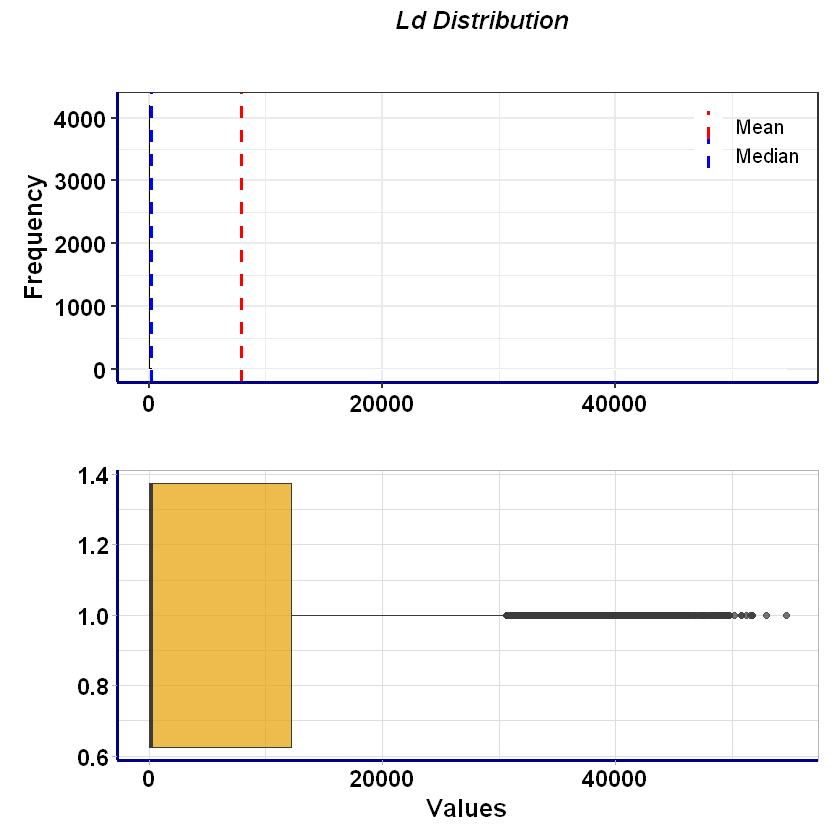

In [418]:
#Ld

theme_set(theme_light())

# Plot a histogram
hist_plt <- Saar_hour %>% 
  ggplot(mapping = aes(x = Ld)) + 
  geom_histogram(bins = 100, binwidth = 10, colour ="black",fill="white", alpha = 0.7) +
  geom_density(aes(Ld), alpha = 0.2, fill="orangered", color="white")+
    theme_bw(base_family = "", base_size = 15)+
  # Add lines for mean and median
  geom_vline(aes(xintercept = mean(Ld), color = 'Mean'), linetype = "dashed", size = 1) +
  geom_vline(aes(xintercept = median(Ld), color = 'Median'), linetype = "dashed", size = 1 ) +
  xlab("") +
  ylab("Frequency") +
  labs(title ="")+
  scale_color_manual(name = "", values = c(Mean = "red", Median = "blue")) +
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))

# Plot a box plot
box_plt <- Saar_hour %>% 
  ggplot(aes(x = Ld, y = 1)) +
  geom_boxplot(fill = "#E69F00", color = "gray23", alpha = 0.7) +
    # Add titles and labels
  xlab("Values")+
  ylab("")+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))


# Combine plots
(hist_plt / box_plt) +
  plot_annotation(title = 'Ld Distribution',
                  theme = theme(plot.title = element_text(hjust = 0.6, size=15, face="bold.italic")))


# Get summary statistics
min_val <- min(Saar_hour$Ld)
max_val <- max(Saar_hour$Ld)
mean_val <- mean(Saar_hour$Ld)
med_val <- median(Saar_hour$Ld)
mod_val <- mfv(Saar_hour$Ld)

# Print the stats
cat(
  "Minimum: ", round(min_val, 2),
   "\nMean: ", round(mean_val, 2),
   "\nMedian: ", round(med_val, 2),
   "\nMode: ", round(mod_val, 2),
   "\nMaximum: ", round(max_val, 2)
)


Minimum:  0 
Mean:  58.4 
Median:  2 
Mode:  0 
Maximum:  409

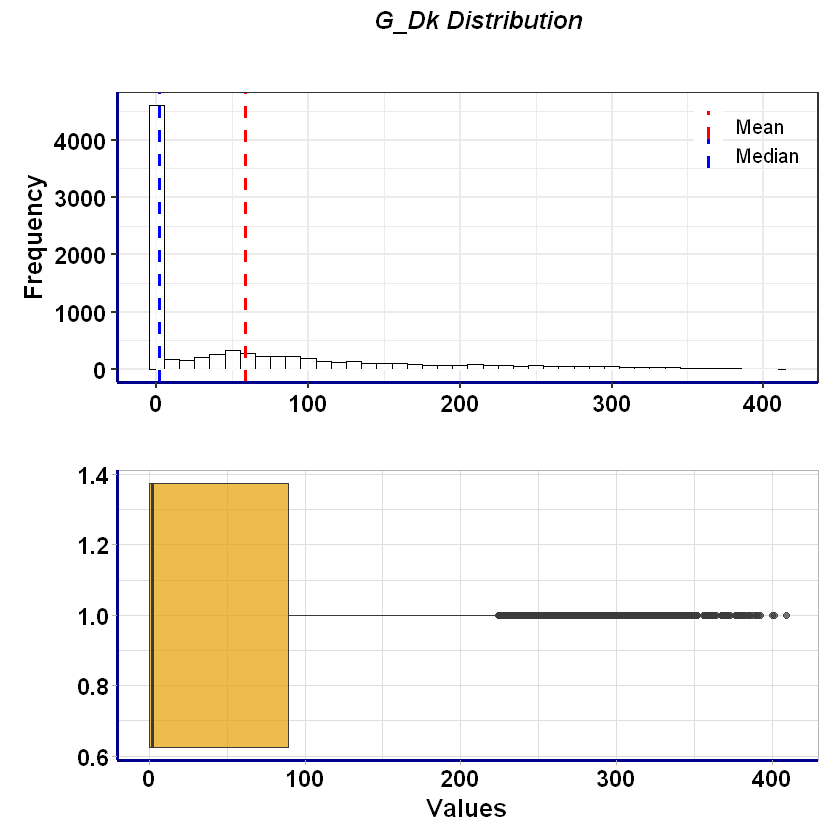

In [419]:
#G_Dk

theme_set(theme_light())

# Plot a histogram
hist_plt <- Saar_hour %>% 
  ggplot(mapping = aes(x = G_Dk)) + 
  geom_histogram(bins = 100, binwidth = 10, colour ="black",fill="white", alpha = 0.7) +
  geom_density(aes(G_Dk), alpha = 0.2, fill="orangered", color="white")+
    theme_bw(base_family = "", base_size = 15)+
  # Add lines for mean and median
  geom_vline(aes(xintercept = mean(G_Dk), color = 'Mean'), linetype = "dashed", size = 1) +
  geom_vline(aes(xintercept = median(G_Dk), color = 'Median'), linetype = "dashed", size = 1 ) +
  xlab("") +
  ylab("Frequency") +
  labs(title ="")+
  scale_color_manual(name = "", values = c(Mean = "red", Median = "blue")) +
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))

# Plot a box plot
box_plt <- Saar_hour %>% 
  ggplot(aes(x = G_Dk, y = 1)) +
  geom_boxplot(fill = "#E69F00", color = "gray23", alpha = 0.7) +
    # Add titles and labels
  xlab("Values")+
  ylab("")+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))


# Combine plots
(hist_plt / box_plt) +
  plot_annotation(title = 'G_Dk Distribution',
                  theme = theme(plot.title = element_text(hjust = 0.6, size=15, face="bold.italic")))


# Get summary statistics
min_val <- min(Saar_hour$G_Dk)
max_val <- max(Saar_hour$G_Dk)
mean_val <- mean(Saar_hour$G_Dk)
med_val <- median(Saar_hour$G_Dk)
mod_val <- mfv(Saar_hour$G_Dk)

# Print the stats
cat(
  "Minimum: ", round(min_val, 2),
   "\nMean: ", round(mean_val, 2),
   "\nMedian: ", round(med_val, 2),
   "\nMode: ", round(mod_val, 2),
   "\nMaximum: ", round(max_val, 2)
)


Minimum:  0 
Mean:  63.56 
Median:  2 
Mode:  0 
Maximum:  453

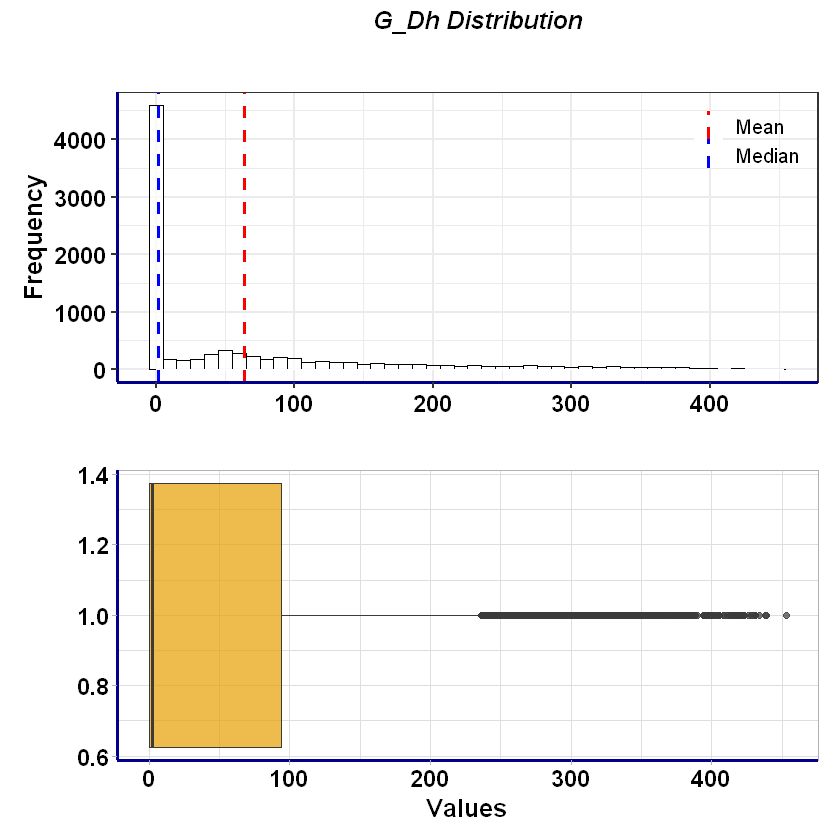

In [420]:
#G_Dh

theme_set(theme_light())

# Plot a histogram
hist_plt <- Saar_hour %>% 
  ggplot(mapping = aes(x = G_Dh)) + 
  geom_histogram(bins = 100, binwidth = 10, colour ="black",fill="white", alpha = 0.7) +
  geom_density(aes(G_Dh), alpha = 0.2, fill="orangered", color="white")+
    theme_bw(base_family = "", base_size = 15)+
  # Add lines for mean and median
  geom_vline(aes(xintercept = mean(G_Dh), color = 'Mean'), linetype = "dashed", size = 1) +
  geom_vline(aes(xintercept = median(G_Dh), color = 'Median'), linetype = "dashed", size = 1 ) +
  xlab("") +
  ylab("Frequency") +
  labs(title ="")+
  scale_color_manual(name = "", values = c(Mean = "red", Median = "blue")) +
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))

# Plot a box plot
box_plt <- Saar_hour %>% 
  ggplot(aes(x = G_Dh, y = 1)) +
  geom_boxplot(fill = "#E69F00", color = "gray23", alpha = 0.7) +
    # Add titles and labels
  xlab("Values")+
  ylab("")+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))


# Combine plots
(hist_plt / box_plt) +
  plot_annotation(title = 'G_Dh Distribution',
                  theme = theme(plot.title = element_text(hjust = 0.6, size=15, face="bold.italic")))


# Get summary statistics
min_val <- min(Saar_hour$G_Dh)
max_val <- max(Saar_hour$G_Dh)
mean_val <- mean(Saar_hour$G_Dh)
med_val <- median(Saar_hour$G_Dh)
mod_val <- mfv(Saar_hour$G_Dh)

# Print the stats
cat(
  "Minimum: ", round(min_val, 2),
   "\nMean: ", round(mean_val, 2),
   "\nMedian: ", round(med_val, 2),
   "\nMode: ", round(mod_val, 2),
   "\nMaximum: ", round(max_val, 2)
)


Minimum:  0 
Mean:  127.01 
Median:  0 
Mode:  0 
Maximum:  992

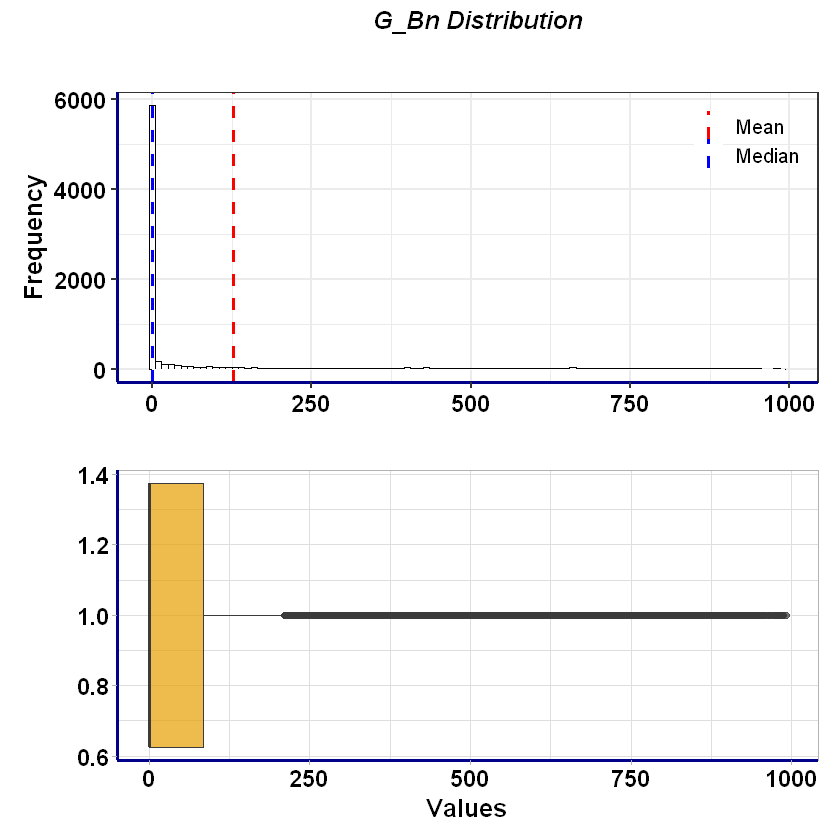

In [421]:
#G_Bn

theme_set(theme_light())

# Plot a histogram
hist_plt <- Saar_hour %>% 
  ggplot(mapping = aes(x = G_Bn)) + 
  geom_histogram(bins = 100, binwidth = 10, colour ="black",fill="white", alpha = 0.7) +
  geom_density(aes(G_Bn), alpha = 0.2, fill="orangered", color="white")+
    theme_bw(base_family = "", base_size = 15)+
  # Add lines for mean and median
  geom_vline(aes(xintercept = mean(G_Bn), color = 'Mean'), linetype = "dashed", size = 1) +
  geom_vline(aes(xintercept = median(G_Bn), color = 'Median'), linetype = "dashed", size = 1 ) +
  xlab("") +
  ylab("Frequency") +
  labs(title ="")+
  scale_color_manual(name = "", values = c(Mean = "red", Median = "blue")) +
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))

# Plot a box plot
box_plt <- Saar_hour %>% 
  ggplot(aes(x = G_Bn, y = 1)) +
  geom_boxplot(fill = "#E69F00", color = "gray23", alpha = 0.7) +
    # Add titles and labels
  xlab("Values")+
  ylab("")+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))


# Combine plots
(hist_plt / box_plt) +
  plot_annotation(title = 'G_Bn Distribution',
                  theme = theme(plot.title = element_text(hjust = 0.6, size=15, face="bold.italic")))


# Get summary statistics
min_val <- min(Saar_hour$G_Bn)
max_val <- max(Saar_hour$G_Bn)
mean_val <- mean(Saar_hour$G_Bn)
med_val <- median(Saar_hour$G_Bn)
mod_val <- mfv(Saar_hour$G_Bn)

# Print the stats
cat(
  "Minimum: ", round(min_val, 2),
   "\nMean: ", round(mean_val, 2),
   "\nMedian: ", round(med_val, 2),
   "\nMode: ", round(mod_val, 2),
   "\nMaximum: ", round(max_val, 2)
)


Minimum:  -12.9 
Mean:  9.59 
Median:  8.6 
Mode:  0 
Maximum:  40.5

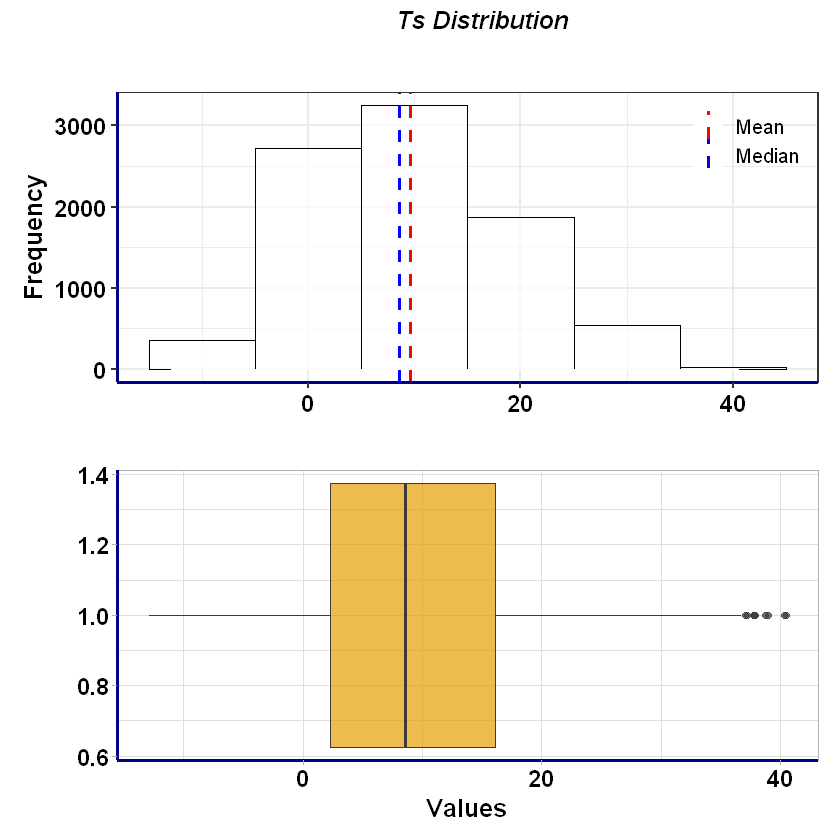

In [422]:
#Ts

theme_set(theme_light())

# Plot a histogram
hist_plt <- Saar_hour %>% 
  ggplot(mapping = aes(x = Ts)) + 
  geom_histogram(bins = 100, binwidth = 10, colour ="black",fill="white", alpha = 0.7) +
  geom_density(aes(Ts), alpha = 0.2, fill="orangered", color="white")+
    theme_bw(base_family = "", base_size = 15)+
  # Add lines for mean and median
  geom_vline(aes(xintercept = mean(Ts), color = 'Mean'), linetype = "dashed", size = 1) +
  geom_vline(aes(xintercept = median(Ts), color = 'Median'), linetype = "dashed", size = 1 ) +
  xlab("") +
  ylab("Frequency") +
  labs(title ="")+
  scale_color_manual(name = "", values = c(Mean = "red", Median = "blue")) +
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))

# Plot a box plot
box_plt <- Saar_hour %>% 
  ggplot(aes(x = Ts, y = 1)) +
  geom_boxplot(fill = "#E69F00", color = "gray23", alpha = 0.7) +
    # Add titles and labels
  xlab("Values")+
  ylab("")+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))


# Combine plots
(hist_plt / box_plt) +
  plot_annotation(title = 'Ts Distribution',
                  theme = theme(plot.title = element_text(hjust = 0.6, size=15, face="bold.italic")))


# Get summary statistics
min_val <- min(Saar_hour$Ts)
max_val <- max(Saar_hour$Ts)
mean_val <- mean(Saar_hour$Ts)
med_val <- median(Saar_hour$Ts)
mod_val <- mfv(Saar_hour$Ts)

# Print the stats
cat(
  "Minimum: ", round(min_val, 2),
   "\nMean: ", round(mean_val, 2),
   "\nMedian: ", round(med_val, 2),
   "\nMode: ", round(mod_val, 2),
   "\nMaximum: ", round(max_val, 2)
)


Minimum:  -10.1 
Mean:  9.9 
Median:  9.7 
Mode:  11 
Maximum:  32.1

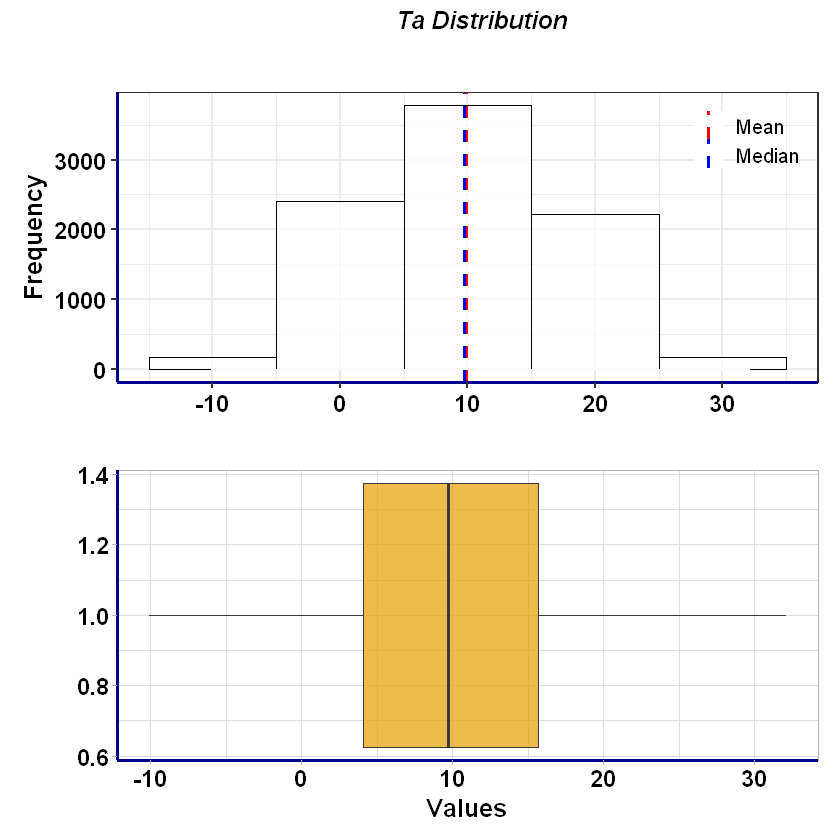

In [423]:
#Ta

theme_set(theme_light())

# Plot a histogram
hist_plt <- Saar_hour %>% 
  ggplot(mapping = aes(x = Ta)) + 
  geom_histogram(bins = 100, binwidth = 10, colour ="black",fill="white", alpha = 0.7) +
  geom_density(aes(Ta), alpha = 0.2, fill="orangered", color="white")+
    theme_bw(base_family = "", base_size = 15)+
  # Add lines for mean and median
  geom_vline(aes(xintercept = mean(Ta), color = 'Mean'), linetype = "dashed", size = 1) +
  geom_vline(aes(xintercept = median(Ta), color = 'Median'), linetype = "dashed", size = 1 ) +
  xlab("") +
  ylab("Frequency") +
  labs(title ="")+
  scale_color_manual(name = "", values = c(Mean = "red", Median = "blue")) +
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))

# Plot a box plot
box_plt <- Saar_hour %>% 
  ggplot(aes(x = Ta, y = 1)) +
  geom_boxplot(fill = "#E69F00", color = "gray23", alpha = 0.7) +
    # Add titles and labels
  xlab("Values")+
  ylab("")+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))


# Combine plots
(hist_plt / box_plt) +
  plot_annotation(title = 'Ta Distribution',
                  theme = theme(plot.title = element_text(hjust = 0.6, size=15, face="bold.italic")))


# Get summary statistics
min_val <- min(Saar_hour$Ta)
max_val <- max(Saar_hour$Ta)
mean_val <- mean(Saar_hour$Ta)
med_val <- median(Saar_hour$Ta)
mod_val <- mfv(Saar_hour$Ta)

# Print the stats
cat(
  "Minimum: ", round(min_val, 2),
   "\nMean: ", round(mean_val, 2),
   "\nMedian: ", round(med_val, 2),
   "\nMode: ", round(mod_val, 2),
   "\nMaximum: ", round(max_val, 2)
)


Warning message:
"Removed 352 rows containing missing values (position_stack)."
Warning message:
"Removed 65 row(s) containing missing values (geom_path)."
Warning message:
"Removed 255 rows containing missing values (position_stack)."
Warning message:
"Removed 65 row(s) containing missing values (geom_path)."
Warning message:
"Removed 157 rows containing missing values (position_stack)."
Warning message:
"Removed 65 row(s) containing missing values (geom_path)."


68.27% of grades fall within one standard deviation from the mean.
95.45% of grades fall within one standard deviation from the mean.
99.73% of grades fall within one standard deviation from the mean.

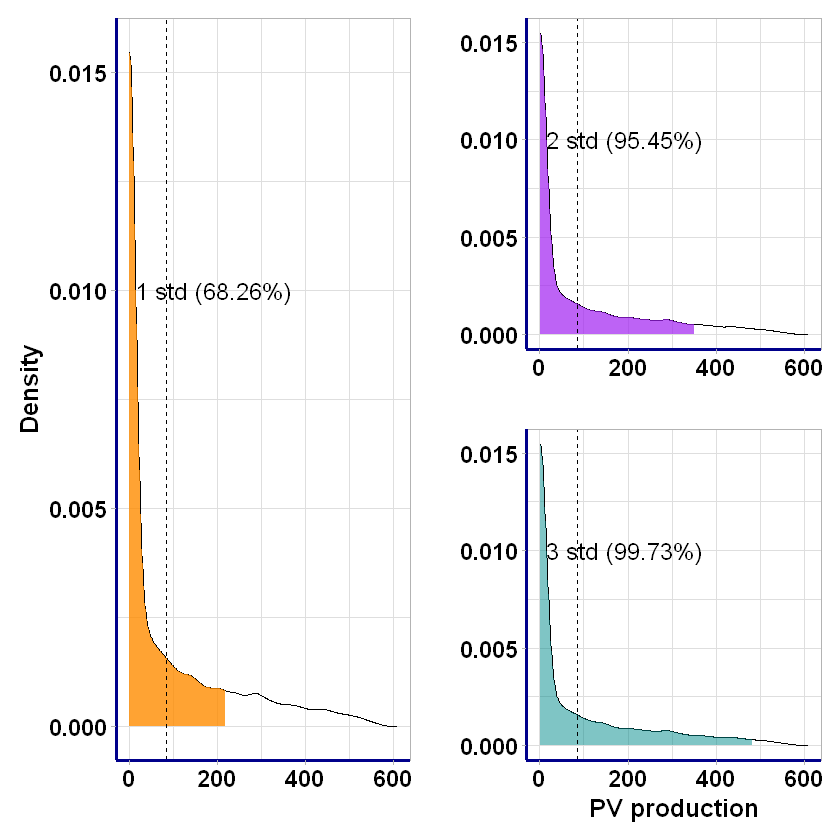

In [408]:
# PV

# Get the Grade column
col <- Saar_hour %>% 
  select(PV)

# Compute kernel density estimates
density <- density(pull(col), kernel = "gaussian")

# Create a dataframe containing coordinates where density is estimated
#and the corresponding estimated value
density_xy <- tibble(
  x = density$x,
  y = density$y
)

# Make density plots for various deviations of the mean

plt_sd_1 <- density_xy %>%
  ggplot(mapping = aes(x = x, y = y)) +
  geom_line() +
  geom_area(mapping = aes(x = ifelse(x>(mean_grade-std_dev) & x<(mean_grade+std_dev), x, 0)), fill = "darkorange", alpha = 0.8) +
  annotate("text", x = 50, y = 0.01, label = "1 std (68.26%)", size=5, hjust = 0.1) +
  xlim(1, max(col))+
  geom_vline(xintercept = mean_grade, linetype = "dashed") +
  labs(x = "", y = "Density")+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))


# 2 std deviations from the mean
plt_sd_2 <- density_xy %>%
  ggplot(mapping = aes(x = x, y = y)) +
  geom_line() +
  geom_area(mapping = aes(x = ifelse(x>(mean_grade-(2*std_dev)) & x<(mean_grade+(2*std_dev)), x, 0)), fill = "purple", alpha = 0.7) +
  annotate("text", x = 50, y = 0.01, label = "2 std (95.45%)", size=5, hjust = 0.1) +
  xlim(1, max(col)) +
  geom_vline(xintercept = mean_grade, linetype = "dashed") +
  labs(x = "", y = "")+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))


# 3 std deviations from the mean
plt_sd_3 <- density_xy %>%
  ggplot(aes(x = x, y = y)) +
  geom_line() +
  geom_area(mapping = aes(x = ifelse(x>(mean_grade-(3*std_dev)) & x<(mean_grade+(3*std_dev)), x, 0)), fill = "cyan4", alpha = 0.5) +
  annotate("text", x = 50, y = 0.01, label = "3 std (99.73%)", size=5, hjust = 0.1) +
  xlim(1, max(col)) +
  geom_vline(xintercept = mean_grade, linetype = "dashed") +
  labs(x = "Values", y = "")+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))



# Patching things up
plt_sd_1| (plt_sd_2/plt_sd_3) 



#summary(Saar_hour)


# Get the mean grade
mean_grade <- mean(pull(col))

# Get the standard deviation of grades
std_dev <- sd(pull(col))

# Find proportion that will fall within 1 standard deviation
one_std_dev <- pnorm((mean_grade + std_dev), mean = mean_grade, sd = std_dev) -
  pnorm((mean_grade - std_dev), mean = mean_grade, sd = std_dev)

# Find proportion that will fall within 2 standard deviations
two_std_dev <- pnorm((mean_grade + (2*std_dev)), mean = mean_grade, sd = std_dev) - 
  pnorm((mean_grade - (2*std_dev)), mean = mean_grade, sd = std_dev)

# Find proportion that will fall within 3 standard deviations
three_std_dev <- pnorm((mean_grade + (3*std_dev)), mean = mean_grade, sd = std_dev) - 
  pnorm((mean_grade - (3*std_dev)), mean = mean_grade, sd = std_dev)

glue(
  '
  {format(round(one_std_dev*100, 2), nsmall = 2)}% of grades fall within one standard deviation from the mean.
  {format(round(two_std_dev*100, 2), nsmall = 2)}% of grades fall within one standard deviation from the mean.
  {format(round(three_std_dev*100, 2), nsmall = 2)}% of grades fall within one standard deviation from the mean.
  
  '
)

Warning message:
"Removed 393 rows containing missing values (position_stack)."
Warning message:
"Removed 57 row(s) containing missing values (geom_path)."
Warning message:
"Removed 321 rows containing missing values (position_stack)."
Warning message:
"Removed 57 row(s) containing missing values (geom_path)."
Warning message:
"Removed 248 rows containing missing values (position_stack)."
Warning message:
"Removed 57 row(s) containing missing values (geom_path)."


68.27% of grades fall within one standard deviation from the mean.
95.45% of grades fall within one standard deviation from the mean.
99.73% of grades fall within one standard deviation from the mean.

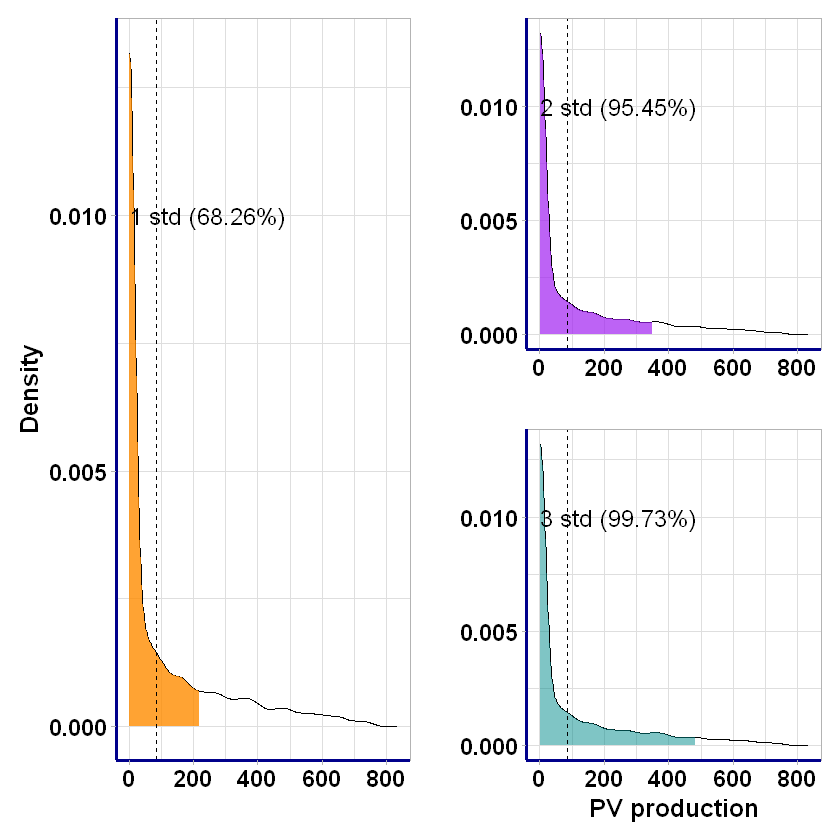

In [424]:
# G_Gk

# Get the Grade column
col <- Saar_hour %>% 
  select(G_Gk)

# Compute kernel density estimates
density <- density(pull(col), kernel = "gaussian")

# Create a dataframe containing coordinates where density is estimated
#and the corresponding estimated value
density_xy <- tibble(
  x = density$x,
  y = density$y
)

# Make density plots for various deviations of the mean

plt_sd_1 <- density_xy %>%
  ggplot(mapping = aes(x = x, y = y)) +
  geom_line() +
  geom_area(mapping = aes(x = ifelse(x>(mean_grade-std_dev) & x<(mean_grade+std_dev), x, 0)), fill = "darkorange", alpha = 0.8) +
  annotate("text", x = 50, y = 0.01, label = "1 std (68.26%)", size=5, hjust = 0.1) +
  xlim(1, max(col))+
  geom_vline(xintercept = mean_grade, linetype = "dashed") +
  labs(x = "", y = "Density")+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))


# 2 std deviations from the mean
plt_sd_2 <- density_xy %>%
  ggplot(mapping = aes(x = x, y = y)) +
  geom_line() +
  geom_area(mapping = aes(x = ifelse(x>(mean_grade-(2*std_dev)) & x<(mean_grade+(2*std_dev)), x, 0)), fill = "purple", alpha = 0.7) +
  annotate("text", x = 50, y = 0.01, label = "2 std (95.45%)", size=5, hjust = 0.1) +
  xlim(1, max(col)) +
  geom_vline(xintercept = mean_grade, linetype = "dashed") +
  labs(x = "", y = "")+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))


# 3 std deviations from the mean
plt_sd_3 <- density_xy %>%
  ggplot(aes(x = x, y = y)) +
  geom_line() +
  geom_area(mapping = aes(x = ifelse(x>(mean_grade-(3*std_dev)) & x<(mean_grade+(3*std_dev)), x, 0)), fill = "cyan4", alpha = 0.5) +
  annotate("text", x = 50, y = 0.01, label = "3 std (99.73%)", size=5, hjust = 0.1) +
  xlim(1, max(col)) +
  geom_vline(xintercept = mean_grade, linetype = "dashed") +
  labs(x = "Values", y = "")+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))



# Patching things up
plt_sd_1| (plt_sd_2/plt_sd_3) 



#summary(Saar_hour)


# Get the mean grade
mean_grade <- mean(pull(col))

# Get the standard deviation of grades
std_dev <- sd(pull(col))

# Find proportion that will fall within 1 standard deviation
one_std_dev <- pnorm((mean_grade + std_dev), mean = mean_grade, sd = std_dev) -
  pnorm((mean_grade - std_dev), mean = mean_grade, sd = std_dev)

# Find proportion that will fall within 2 standard deviations
two_std_dev <- pnorm((mean_grade + (2*std_dev)), mean = mean_grade, sd = std_dev) - 
  pnorm((mean_grade - (2*std_dev)), mean = mean_grade, sd = std_dev)

# Find proportion that will fall within 3 standard deviations
three_std_dev <- pnorm((mean_grade + (3*std_dev)), mean = mean_grade, sd = std_dev) - 
  pnorm((mean_grade - (3*std_dev)), mean = mean_grade, sd = std_dev)

glue(
  '
  {format(round(one_std_dev*100, 2), nsmall = 2)}% of grades fall within one standard deviation from the mean.
  {format(round(two_std_dev*100, 2), nsmall = 2)}% of grades fall within one standard deviation from the mean.
  {format(round(three_std_dev*100, 2), nsmall = 2)}% of grades fall within one standard deviation from the mean.
  
  '
)

Warning message:
"Removed 512 rows containing missing values (position_stack)."
Warning message:
"Removed 62 row(s) containing missing values (geom_path)."
Warning message:
"Removed 512 rows containing missing values (position_stack)."
Warning message:
"Removed 62 row(s) containing missing values (geom_path)."
Warning message:
"Removed 512 rows containing missing values (position_stack)."
Warning message:
"Removed 62 row(s) containing missing values (geom_path)."


68.27% of grades fall within one standard deviation from the mean.
95.45% of grades fall within one standard deviation from the mean.
99.73% of grades fall within one standard deviation from the mean.

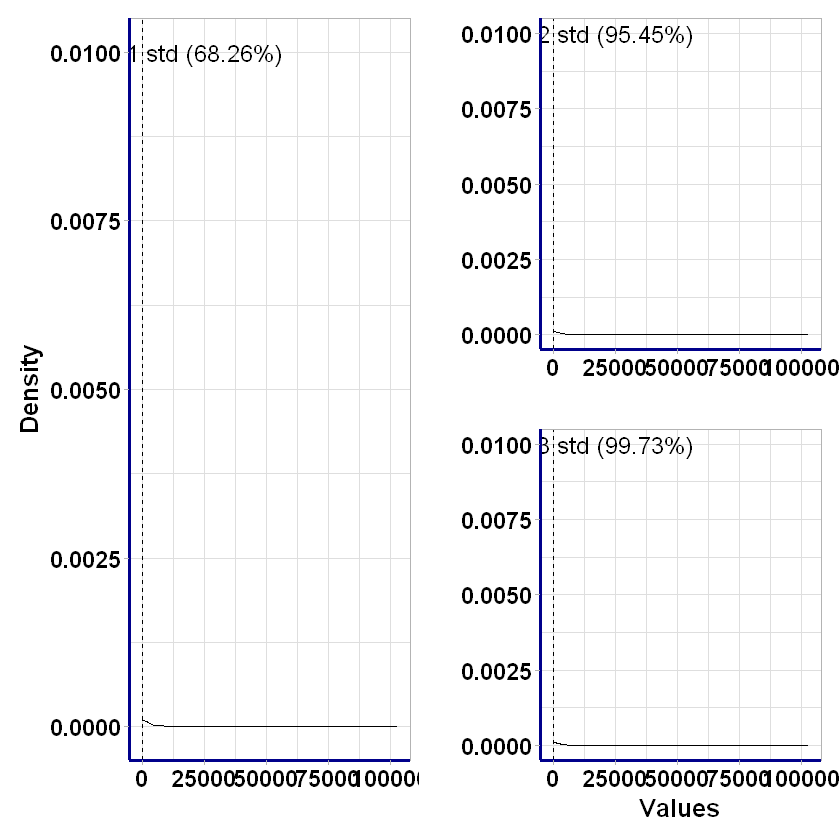

In [426]:
# Lg

# Get the Grade column
col <- Saar_hour %>% 
  select(Lg)

# Compute kernel density estimates
density <- density(pull(col), kernel = "gaussian")

# Create a dataframe containing coordinates where density is estimated
#and the corresponding estimated value
density_xy <- tibble(
  x = density$x,
  y = density$y
)

# Make density plots for various deviations of the mean

plt_sd_1 <- density_xy %>%
  ggplot(mapping = aes(x = x, y = y)) +
  geom_line() +
  geom_area(mapping = aes(x = ifelse(x>(mean_grade-std_dev) & x<(mean_grade+std_dev), x, 0)), fill = "darkorange", alpha = 0.8) +
  annotate("text", x = 50, y = 0.01, label = "1 std (68.26%)", size=5, hjust = 0.1) +
  xlim(1, max(col))+
  geom_vline(xintercept = mean_grade, linetype = "dashed") +
  labs(x = "", y = "Density")+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))


# 2 std deviations from the mean
plt_sd_2 <- density_xy %>%
  ggplot(mapping = aes(x = x, y = y)) +
  geom_line() +
  geom_area(mapping = aes(x = ifelse(x>(mean_grade-(2*std_dev)) & x<(mean_grade+(2*std_dev)), x, 0)), fill = "purple", alpha = 0.7) +
  annotate("text", x = 50, y = 0.01, label = "2 std (95.45%)", size=5, hjust = 0.1) +
  xlim(1, max(col)) +
  geom_vline(xintercept = mean_grade, linetype = "dashed") +
  labs(x = "", y = "")+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))


# 3 std deviations from the mean
plt_sd_3 <- density_xy %>%
  ggplot(aes(x = x, y = y)) +
  geom_line() +
  geom_area(mapping = aes(x = ifelse(x>(mean_grade-(3*std_dev)) & x<(mean_grade+(3*std_dev)), x, 0)), fill = "cyan4", alpha = 0.5) +
  annotate("text", x = 50, y = 0.01, label = "3 std (99.73%)", size=5, hjust = 0.1) +
  xlim(1, max(col)) +
  geom_vline(xintercept = mean_grade, linetype = "dashed") +
  labs(x = "Values", y = "")+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))



# Patching things up
plt_sd_1| (plt_sd_2/plt_sd_3) 



#summary(Saar_hour)


# Get the mean grade
mean_grade <- mean(pull(col))

# Get the standard deviation of grades
std_dev <- sd(pull(col))

# Find proportion that will fall within 1 standard deviation
one_std_dev <- pnorm((mean_grade + std_dev), mean = mean_grade, sd = std_dev) -
  pnorm((mean_grade - std_dev), mean = mean_grade, sd = std_dev)

# Find proportion that will fall within 2 standard deviations
two_std_dev <- pnorm((mean_grade + (2*std_dev)), mean = mean_grade, sd = std_dev) - 
  pnorm((mean_grade - (2*std_dev)), mean = mean_grade, sd = std_dev)

# Find proportion that will fall within 3 standard deviations
three_std_dev <- pnorm((mean_grade + (3*std_dev)), mean = mean_grade, sd = std_dev) - 
  pnorm((mean_grade - (3*std_dev)), mean = mean_grade, sd = std_dev)

glue(
  '
  {format(round(one_std_dev*100, 2), nsmall = 2)}% of grades fall within one standard deviation from the mean.
  {format(round(two_std_dev*100, 2), nsmall = 2)}% of grades fall within one standard deviation from the mean.
  {format(round(three_std_dev*100, 2), nsmall = 2)}% of grades fall within one standard deviation from the mean.
  
  '
)

Warning message:
"Removed 60 rows containing missing values (position_stack)."
Warning message:
"Removed 60 row(s) containing missing values (geom_path)."
Warning message:
"Removed 1 rows containing missing values (geom_vline)."
Warning message:
"Removed 60 rows containing missing values (position_stack)."
Warning message:
"Removed 60 row(s) containing missing values (geom_path)."
Warning message:
"Removed 1 rows containing missing values (geom_vline)."
Warning message:
"Removed 60 rows containing missing values (position_stack)."
Warning message:
"Removed 60 row(s) containing missing values (geom_path)."
Warning message:
"Removed 1 rows containing missing values (geom_vline)."


68.27% of grades fall within one standard deviation from the mean.
95.45% of grades fall within one standard deviation from the mean.
99.73% of grades fall within one standard deviation from the mean.

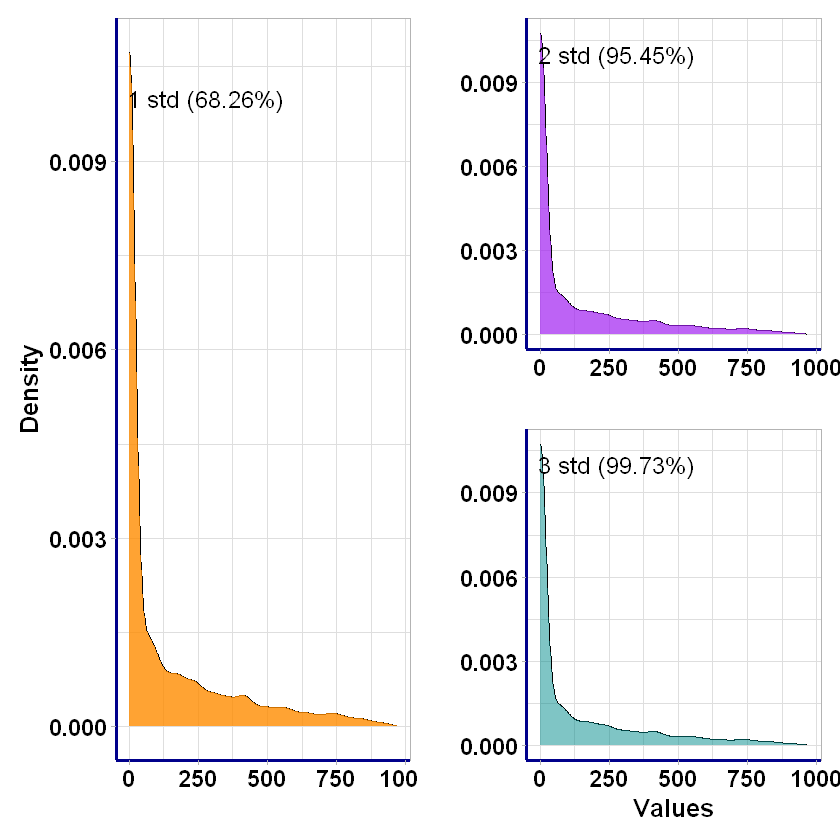

In [427]:
# G_Gh

# Get the Grade column
col <- Saar_hour %>% 
  select(G_Gh)

# Compute kernel density estimates
density <- density(pull(col), kernel = "gaussian")

# Create a dataframe containing coordinates where density is estimated
#and the corresponding estimated value
density_xy <- tibble(
  x = density$x,
  y = density$y
)

# Make density plots for various deviations of the mean

plt_sd_1 <- density_xy %>%
  ggplot(mapping = aes(x = x, y = y)) +
  geom_line() +
  geom_area(mapping = aes(x = ifelse(x>(mean_grade-std_dev) & x<(mean_grade+std_dev), x, 0)), fill = "darkorange", alpha = 0.8) +
  annotate("text", x = 50, y = 0.01, label = "1 std (68.26%)", size=5, hjust = 0.1) +
  xlim(1, max(col))+
  geom_vline(xintercept = mean_grade, linetype = "dashed") +
  labs(x = "", y = "Density")+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))


# 2 std deviations from the mean
plt_sd_2 <- density_xy %>%
  ggplot(mapping = aes(x = x, y = y)) +
  geom_line() +
  geom_area(mapping = aes(x = ifelse(x>(mean_grade-(2*std_dev)) & x<(mean_grade+(2*std_dev)), x, 0)), fill = "purple", alpha = 0.7) +
  annotate("text", x = 50, y = 0.01, label = "2 std (95.45%)", size=5, hjust = 0.1) +
  xlim(1, max(col)) +
  geom_vline(xintercept = mean_grade, linetype = "dashed") +
  labs(x = "", y = "")+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))


# 3 std deviations from the mean
plt_sd_3 <- density_xy %>%
  ggplot(aes(x = x, y = y)) +
  geom_line() +
  geom_area(mapping = aes(x = ifelse(x>(mean_grade-(3*std_dev)) & x<(mean_grade+(3*std_dev)), x, 0)), fill = "cyan4", alpha = 0.5) +
  annotate("text", x = 50, y = 0.01, label = "3 std (99.73%)", size=5, hjust = 0.1) +
  xlim(1, max(col)) +
  geom_vline(xintercept = mean_grade, linetype = "dashed") +
  labs(x = "Values", y = "")+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))



# Patching things up
plt_sd_1| (plt_sd_2/plt_sd_3) 



#summary(Saar_hour)


# Get the mean grade
mean_grade <- mean(pull(col))

# Get the standard deviation of grades
std_dev <- sd(pull(col))

# Find proportion that will fall within 1 standard deviation
one_std_dev <- pnorm((mean_grade + std_dev), mean = mean_grade, sd = std_dev) -
  pnorm((mean_grade - std_dev), mean = mean_grade, sd = std_dev)

# Find proportion that will fall within 2 standard deviations
two_std_dev <- pnorm((mean_grade + (2*std_dev)), mean = mean_grade, sd = std_dev) - 
  pnorm((mean_grade - (2*std_dev)), mean = mean_grade, sd = std_dev)

# Find proportion that will fall within 3 standard deviations
three_std_dev <- pnorm((mean_grade + (3*std_dev)), mean = mean_grade, sd = std_dev) - 
  pnorm((mean_grade - (3*std_dev)), mean = mean_grade, sd = std_dev)

glue(
  '
  {format(round(one_std_dev*100, 2), nsmall = 2)}% of grades fall within one standard deviation from the mean.
  {format(round(two_std_dev*100, 2), nsmall = 2)}% of grades fall within one standard deviation from the mean.
  {format(round(three_std_dev*100, 2), nsmall = 2)}% of grades fall within one standard deviation from the mean.
  
  '
)

Warning message:
"Removed 46 rows containing missing values (position_stack)."
Warning message:
"Removed 46 row(s) containing missing values (geom_path)."
Warning message:
"Removed 46 rows containing missing values (position_stack)."
Warning message:
"Removed 46 row(s) containing missing values (geom_path)."
Warning message:
"Removed 46 rows containing missing values (position_stack)."
Warning message:
"Removed 46 row(s) containing missing values (geom_path)."


68.27% of grades fall within one standard deviation from the mean.
95.45% of grades fall within one standard deviation from the mean.
99.73% of grades fall within one standard deviation from the mean.

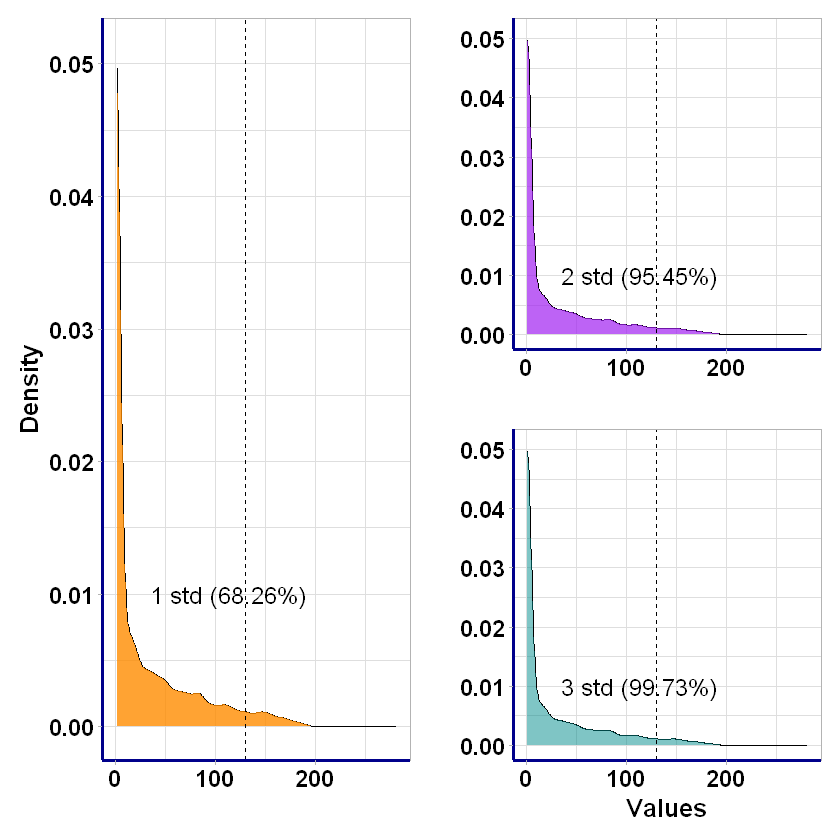

In [428]:
# G_Gref

# Get the Grade column
col <- Saar_hour %>% 
  select(G_Gref)

# Compute kernel density estimates
density <- density(pull(col), kernel = "gaussian")

# Create a dataframe containing coordinates where density is estimated
#and the corresponding estimated value
density_xy <- tibble(
  x = density$x,
  y = density$y
)

# Make density plots for various deviations of the mean

plt_sd_1 <- density_xy %>%
  ggplot(mapping = aes(x = x, y = y)) +
  geom_line() +
  geom_area(mapping = aes(x = ifelse(x>(mean_grade-std_dev) & x<(mean_grade+std_dev), x, 0)), fill = "darkorange", alpha = 0.8) +
  annotate("text", x = 50, y = 0.01, label = "1 std (68.26%)", size=5, hjust = 0.1) +
  xlim(1, max(col))+
  geom_vline(xintercept = mean_grade, linetype = "dashed") +
  labs(x = "", y = "Density")+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))


# 2 std deviations from the mean
plt_sd_2 <- density_xy %>%
  ggplot(mapping = aes(x = x, y = y)) +
  geom_line() +
  geom_area(mapping = aes(x = ifelse(x>(mean_grade-(2*std_dev)) & x<(mean_grade+(2*std_dev)), x, 0)), fill = "purple", alpha = 0.7) +
  annotate("text", x = 50, y = 0.01, label = "2 std (95.45%)", size=5, hjust = 0.1) +
  xlim(1, max(col)) +
  geom_vline(xintercept = mean_grade, linetype = "dashed") +
  labs(x = "", y = "")+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))


# 3 std deviations from the mean
plt_sd_3 <- density_xy %>%
  ggplot(aes(x = x, y = y)) +
  geom_line() +
  geom_area(mapping = aes(x = ifelse(x>(mean_grade-(3*std_dev)) & x<(mean_grade+(3*std_dev)), x, 0)), fill = "cyan4", alpha = 0.5) +
  annotate("text", x = 50, y = 0.01, label = "3 std (99.73%)", size=5, hjust = 0.1) +
  xlim(1, max(col)) +
  geom_vline(xintercept = mean_grade, linetype = "dashed") +
  labs(x = "Values", y = "")+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))



# Patching things up
plt_sd_1| (plt_sd_2/plt_sd_3) 



#summary(Saar_hour)


# Get the mean grade
mean_grade <- mean(pull(col))

# Get the standard deviation of grades
std_dev <- sd(pull(col))

# Find proportion that will fall within 1 standard deviation
one_std_dev <- pnorm((mean_grade + std_dev), mean = mean_grade, sd = std_dev) -
  pnorm((mean_grade - std_dev), mean = mean_grade, sd = std_dev)

# Find proportion that will fall within 2 standard deviations
two_std_dev <- pnorm((mean_grade + (2*std_dev)), mean = mean_grade, sd = std_dev) - 
  pnorm((mean_grade - (2*std_dev)), mean = mean_grade, sd = std_dev)

# Find proportion that will fall within 3 standard deviations
three_std_dev <- pnorm((mean_grade + (3*std_dev)), mean = mean_grade, sd = std_dev) - 
  pnorm((mean_grade - (3*std_dev)), mean = mean_grade, sd = std_dev)

glue(
  '
  {format(round(one_std_dev*100, 2), nsmall = 2)}% of grades fall within one standard deviation from the mean.
  {format(round(two_std_dev*100, 2), nsmall = 2)}% of grades fall within one standard deviation from the mean.
  {format(round(three_std_dev*100, 2), nsmall = 2)}% of grades fall within one standard deviation from the mean.
  
  '
)

In [ ]:
# hs

# Get the Grade column
col <- Saar_hour %>% 
  select(hs)

# Compute kernel density estimates
density <- density(pull(col), kernel = "gaussian")

# Create a dataframe containing coordinates where density is estimated
#and the corresponding estimated value
density_xy <- tibble(
  x = density$x,
  y = density$y
)

# Make density plots for various deviations of the mean

plt_sd_1 <- density_xy %>%
  ggplot(mapping = aes(x = x, y = y)) +
  geom_line() +
  geom_area(mapping = aes(x = ifelse(x>(mean_grade-std_dev) & x<(mean_grade+std_dev), x, 0)), fill = "darkorange", alpha = 0.8) +
  annotate("text", x = 50, y = 0.01, label = "1 std (68.26%)", size=5, hjust = 0.1) +
  xlim(1, max(col))+
  geom_vline(xintercept = mean_grade, linetype = "dashed") +
  labs(x = "", y = "Density")+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))


# 2 std deviations from the mean
plt_sd_2 <- density_xy %>%
  ggplot(mapping = aes(x = x, y = y)) +
  geom_line() +
  geom_area(mapping = aes(x = ifelse(x>(mean_grade-(2*std_dev)) & x<(mean_grade+(2*std_dev)), x, 0)), fill = "purple", alpha = 0.7) +
  annotate("text", x = 50, y = 0.01, label = "2 std (95.45%)", size=5, hjust = 0.1) +
  xlim(1, max(col)) +
  geom_vline(xintercept = mean_grade, linetype = "dashed") +
  labs(x = "", y = "")+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))


# 3 std deviations from the mean
plt_sd_3 <- density_xy %>%
  ggplot(aes(x = x, y = y)) +
  geom_line() +
  geom_area(mapping = aes(x = ifelse(x>(mean_grade-(3*std_dev)) & x<(mean_grade+(3*std_dev)), x, 0)), fill = "cyan4", alpha = 0.5) +
  annotate("text", x = 50, y = 0.01, label = "3 std (99.73%)", size=5, hjust = 0.1) +
  xlim(1, max(col)) +
  geom_vline(xintercept = mean_grade, linetype = "dashed") +
  labs(x = "Values", y = "")+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))



# Patching things up
plt_sd_1| (plt_sd_2/plt_sd_3) 



#summary(Saar_hour)


# Get the mean grade
mean_grade <- mean(pull(col))

# Get the standard deviation of grades
std_dev <- sd(pull(col))

# Find proportion that will fall within 1 standard deviation
one_std_dev <- pnorm((mean_grade + std_dev), mean = mean_grade, sd = std_dev) -
  pnorm((mean_grade - std_dev), mean = mean_grade, sd = std_dev)

# Find proportion that will fall within 2 standard deviations
two_std_dev <- pnorm((mean_grade + (2*std_dev)), mean = mean_grade, sd = std_dev) - 
  pnorm((mean_grade - (2*std_dev)), mean = mean_grade, sd = std_dev)

# Find proportion that will fall within 3 standard deviations
three_std_dev <- pnorm((mean_grade + (3*std_dev)), mean = mean_grade, sd = std_dev) - 
  pnorm((mean_grade - (3*std_dev)), mean = mean_grade, sd = std_dev)

glue(
  '
  {format(round(one_std_dev*100, 2), nsmall = 2)}% of grades fall within one standard deviation from the mean.
  {format(round(two_std_dev*100, 2), nsmall = 2)}% of grades fall within one standard deviation from the mean.
  {format(round(three_std_dev*100, 2), nsmall = 2)}% of grades fall within one standard deviation from the mean.
  
  '
)

In [ ]:
# G_Gex

# Get the Grade column
col <- Saar_hour %>% 
  select(G_Gex)

# Compute kernel density estimates
density <- density(pull(col), kernel = "gaussian")

# Create a dataframe containing coordinates where density is estimated
#and the corresponding estimated value
density_xy <- tibble(
  x = density$x,
  y = density$y
)

# Make density plots for various deviations of the mean

plt_sd_1 <- density_xy %>%
  ggplot(mapping = aes(x = x, y = y)) +
  geom_line() +
  geom_area(mapping = aes(x = ifelse(x>(mean_grade-std_dev) & x<(mean_grade+std_dev), x, 0)), fill = "darkorange", alpha = 0.8) +
  annotate("text", x = 50, y = 0.01, label = "1 std (68.26%)", size=5, hjust = 0.1) +
  xlim(1, max(col))+
  geom_vline(xintercept = mean_grade, linetype = "dashed") +
  labs(x = "", y = "Density")+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))


# 2 std deviations from the mean
plt_sd_2 <- density_xy %>%
  ggplot(mapping = aes(x = x, y = y)) +
  geom_line() +
  geom_area(mapping = aes(x = ifelse(x>(mean_grade-(2*std_dev)) & x<(mean_grade+(2*std_dev)), x, 0)), fill = "purple", alpha = 0.7) +
  annotate("text", x = 50, y = 0.01, label = "2 std (95.45%)", size=5, hjust = 0.1) +
  xlim(1, max(col)) +
  geom_vline(xintercept = mean_grade, linetype = "dashed") +
  labs(x = "", y = "")+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))


# 3 std deviations from the mean
plt_sd_3 <- density_xy %>%
  ggplot(aes(x = x, y = y)) +
  geom_line() +
  geom_area(mapping = aes(x = ifelse(x>(mean_grade-(3*std_dev)) & x<(mean_grade+(3*std_dev)), x, 0)), fill = "cyan4", alpha = 0.5) +
  annotate("text", x = 50, y = 0.01, label = "3 std (99.73%)", size=5, hjust = 0.1) +
  xlim(1, max(col)) +
  geom_vline(xintercept = mean_grade, linetype = "dashed") +
  labs(x = "Values", y = "")+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))



# Patching things up
plt_sd_1| (plt_sd_2/plt_sd_3) 



#summary(Saar_hour)


# Get the mean grade
mean_grade <- mean(pull(col))

# Get the standard deviation of grades
std_dev <- sd(pull(col))

# Find proportion that will fall within 1 standard deviation
one_std_dev <- pnorm((mean_grade + std_dev), mean = mean_grade, sd = std_dev) -
  pnorm((mean_grade - std_dev), mean = mean_grade, sd = std_dev)

# Find proportion that will fall within 2 standard deviations
two_std_dev <- pnorm((mean_grade + (2*std_dev)), mean = mean_grade, sd = std_dev) - 
  pnorm((mean_grade - (2*std_dev)), mean = mean_grade, sd = std_dev)

# Find proportion that will fall within 3 standard deviations
three_std_dev <- pnorm((mean_grade + (3*std_dev)), mean = mean_grade, sd = std_dev) - 
  pnorm((mean_grade - (3*std_dev)), mean = mean_grade, sd = std_dev)

glue(
  '
  {format(round(one_std_dev*100, 2), nsmall = 2)}% of grades fall within one standard deviation from the mean.
  {format(round(two_std_dev*100, 2), nsmall = 2)}% of grades fall within one standard deviation from the mean.
  {format(round(three_std_dev*100, 2), nsmall = 2)}% of grades fall within one standard deviation from the mean.
  
  '
)

In [ ]:
# G_Bh

# Get the Grade column
col <- Saar_hour %>% 
  select(G_Bh)

# Compute kernel density estimates
density <- density(pull(col), kernel = "gaussian")

# Create a dataframe containing coordinates where density is estimated
#and the corresponding estimated value
density_xy <- tibble(
  x = density$x,
  y = density$y
)

# Make density plots for various deviations of the mean

plt_sd_1 <- density_xy %>%
  ggplot(mapping = aes(x = x, y = y)) +
  geom_line() +
  geom_area(mapping = aes(x = ifelse(x>(mean_grade-std_dev) & x<(mean_grade+std_dev), x, 0)), fill = "darkorange", alpha = 0.8) +
  annotate("text", x = 50, y = 0.01, label = "1 std (68.26%)", size=5, hjust = 0.1) +
  xlim(1, max(col))+
  geom_vline(xintercept = mean_grade, linetype = "dashed") +
  labs(x = "", y = "Density")+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))


# 2 std deviations from the mean
plt_sd_2 <- density_xy %>%
  ggplot(mapping = aes(x = x, y = y)) +
  geom_line() +
  geom_area(mapping = aes(x = ifelse(x>(mean_grade-(2*std_dev)) & x<(mean_grade+(2*std_dev)), x, 0)), fill = "purple", alpha = 0.7) +
  annotate("text", x = 50, y = 0.01, label = "2 std (95.45%)", size=5, hjust = 0.1) +
  xlim(1, max(col)) +
  geom_vline(xintercept = mean_grade, linetype = "dashed") +
  labs(x = "", y = "")+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))


# 3 std deviations from the mean
plt_sd_3 <- density_xy %>%
  ggplot(aes(x = x, y = y)) +
  geom_line() +
  geom_area(mapping = aes(x = ifelse(x>(mean_grade-(3*std_dev)) & x<(mean_grade+(3*std_dev)), x, 0)), fill = "cyan4", alpha = 0.5) +
  annotate("text", x = 50, y = 0.01, label = "3 std (99.73%)", size=5, hjust = 0.1) +
  xlim(1, max(col)) +
  geom_vline(xintercept = mean_grade, linetype = "dashed") +
  labs(x = "Values", y = "")+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))



# Patching things up
plt_sd_1| (plt_sd_2/plt_sd_3) 



#summary(Saar_hour)


# Get the mean grade
mean_grade <- mean(pull(col))

# Get the standard deviation of grades
std_dev <- sd(pull(col))

# Find proportion that will fall within 1 standard deviation
one_std_dev <- pnorm((mean_grade + std_dev), mean = mean_grade, sd = std_dev) -
  pnorm((mean_grade - std_dev), mean = mean_grade, sd = std_dev)

# Find proportion that will fall within 2 standard deviations
two_std_dev <- pnorm((mean_grade + (2*std_dev)), mean = mean_grade, sd = std_dev) - 
  pnorm((mean_grade - (2*std_dev)), mean = mean_grade, sd = std_dev)

# Find proportion that will fall within 3 standard deviations
three_std_dev <- pnorm((mean_grade + (3*std_dev)), mean = mean_grade, sd = std_dev) - 
  pnorm((mean_grade - (3*std_dev)), mean = mean_grade, sd = std_dev)

glue(
  '
  {format(round(one_std_dev*100, 2), nsmall = 2)}% of grades fall within one standard deviation from the mean.
  {format(round(two_std_dev*100, 2), nsmall = 2)}% of grades fall within one standard deviation from the mean.
  {format(round(three_std_dev*100, 2), nsmall = 2)}% of grades fall within one standard deviation from the mean.
  
  '
)

In [ ]:
# Sd

# Get the Grade column
col <- Saar_hour %>% 
  select(Sd)

# Compute kernel density estimates
density <- density(pull(col), kernel = "gaussian")

# Create a dataframe containing coordinates where density is estimated
#and the corresponding estimated value
density_xy <- tibble(
  x = density$x,
  y = density$y
)

# Make density plots for various deviations of the mean

plt_sd_1 <- density_xy %>%
  ggplot(mapping = aes(x = x, y = y)) +
  geom_line() +
  geom_area(mapping = aes(x = ifelse(x>(mean_grade-std_dev) & x<(mean_grade+std_dev), x, 0)), fill = "darkorange", alpha = 0.8) +
  annotate("text", x = 50, y = 0.01, label = "1 std (68.26%)", size=5, hjust = 0.1) +
  xlim(1, max(col))+
  geom_vline(xintercept = mean_grade, linetype = "dashed") +
  labs(x = "", y = "Density")+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))


# 2 std deviations from the mean
plt_sd_2 <- density_xy %>%
  ggplot(mapping = aes(x = x, y = y)) +
  geom_line() +
  geom_area(mapping = aes(x = ifelse(x>(mean_grade-(2*std_dev)) & x<(mean_grade+(2*std_dev)), x, 0)), fill = "purple", alpha = 0.7) +
  annotate("text", x = 50, y = 0.01, label = "2 std (95.45%)", size=5, hjust = 0.1) +
  xlim(1, max(col)) +
  geom_vline(xintercept = mean_grade, linetype = "dashed") +
  labs(x = "", y = "")+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))


# 3 std deviations from the mean
plt_sd_3 <- density_xy %>%
  ggplot(aes(x = x, y = y)) +
  geom_line() +
  geom_area(mapping = aes(x = ifelse(x>(mean_grade-(3*std_dev)) & x<(mean_grade+(3*std_dev)), x, 0)), fill = "cyan4", alpha = 0.5) +
  annotate("text", x = 50, y = 0.01, label = "3 std (99.73%)", size=5, hjust = 0.1) +
  xlim(1, max(col)) +
  geom_vline(xintercept = mean_grade, linetype = "dashed") +
  labs(x = "Values", y = "")+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))



# Patching things up
plt_sd_1| (plt_sd_2/plt_sd_3) 



#summary(Saar_hour)


# Get the mean grade
mean_grade <- mean(pull(col))

# Get the standard deviation of grades
std_dev <- sd(pull(col))

# Find proportion that will fall within 1 standard deviation
one_std_dev <- pnorm((mean_grade + std_dev), mean = mean_grade, sd = std_dev) -
  pnorm((mean_grade - std_dev), mean = mean_grade, sd = std_dev)

# Find proportion that will fall within 2 standard deviations
two_std_dev <- pnorm((mean_grade + (2*std_dev)), mean = mean_grade, sd = std_dev) - 
  pnorm((mean_grade - (2*std_dev)), mean = mean_grade, sd = std_dev)

# Find proportion that will fall within 3 standard deviations
three_std_dev <- pnorm((mean_grade + (3*std_dev)), mean = mean_grade, sd = std_dev) - 
  pnorm((mean_grade - (3*std_dev)), mean = mean_grade, sd = std_dev)

glue(
  '
  {format(round(one_std_dev*100, 2), nsmall = 2)}% of grades fall within one standard deviation from the mean.
  {format(round(two_std_dev*100, 2), nsmall = 2)}% of grades fall within one standard deviation from the mean.
  {format(round(three_std_dev*100, 2), nsmall = 2)}% of grades fall within one standard deviation from the mean.
  
  '
)

In [ ]:
# Ld

# Get the Grade column
col <- Saar_hour %>% 
  select(Ld)

# Compute kernel density estimates
density <- density(pull(col), kernel = "gaussian")

# Create a dataframe containing coordinates where density is estimated
#and the corresponding estimated value
density_xy <- tibble(
  x = density$x,
  y = density$y
)

# Make density plots for various deviations of the mean

plt_sd_1 <- density_xy %>%
  ggplot(mapping = aes(x = x, y = y)) +
  geom_line() +
  geom_area(mapping = aes(x = ifelse(x>(mean_grade-std_dev) & x<(mean_grade+std_dev), x, 0)), fill = "darkorange", alpha = 0.8) +
  annotate("text", x = 50, y = 0.01, label = "1 std (68.26%)", size=5, hjust = 0.1) +
  xlim(1, max(col))+
  geom_vline(xintercept = mean_grade, linetype = "dashed") +
  labs(x = "", y = "Density")+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))


# 2 std deviations from the mean
plt_sd_2 <- density_xy %>%
  ggplot(mapping = aes(x = x, y = y)) +
  geom_line() +
  geom_area(mapping = aes(x = ifelse(x>(mean_grade-(2*std_dev)) & x<(mean_grade+(2*std_dev)), x, 0)), fill = "purple", alpha = 0.7) +
  annotate("text", x = 50, y = 0.01, label = "2 std (95.45%)", size=5, hjust = 0.1) +
  xlim(1, max(col)) +
  geom_vline(xintercept = mean_grade, linetype = "dashed") +
  labs(x = "", y = "")+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))


# 3 std deviations from the mean
plt_sd_3 <- density_xy %>%
  ggplot(aes(x = x, y = y)) +
  geom_line() +
  geom_area(mapping = aes(x = ifelse(x>(mean_grade-(3*std_dev)) & x<(mean_grade+(3*std_dev)), x, 0)), fill = "cyan4", alpha = 0.5) +
  annotate("text", x = 50, y = 0.01, label = "3 std (99.73%)", size=5, hjust = 0.1) +
  xlim(1, max(col)) +
  geom_vline(xintercept = mean_grade, linetype = "dashed") +
  labs(x = "Values", y = "")+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))



# Patching things up
plt_sd_1| (plt_sd_2/plt_sd_3) 



#summary(Saar_hour)


# Get the mean grade
mean_grade <- mean(pull(col))

# Get the standard deviation of grades
std_dev <- sd(pull(col))

# Find proportion that will fall within 1 standard deviation
one_std_dev <- pnorm((mean_grade + std_dev), mean = mean_grade, sd = std_dev) -
  pnorm((mean_grade - std_dev), mean = mean_grade, sd = std_dev)

# Find proportion that will fall within 2 standard deviations
two_std_dev <- pnorm((mean_grade + (2*std_dev)), mean = mean_grade, sd = std_dev) - 
  pnorm((mean_grade - (2*std_dev)), mean = mean_grade, sd = std_dev)

# Find proportion that will fall within 3 standard deviations
three_std_dev <- pnorm((mean_grade + (3*std_dev)), mean = mean_grade, sd = std_dev) - 
  pnorm((mean_grade - (3*std_dev)), mean = mean_grade, sd = std_dev)

glue(
  '
  {format(round(one_std_dev*100, 2), nsmall = 2)}% of grades fall within one standard deviation from the mean.
  {format(round(two_std_dev*100, 2), nsmall = 2)}% of grades fall within one standard deviation from the mean.
  {format(round(three_std_dev*100, 2), nsmall = 2)}% of grades fall within one standard deviation from the mean.
  
  '
)

In [ ]:
# G_Dk

# Get the Grade column
col <- Saar_hour %>% 
  select(G_Dk)

# Compute kernel density estimates
density <- density(pull(col), kernel = "gaussian")

# Create a dataframe containing coordinates where density is estimated
#and the corresponding estimated value
density_xy <- tibble(
  x = density$x,
  y = density$y
)

# Make density plots for various deviations of the mean

plt_sd_1 <- density_xy %>%
  ggplot(mapping = aes(x = x, y = y)) +
  geom_line() +
  geom_area(mapping = aes(x = ifelse(x>(mean_grade-std_dev) & x<(mean_grade+std_dev), x, 0)), fill = "darkorange", alpha = 0.8) +
  annotate("text", x = 50, y = 0.01, label = "1 std (68.26%)", size=5, hjust = 0.1) +
  xlim(1, max(col))+
  geom_vline(xintercept = mean_grade, linetype = "dashed") +
  labs(x = "", y = "Density")+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))


# 2 std deviations from the mean
plt_sd_2 <- density_xy %>%
  ggplot(mapping = aes(x = x, y = y)) +
  geom_line() +
  geom_area(mapping = aes(x = ifelse(x>(mean_grade-(2*std_dev)) & x<(mean_grade+(2*std_dev)), x, 0)), fill = "purple", alpha = 0.7) +
  annotate("text", x = 50, y = 0.01, label = "2 std (95.45%)", size=5, hjust = 0.1) +
  xlim(1, max(col)) +
  geom_vline(xintercept = mean_grade, linetype = "dashed") +
  labs(x = "", y = "")+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))


# 3 std deviations from the mean
plt_sd_3 <- density_xy %>%
  ggplot(aes(x = x, y = y)) +
  geom_line() +
  geom_area(mapping = aes(x = ifelse(x>(mean_grade-(3*std_dev)) & x<(mean_grade+(3*std_dev)), x, 0)), fill = "cyan4", alpha = 0.5) +
  annotate("text", x = 50, y = 0.01, label = "3 std (99.73%)", size=5, hjust = 0.1) +
  xlim(1, max(col)) +
  geom_vline(xintercept = mean_grade, linetype = "dashed") +
  labs(x = "Values", y = "")+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))



# Patching things up
plt_sd_1| (plt_sd_2/plt_sd_3) 



#summary(Saar_hour)


# Get the mean grade
mean_grade <- mean(pull(col))

# Get the standard deviation of grades
std_dev <- sd(pull(col))

# Find proportion that will fall within 1 standard deviation
one_std_dev <- pnorm((mean_grade + std_dev), mean = mean_grade, sd = std_dev) -
  pnorm((mean_grade - std_dev), mean = mean_grade, sd = std_dev)

# Find proportion that will fall within 2 standard deviations
two_std_dev <- pnorm((mean_grade + (2*std_dev)), mean = mean_grade, sd = std_dev) - 
  pnorm((mean_grade - (2*std_dev)), mean = mean_grade, sd = std_dev)

# Find proportion that will fall within 3 standard deviations
three_std_dev <- pnorm((mean_grade + (3*std_dev)), mean = mean_grade, sd = std_dev) - 
  pnorm((mean_grade - (3*std_dev)), mean = mean_grade, sd = std_dev)

glue(
  '
  {format(round(one_std_dev*100, 2), nsmall = 2)}% of grades fall within one standard deviation from the mean.
  {format(round(two_std_dev*100, 2), nsmall = 2)}% of grades fall within one standard deviation from the mean.
  {format(round(three_std_dev*100, 2), nsmall = 2)}% of grades fall within one standard deviation from the mean.
  
  '
)

In [ ]:
# G_Dh

# Get the Grade column
col <- Saar_hour %>% 
  select(G_Dh)

# Compute kernel density estimates
density <- density(pull(col), kernel = "gaussian")

# Create a dataframe containing coordinates where density is estimated
#and the corresponding estimated value
density_xy <- tibble(
  x = density$x,
  y = density$y
)

# Make density plots for various deviations of the mean

plt_sd_1 <- density_xy %>%
  ggplot(mapping = aes(x = x, y = y)) +
  geom_line() +
  geom_area(mapping = aes(x = ifelse(x>(mean_grade-std_dev) & x<(mean_grade+std_dev), x, 0)), fill = "darkorange", alpha = 0.8) +
  annotate("text", x = 50, y = 0.01, label = "1 std (68.26%)", size=5, hjust = 0.1) +
  xlim(1, max(col))+
  geom_vline(xintercept = mean_grade, linetype = "dashed") +
  labs(x = "", y = "Density")+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))


# 2 std deviations from the mean
plt_sd_2 <- density_xy %>%
  ggplot(mapping = aes(x = x, y = y)) +
  geom_line() +
  geom_area(mapping = aes(x = ifelse(x>(mean_grade-(2*std_dev)) & x<(mean_grade+(2*std_dev)), x, 0)), fill = "purple", alpha = 0.7) +
  annotate("text", x = 50, y = 0.01, label = "2 std (95.45%)", size=5, hjust = 0.1) +
  xlim(1, max(col)) +
  geom_vline(xintercept = mean_grade, linetype = "dashed") +
  labs(x = "", y = "")+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))


# 3 std deviations from the mean
plt_sd_3 <- density_xy %>%
  ggplot(aes(x = x, y = y)) +
  geom_line() +
  geom_area(mapping = aes(x = ifelse(x>(mean_grade-(3*std_dev)) & x<(mean_grade+(3*std_dev)), x, 0)), fill = "cyan4", alpha = 0.5) +
  annotate("text", x = 50, y = 0.01, label = "3 std (99.73%)", size=5, hjust = 0.1) +
  xlim(1, max(col)) +
  geom_vline(xintercept = mean_grade, linetype = "dashed") +
  labs(x = "Values", y = "")+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))



# Patching things up
plt_sd_1| (plt_sd_2/plt_sd_3) 



#summary(Saar_hour)


# Get the mean grade
mean_grade <- mean(pull(col))

# Get the standard deviation of grades
std_dev <- sd(pull(col))

# Find proportion that will fall within 1 standard deviation
one_std_dev <- pnorm((mean_grade + std_dev), mean = mean_grade, sd = std_dev) -
  pnorm((mean_grade - std_dev), mean = mean_grade, sd = std_dev)

# Find proportion that will fall within 2 standard deviations
two_std_dev <- pnorm((mean_grade + (2*std_dev)), mean = mean_grade, sd = std_dev) - 
  pnorm((mean_grade - (2*std_dev)), mean = mean_grade, sd = std_dev)

# Find proportion that will fall within 3 standard deviations
three_std_dev <- pnorm((mean_grade + (3*std_dev)), mean = mean_grade, sd = std_dev) - 
  pnorm((mean_grade - (3*std_dev)), mean = mean_grade, sd = std_dev)

glue(
  '
  {format(round(one_std_dev*100, 2), nsmall = 2)}% of grades fall within one standard deviation from the mean.
  {format(round(two_std_dev*100, 2), nsmall = 2)}% of grades fall within one standard deviation from the mean.
  {format(round(three_std_dev*100, 2), nsmall = 2)}% of grades fall within one standard deviation from the mean.
  
  '
)

In [ ]:
# G_Bn

# Get the Grade column
col <- Saar_hour %>% 
  select(G_Bn)

# Compute kernel density estimates
density <- density(pull(col), kernel = "gaussian")

# Create a dataframe containing coordinates where density is estimated
#and the corresponding estimated value
density_xy <- tibble(
  x = density$x,
  y = density$y
)

# Make density plots for various deviations of the mean

plt_sd_1 <- density_xy %>%
  ggplot(mapping = aes(x = x, y = y)) +
  geom_line() +
  geom_area(mapping = aes(x = ifelse(x>(mean_grade-std_dev) & x<(mean_grade+std_dev), x, 0)), fill = "darkorange", alpha = 0.8) +
  annotate("text", x = 50, y = 0.01, label = "1 std (68.26%)", size=5, hjust = 0.1) +
  xlim(1, max(col))+
  geom_vline(xintercept = mean_grade, linetype = "dashed") +
  labs(x = "", y = "Density")+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))


# 2 std deviations from the mean
plt_sd_2 <- density_xy %>%
  ggplot(mapping = aes(x = x, y = y)) +
  geom_line() +
  geom_area(mapping = aes(x = ifelse(x>(mean_grade-(2*std_dev)) & x<(mean_grade+(2*std_dev)), x, 0)), fill = "purple", alpha = 0.7) +
  annotate("text", x = 50, y = 0.01, label = "2 std (95.45%)", size=5, hjust = 0.1) +
  xlim(1, max(col)) +
  geom_vline(xintercept = mean_grade, linetype = "dashed") +
  labs(x = "", y = "")+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))


# 3 std deviations from the mean
plt_sd_3 <- density_xy %>%
  ggplot(aes(x = x, y = y)) +
  geom_line() +
  geom_area(mapping = aes(x = ifelse(x>(mean_grade-(3*std_dev)) & x<(mean_grade+(3*std_dev)), x, 0)), fill = "cyan4", alpha = 0.5) +
  annotate("text", x = 50, y = 0.01, label = "3 std (99.73%)", size=5, hjust = 0.1) +
  xlim(1, max(col)) +
  geom_vline(xintercept = mean_grade, linetype = "dashed") +
  labs(x = "Values", y = "")+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))



# Patching things up
plt_sd_1| (plt_sd_2/plt_sd_3) 



#summary(Saar_hour)


# Get the mean grade
mean_grade <- mean(pull(col))

# Get the standard deviation of grades
std_dev <- sd(pull(col))

# Find proportion that will fall within 1 standard deviation
one_std_dev <- pnorm((mean_grade + std_dev), mean = mean_grade, sd = std_dev) -
  pnorm((mean_grade - std_dev), mean = mean_grade, sd = std_dev)

# Find proportion that will fall within 2 standard deviations
two_std_dev <- pnorm((mean_grade + (2*std_dev)), mean = mean_grade, sd = std_dev) - 
  pnorm((mean_grade - (2*std_dev)), mean = mean_grade, sd = std_dev)

# Find proportion that will fall within 3 standard deviations
three_std_dev <- pnorm((mean_grade + (3*std_dev)), mean = mean_grade, sd = std_dev) - 
  pnorm((mean_grade - (3*std_dev)), mean = mean_grade, sd = std_dev)

glue(
  '
  {format(round(one_std_dev*100, 2), nsmall = 2)}% of grades fall within one standard deviation from the mean.
  {format(round(two_std_dev*100, 2), nsmall = 2)}% of grades fall within one standard deviation from the mean.
  {format(round(three_std_dev*100, 2), nsmall = 2)}% of grades fall within one standard deviation from the mean.
  
  '
)

Warning message:
"Removed 185 rows containing missing values (position_stack)."
Warning message:
"Removed 185 row(s) containing missing values (geom_path)."
Warning message:
"Removed 1 rows containing missing values (geom_text)."
Warning message:
"Removed 185 rows containing missing values (position_stack)."
Warning message:
"Removed 185 row(s) containing missing values (geom_path)."
Warning message:
"Removed 1 rows containing missing values (geom_text)."
Warning message:
"Removed 185 rows containing missing values (position_stack)."
Warning message:
"Removed 185 row(s) containing missing values (geom_path)."
Warning message:
"Removed 1 rows containing missing values (geom_text)."


68.27% of grades fall within one standard deviation from the mean.
95.45% of grades fall within one standard deviation from the mean.
99.73% of grades fall within one standard deviation from the mean.

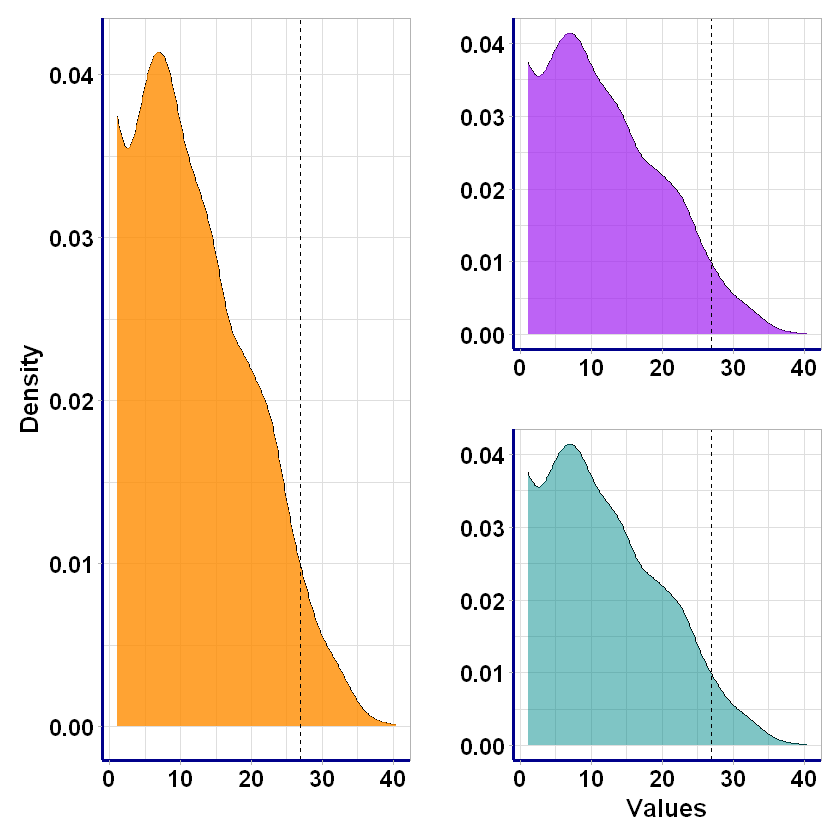

In [429]:
# Ts

# Get the Grade column
col <- Saar_hour %>% 
  select(Ts)

# Compute kernel density estimates
density <- density(pull(col), kernel = "gaussian")

# Create a dataframe containing coordinates where density is estimated
#and the corresponding estimated value
density_xy <- tibble(
  x = density$x,
  y = density$y
)

# Make density plots for various deviations of the mean

plt_sd_1 <- density_xy %>%
  ggplot(mapping = aes(x = x, y = y)) +
  geom_line() +
  geom_area(mapping = aes(x = ifelse(x>(mean_grade-std_dev) & x<(mean_grade+std_dev), x, 0)), fill = "darkorange", alpha = 0.8) +
  annotate("text", x = 50, y = 0.01, label = "1 std (68.26%)", size=5, hjust = 0.1) +
  xlim(1, max(col))+
  geom_vline(xintercept = mean_grade, linetype = "dashed") +
  labs(x = "", y = "Density")+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))


# 2 std deviations from the mean
plt_sd_2 <- density_xy %>%
  ggplot(mapping = aes(x = x, y = y)) +
  geom_line() +
  geom_area(mapping = aes(x = ifelse(x>(mean_grade-(2*std_dev)) & x<(mean_grade+(2*std_dev)), x, 0)), fill = "purple", alpha = 0.7) +
  annotate("text", x = 50, y = 0.01, label = "2 std (95.45%)", size=5, hjust = 0.1) +
  xlim(1, max(col)) +
  geom_vline(xintercept = mean_grade, linetype = "dashed") +
  labs(x = "", y = "")+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))


# 3 std deviations from the mean
plt_sd_3 <- density_xy %>%
  ggplot(aes(x = x, y = y)) +
  geom_line() +
  geom_area(mapping = aes(x = ifelse(x>(mean_grade-(3*std_dev)) & x<(mean_grade+(3*std_dev)), x, 0)), fill = "cyan4", alpha = 0.5) +
  annotate("text", x = 50, y = 0.01, label = "3 std (99.73%)", size=5, hjust = 0.1) +
  xlim(1, max(col)) +
  geom_vline(xintercept = mean_grade, linetype = "dashed") +
  labs(x = "Values", y = "")+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))



# Patching things up
plt_sd_1| (plt_sd_2/plt_sd_3) 



#summary(Saar_hour)


# Get the mean grade
mean_grade <- mean(pull(col))

# Get the standard deviation of grades
std_dev <- sd(pull(col))

# Find proportion that will fall within 1 standard deviation
one_std_dev <- pnorm((mean_grade + std_dev), mean = mean_grade, sd = std_dev) -
  pnorm((mean_grade - std_dev), mean = mean_grade, sd = std_dev)

# Find proportion that will fall within 2 standard deviations
two_std_dev <- pnorm((mean_grade + (2*std_dev)), mean = mean_grade, sd = std_dev) - 
  pnorm((mean_grade - (2*std_dev)), mean = mean_grade, sd = std_dev)

# Find proportion that will fall within 3 standard deviations
three_std_dev <- pnorm((mean_grade + (3*std_dev)), mean = mean_grade, sd = std_dev) - 
  pnorm((mean_grade - (3*std_dev)), mean = mean_grade, sd = std_dev)

glue(
  '
  {format(round(one_std_dev*100, 2), nsmall = 2)}% of grades fall within one standard deviation from the mean.
  {format(round(two_std_dev*100, 2), nsmall = 2)}% of grades fall within one standard deviation from the mean.
  {format(round(three_std_dev*100, 2), nsmall = 2)}% of grades fall within one standard deviation from the mean.
  
  '
)

Warning message:
"Removed 188 rows containing missing values (position_stack)."
Warning message:
"Removed 188 row(s) containing missing values (geom_path)."
Warning message:
"Removed 1 rows containing missing values (geom_text)."
Warning message:
"Removed 1 rows containing missing values (geom_vline)."
Warning message:
"Removed 188 rows containing missing values (position_stack)."
Warning message:
"Removed 188 row(s) containing missing values (geom_path)."
Warning message:
"Removed 1 rows containing missing values (geom_text)."
Warning message:
"Removed 1 rows containing missing values (geom_vline)."
Warning message:
"Removed 188 rows containing missing values (position_stack)."
Warning message:
"Removed 188 row(s) containing missing values (geom_path)."
Warning message:
"Removed 1 rows containing missing values (geom_text)."
Warning message:
"Removed 1 rows containing missing values (geom_vline)."


68.27% of grades fall within one standard deviation from the mean.
95.45% of grades fall within one standard deviation from the mean.
99.73% of grades fall within one standard deviation from the mean.

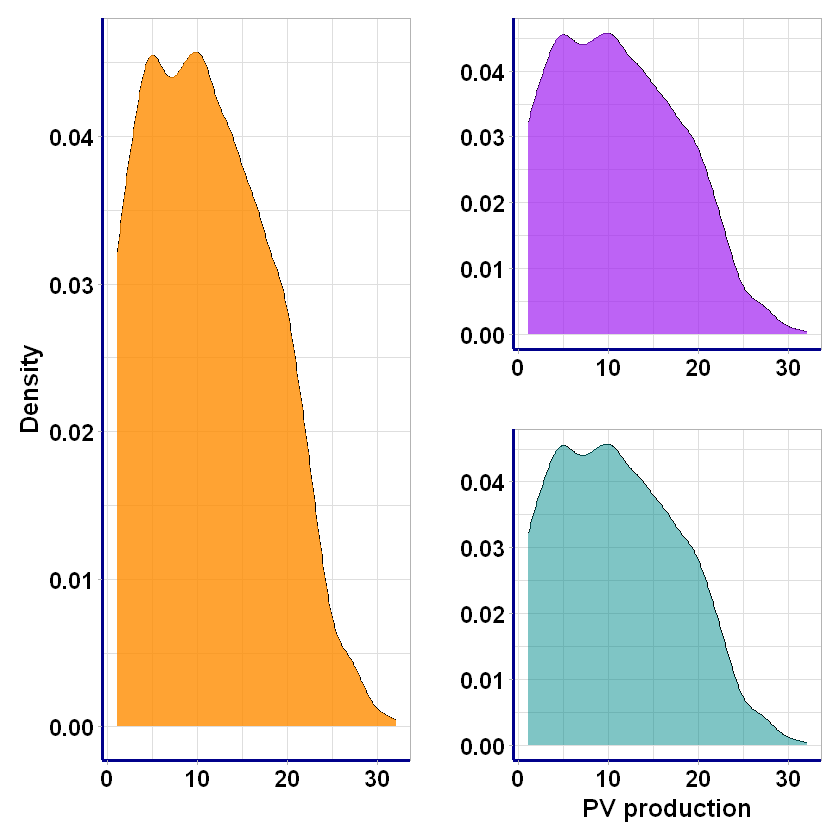

In [425]:
# Ta

# Get the Grade column
col <- Saar_hour %>% 
  select(Ta)

# Compute kernel density estimates
density <- density(pull(col), kernel = "gaussian")

# Create a dataframe containing coordinates where density is estimated
#and the corresponding estimated value
density_xy <- tibble(
  x = density$x,
  y = density$y
)

# Make density plots for various deviations of the mean

plt_sd_1 <- density_xy %>%
  ggplot(mapping = aes(x = x, y = y)) +
  geom_line() +
  geom_area(mapping = aes(x = ifelse(x>(mean_grade-std_dev) & x<(mean_grade+std_dev), x, 0)), fill = "darkorange", alpha = 0.8) +
  annotate("text", x = 50, y = 0.01, label = "1 std (68.26%)", size=5, hjust = 0.1) +
  xlim(1, max(col))+
  geom_vline(xintercept = mean_grade, linetype = "dashed") +
  labs(x = "", y = "Density")+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))


# 2 std deviations from the mean
plt_sd_2 <- density_xy %>%
  ggplot(mapping = aes(x = x, y = y)) +
  geom_line() +
  geom_area(mapping = aes(x = ifelse(x>(mean_grade-(2*std_dev)) & x<(mean_grade+(2*std_dev)), x, 0)), fill = "purple", alpha = 0.7) +
  annotate("text", x = 50, y = 0.01, label = "2 std (95.45%)", size=5, hjust = 0.1) +
  xlim(1, max(col)) +
  geom_vline(xintercept = mean_grade, linetype = "dashed") +
  labs(x = "", y = "")+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))


# 3 std deviations from the mean
plt_sd_3 <- density_xy %>%
  ggplot(aes(x = x, y = y)) +
  geom_line() +
  geom_area(mapping = aes(x = ifelse(x>(mean_grade-(3*std_dev)) & x<(mean_grade+(3*std_dev)), x, 0)), fill = "cyan4", alpha = 0.5) +
  annotate("text", x = 50, y = 0.01, label = "3 std (99.73%)", size=5, hjust = 0.1) +
  xlim(1, max(col)) +
  geom_vline(xintercept = mean_grade, linetype = "dashed") +
  labs(x = "PV production", y = "")+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))



# Patching things up
plt_sd_1| (plt_sd_2/plt_sd_3) 



#summary(Saar_hour)


# Get the mean grade
mean_grade <- mean(pull(col))

# Get the standard deviation of grades
std_dev <- sd(pull(col))

# Find proportion that will fall within 1 standard deviation
one_std_dev <- pnorm((mean_grade + std_dev), mean = mean_grade, sd = std_dev) -
  pnorm((mean_grade - std_dev), mean = mean_grade, sd = std_dev)

# Find proportion that will fall within 2 standard deviations
two_std_dev <- pnorm((mean_grade + (2*std_dev)), mean = mean_grade, sd = std_dev) - 
  pnorm((mean_grade - (2*std_dev)), mean = mean_grade, sd = std_dev)

# Find proportion that will fall within 3 standard deviations
three_std_dev <- pnorm((mean_grade + (3*std_dev)), mean = mean_grade, sd = std_dev) - 
  pnorm((mean_grade - (3*std_dev)), mean = mean_grade, sd = std_dev)

glue(
  '
  {format(round(one_std_dev*100, 2), nsmall = 2)}% of grades fall within one standard deviation from the mean.
  {format(round(two_std_dev*100, 2), nsmall = 2)}% of grades fall within one standard deviation from the mean.
  {format(round(three_std_dev*100, 2), nsmall = 2)}% of grades fall within one standard deviation from the mean.
  
  '
)

In [288]:
df_sample_long <- Saar_hour %>% 
  select(m , G_Gk, Lg, G_Gh, G_Gref, hs, PV) %>%
  #mutate(m = fct_reorder(m, .desc = TRUE)) %>% 
  pivot_longer(!m, names_to = "Metrics", values_to = "Values")

# Show first 10 rows
df_sample_long %>% 
  slice_head(n = 10)

m,Metrics,Values
<int>,<chr>,<dbl>
1,G_Gk,0
1,Lg,0
1,G_Gh,0
1,G_Gref,0
1,hs,0
1,PV,0
1,G_Gk,0
1,Lg,0
1,G_Gh,0


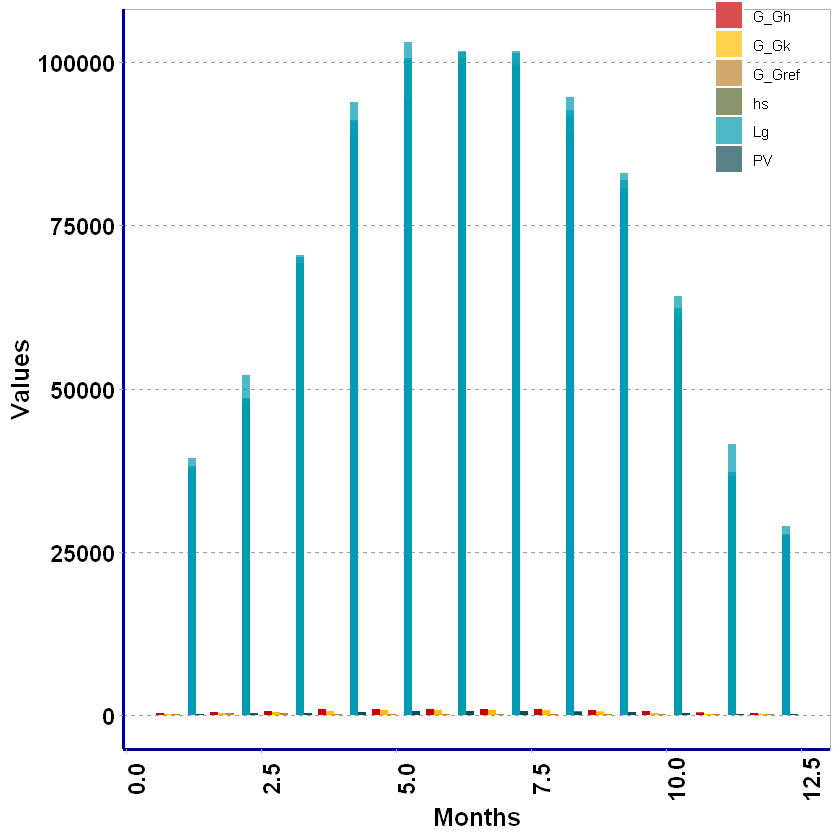

In [294]:
# Try out some color palettes
library(paletteer)

# Compare numeric variables with bar plots
ggplot(data = df_sample_long) +
  geom_bar(mapping = aes(x = m, y = Values, fill = Metrics), alpha = 0.7, stat = "identity", position = position_dodge(width = 0.9)) +
  xlab('Months') +
  ylab('Values') +
  scale_fill_paletteer_d("calecopal::kelp1") +
  theme(
    panel.grid = element_blank(),
    panel.grid.major.y = element_line(color = '#95a5a6',
                                      linetype = 'dashed',
                                      size = 0.5),
    axis.text.x = element_text(angle = 90),
    legend.title = element_blank()

    
  )+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))


In [295]:
# Load the scales package
library(scales)

# Normalize the numeric columns
# group_by ensures that StudyHours and Grade are normalized independently
df_normalized <- df_sample_long %>% 
  group_by(Metrics) %>% 
  mutate(Values = rescale(Values, to = c(0, 1)))

# Show some of the normalized data
df_normalized %>% 
  slice_head(n = 5)


m,Metrics,Values
<int>,<chr>,<dbl>
1,G_Gh,0
1,G_Gh,0
1,G_Gh,0
1,G_Gh,0
1,G_Gh,0
1,G_Gk,0
1,G_Gk,0
1,G_Gk,0
1,G_Gk,0


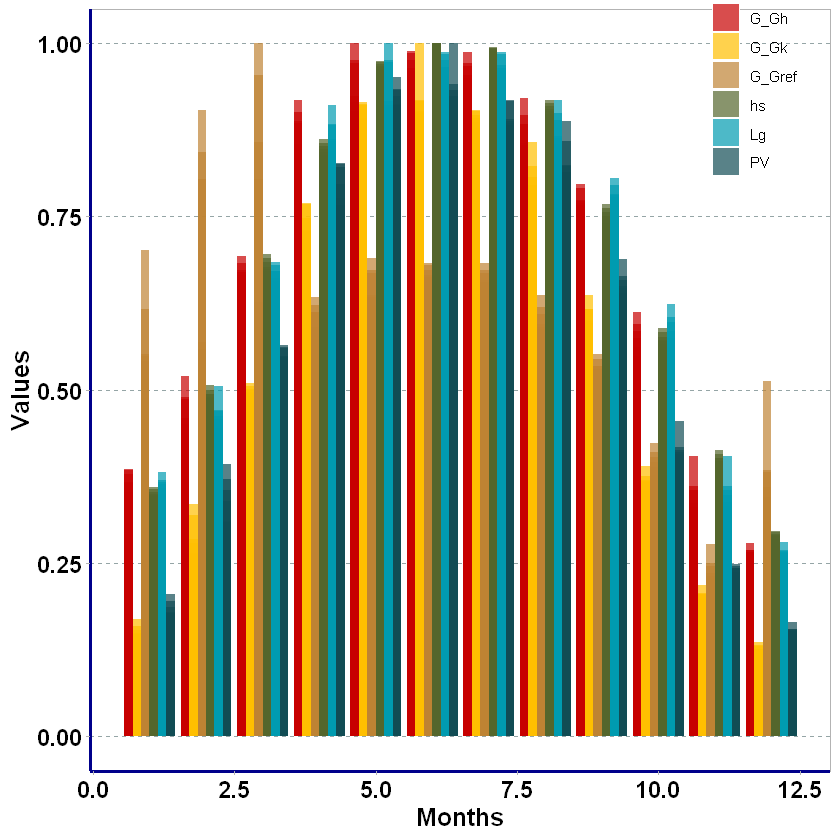

In [395]:
# Compare numeric variables with bar plots
ggplot(data = df_normalized) +
  geom_bar(mapping = aes(x = m, y = Values, fill = Metrics), alpha = 0.7, stat = "identity", position = position_dodge(width = 0.9)) +
  xlab('Months') +
  ylab('Values') +
  scale_fill_paletteer_d("calecopal::kelp1") +
  theme(
    panel.grid = element_blank(),
    panel.grid.major.y = element_line(color = '#95a5a6',
                                      linetype = 'dashed',
                                      size = 0.5),
    axis.text.x = element_text(angle = 0),
    legend.title = element_blank()
    
  )+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))


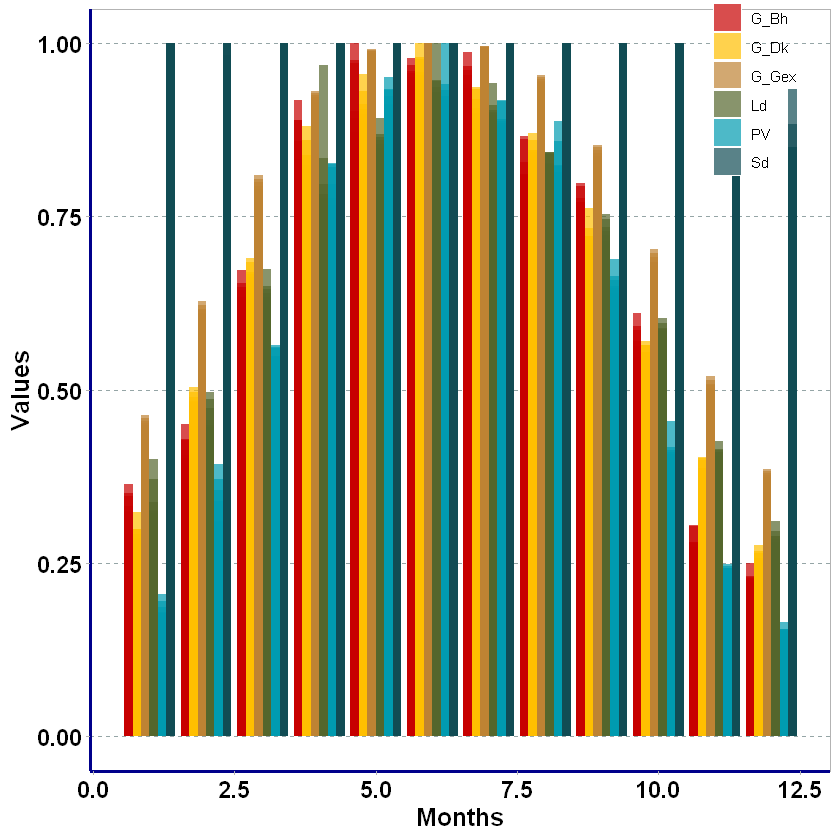

In [396]:
df_sample_long01 <- Saar_hour %>% 
  select(m , G_Gex, G_Bh, Sd, Ld, G_Dk, PV) %>%   #G_Dh, G_Bn, Ts, Ta, PV
  #mutate(m = fct_reorder(m, .desc = TRUE)) %>% 
  pivot_longer(!m, names_to = "Metrics", values_to = "Values")

# Show first 10 rows
#df_sample_long01 %>% 
#  slice_head(n = 10)

# Load the scales package
#library(scales)

# Normalize the numeric columns
# group_by ensures that StudyHours and Grade are normalized independently
df_normalized01 <- df_sample_long01 %>% 
  group_by(Metrics) %>% 
  mutate(Values = rescale(Values, to = c(0, 1)))

# Show some of the normalized data
#df_normalized01 %>% 
#  slice_head(n = 5)

# Compare numeric variables with bar plots
ggplot(data = df_normalized01) +
  geom_bar(mapping = aes(x = m, y = Values, fill = Metrics), alpha = 0.7, stat = "identity", position = position_dodge(width = 0.9)) +
  xlab('Months') +
  ylab('Values') +
  scale_fill_paletteer_d("calecopal::kelp1") +
  theme(
    panel.grid = element_blank(),
    panel.grid.major.y = element_line(color = '#95a5a6',
                                      linetype = 'dashed',
                                      size = 0.5),
    axis.text.x = element_text(angle = 0),
    legend.title = element_blank()
    
  )+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))

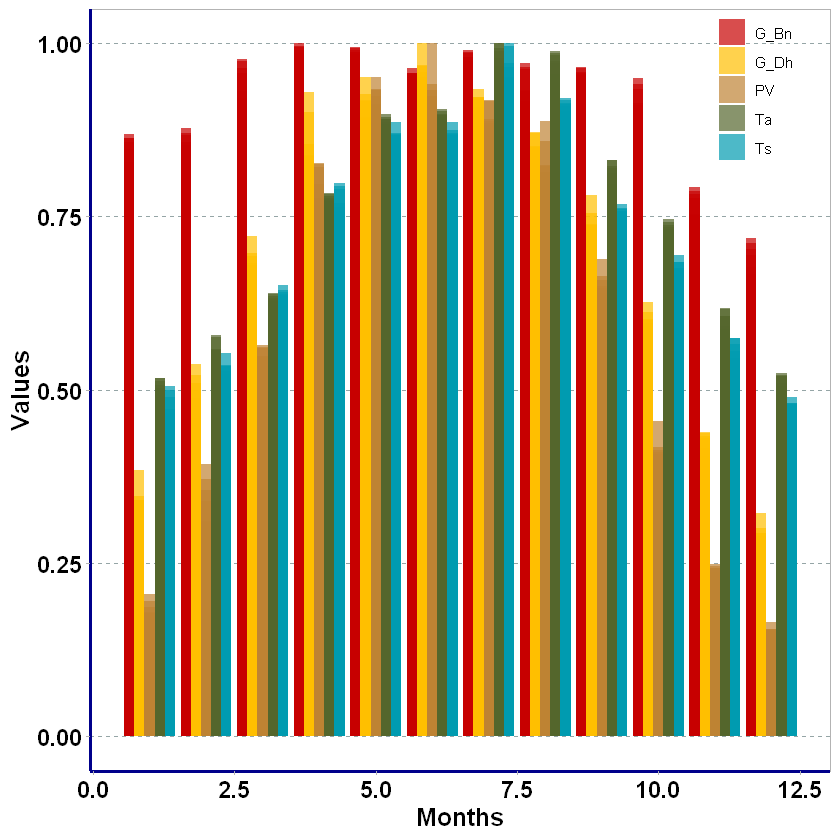

In [397]:
df_sample_long02 <- Saar_hour %>% 
  select(m , G_Dh, G_Bn, Ts, Ta, PV) %>%   #
  #mutate(m = fct_reorder(m, .desc = TRUE)) %>% 
  pivot_longer(!m, names_to = "Metrics", values_to = "Values")

# Show first 10 rows
#df_sample_long01 %>% 
#  slice_head(n = 10)

# Load the scales package
#library(scales)

# Normalize the numeric columns
# group_by ensures that StudyHours and Grade are normalized independently
df_normalized02 <- df_sample_long02 %>% 
  group_by(Metrics) %>% 
  mutate(Values = rescale(Values, to = c(0, 1)))

# Show some of the normalized data
#df_normalized01 %>% 
#  slice_head(n = 5)

# Compare numeric variables with bar plots
ggplot(data = df_normalized02) +
  geom_bar(mapping = aes(x = m, y = Values, fill = Metrics), alpha = 0.7, stat = "identity", position = position_dodge(width = 0.9)) +
  xlab('Months') +
  ylab('Values') +
  scale_fill_paletteer_d("calecopal::kelp1") +
  theme(
    panel.grid = element_blank(),
    panel.grid.major.y = element_line(color = '#95a5a6',
                                      linetype = 'dashed',
                                      size = 0.5),
    axis.text.x = element_text(angle = 0),
    legend.title = element_blank()
    
  )+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))

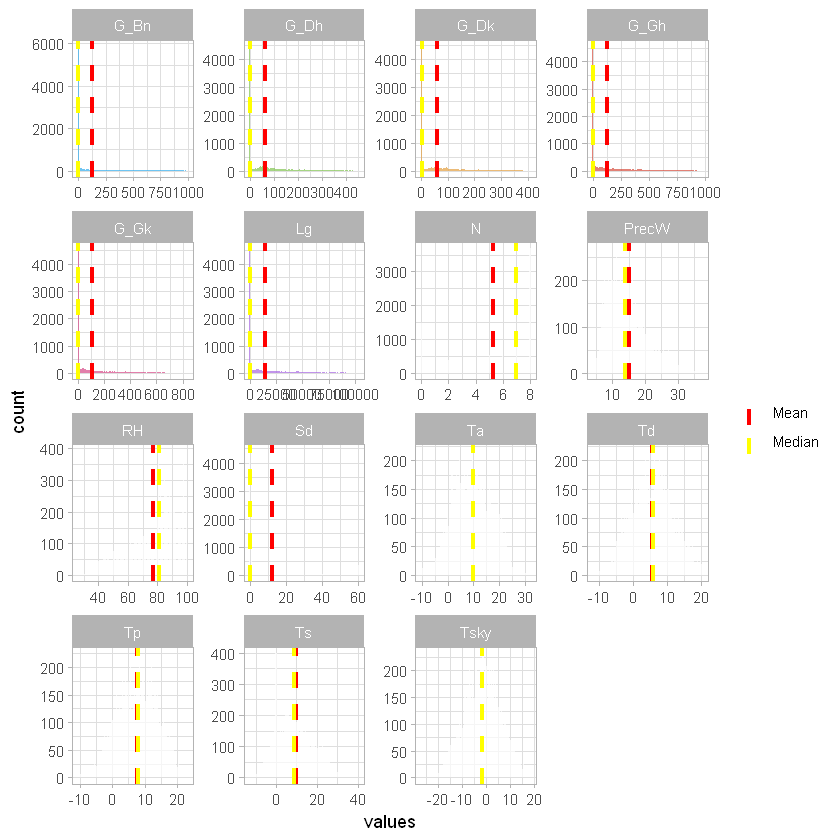

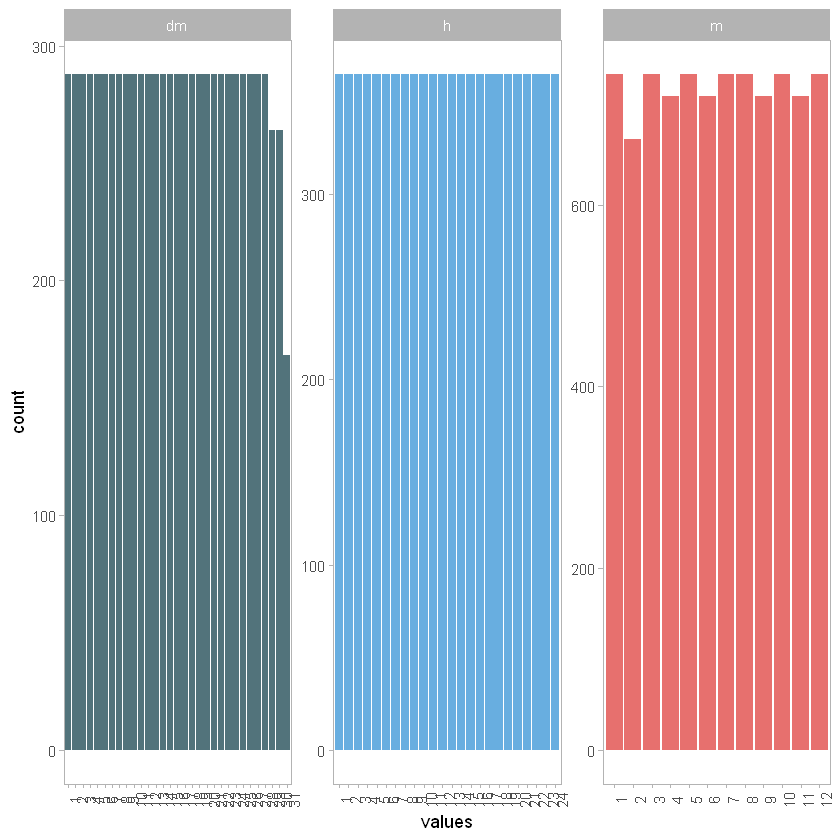

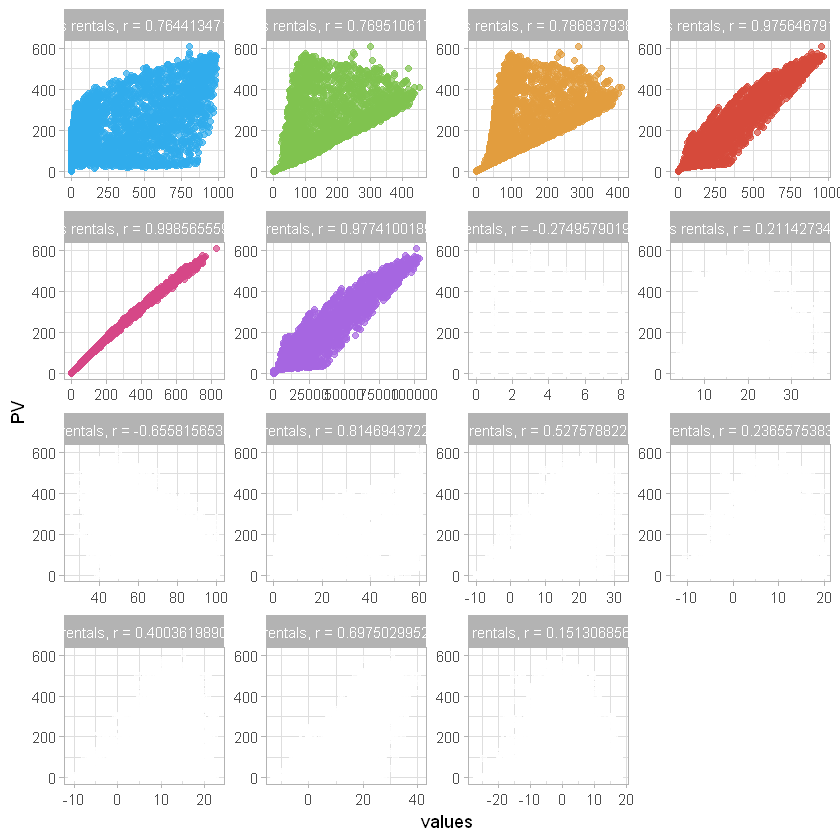

In [301]:
# Create a data frame of categorical features & label
categorical_features <- Saar_hour %>% 
  select(c(m, dm, h, PV))

# Pivot data to a long format
categorical_features <- categorical_features %>% 
  pivot_longer(!PV, names_to = "features", values_to = "values") %>%
  group_by(features) %>% 
  mutate(values = factor(values))


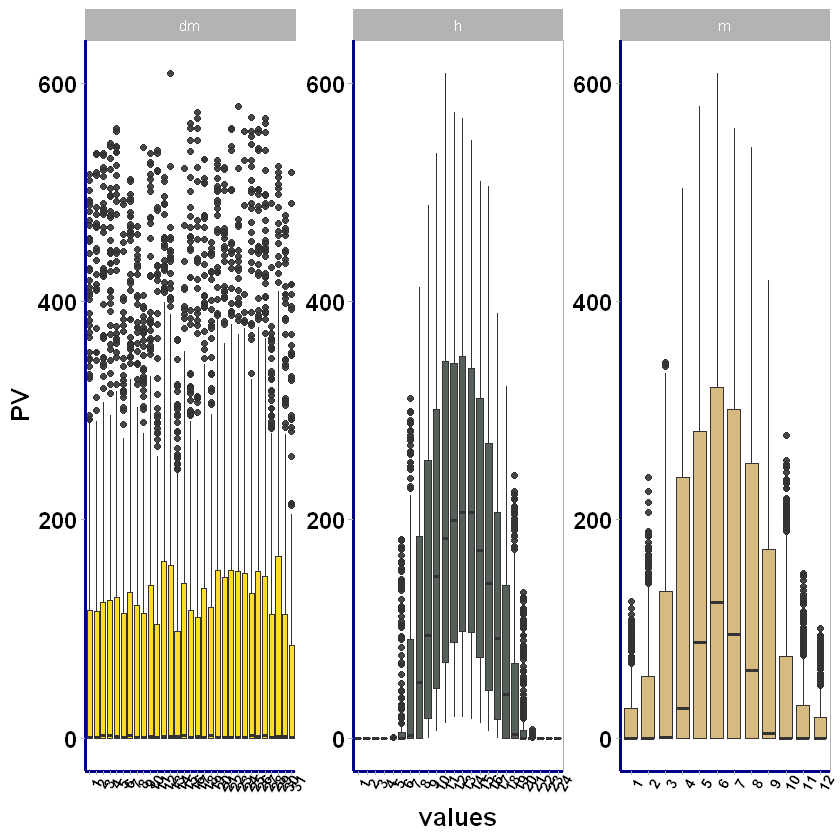

In [311]:
# Plot a box plot for each feature
categorical_features %>%
  ggplot() +
  geom_boxplot(aes(x = values, y = PV, fill = features), alpha = 0.9, show.legend = F) +
  facet_wrap(~ features, scales = 'free') +
  paletteer::scale_fill_paletteer_d("tvthemes::simpsons")+
  theme(
    panel.grid = element_blank(),
    axis.text.x = element_text(angle = 90))+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=9, angle = 60),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))

setwd("C:/Users/Daud/Google Drive/Phd Saarland/Paper by Dd/Phd_Themes/Res.2-Genration modeling (S-01.12.17)/Analysis of weather parameters/T1_RE_P2_Analysis_of_Solar_radiations-Saarbrucken_jan2018_files/New/")
#ggsave("./Pre.png",Final_m_plt)
ggsave(filename = "PV_cat_dis.png", width=15, height=5)
#plt.plot

In [312]:
# Select desired features and labels
Saar_select <- Saar_hour %>% 
  select(c(m, dm, h, G_Gk, Lg, G_Gh, G_Gref, hs, G_Gex, G_Bh, Sd, Ld, G_Dk, G_Dh, G_Bn, Ts, Ta, PV)) %>% 
  # Encode certain features as categorical
  mutate(across(1:3, factor))

# Get a glimpse of your data
glimpse(Saar_select)

Rows: 8,760
Columns: 18
$ m      <fct> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ dm     <fct> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ h      <fct> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, …
$ G_Gk   <int> 0, 0, 0, 0, 0, 0, 0, 0, 1, 14, 28, 40, 48, 43, 32, 17, 2, 0, 0,…
$ Lg     <int> 0, 0, 0, 0, 0, 0, 0, 0, 124, 1687, 3446, 4917, 5921, 5312, 3906…
$ G_Gh   <int> 0, 0, 0, 0, 0, 0, 0, 0, 1, 14, 28, 41, 49, 44, 32, 17, 2, 0, 0,…
$ G_Gref <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 6, 8, 10, 9, 6, 3, 0, 0, 0, 0, 0,…
$ hs     <dbl> 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.9, 12.6, 16.3, 1…
$ G_Gex  <int> 0, 0, 0, 0, 0, 0, 0, 0, 9, 169, 308, 396, 430, 405, 324, 193, 1…
$ G_Bh   <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ Sd     <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, …
$ Ld     <int> 0, 0, 0, 0, 0, 0, 0, 0, 123, 1687, 3446, 4917, 5921, 5312, 3906…
$ G_Dk   <int> 0

In [313]:
# Split 70% of the data for training and the rest for testing
set.seed(2056)
Saar_split <- Saar_select %>% 
  initial_split(prop = 0.7,
  # splitting data evenly on the holiday variable
                strata = m)

# Extract the data in each split
Saar_train <- training(Saar_split)
Saar_test <- testing(Saar_split)


cat("Training Set", nrow(Saar_train), "rows",
    "\nTest Set", nrow(Saar_test), "rows")


Warning message:
"Too little data to stratify.
• Resampling will be unstratified."


Training Set 6132 rows 
Test Set 2628 rows

In [314]:
# Build a linear model specification
lm_spec <- 
  # Type
  linear_reg() %>% 
  # Engine
  set_engine("lm") %>% 
  # Mode
  set_mode("regression")

In [315]:
# Train a linear regression model
lm_mod <- lm_spec %>% 
  fit(PV ~ ., data = Saar_train)

# Print the model object
lm_mod


parsnip model object


Call:
stats::lm(formula = PV ~ ., data = data)

Coefficients:
(Intercept)           m2           m3           m4           m5           m6  
 -0.8940735    0.5771859    2.6202249    4.1001531    4.3920245    3.4268430  
         m7           m8           m9          m10          m11          m12  
  3.9068180    3.9223581    4.5362605    3.2061253    1.3551970   -0.0447771  
        dm2          dm3          dm4          dm5          dm6          dm7  
 -0.0008075    0.2490136   -0.4041655    0.1304055    0.6885777   -0.4874961  
        dm8          dm9         dm10         dm11         dm12         dm13  
  0.6430994    0.6750916    0.0147784    0.8669367    0.8363370    0.2102749  
       dm14         dm15         dm16         dm17         dm18         dm19  
  0.7807903    0.6605024    0.7122450    1.2281179    1.2893233    1.0168588  
       dm20         dm21         dm22         dm23         dm24         dm25  
  0.7460754    0.5083953    1.1991039    0.536

In [316]:
# Make predictions on test set
pred <- lm_mod %>% 
  predict(new_data = Saar_test)

# View predictions
pred %>% 
  slice_head(n = 5)

.pred
<dbl>
-2.699293
-3.085693
-2.953269
25.130475
37.611199


In [317]:
# Predict rentals for the test set and bind it to the test_set
results <- Saar_test %>% 
  bind_cols(lm_mod %>% 
    # Predict rentals
    predict(new_data = Saar_test) %>% 
      rename(predictions = .pred))

# Compare predictions
results %>% 
  select(c(PV, predictions)) %>% 
  slice_head(n = 10)


PV,predictions
<int>,<dbl>
0,-2.699293
0,-3.085693
0,-2.953269
25,25.130475
35,37.611199
0,-4.207108
0,-1.679872
0,-2.109758
0,-1.971613


`geom_smooth()` using formula 'y ~ x'



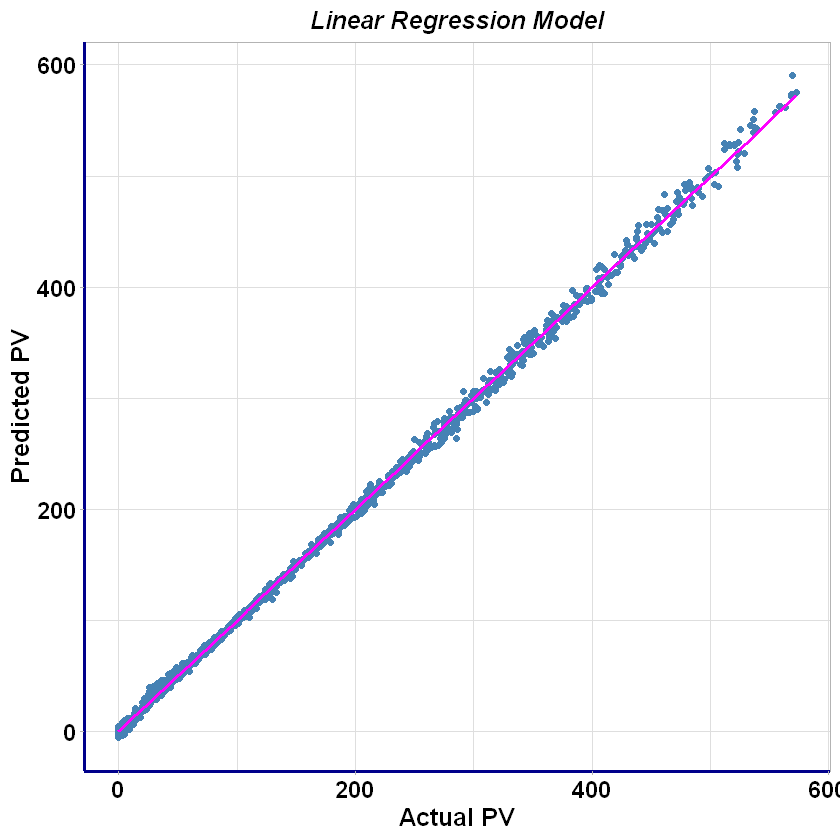

In [322]:
# Visualise the results
results %>% 
  ggplot(mapping = aes(x = PV, y = predictions)) +
  geom_point(size = 1.6, color = "steelblue") +
  # Overlay a regression line
  geom_smooth(method = "lm", se = F, color = 'magenta') +
  ggtitle("Linear Regression Model") +
  xlab("Actual PV") +
  ylab("Predicted PV") +
  theme(plot.title = element_text(hjust = 0.5))+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="black", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14, angle = 0),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))


In [320]:
# Multiple regression metrics
eval_metrics <- metric_set(rmse, rsq)

# Evaluate RMSE, R2 based on the results
eval_metrics(data = results,
             truth = PV,
             estimate = predictions)


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,3.6687469
rsq,standard,0.9992511


`geom_smooth()` using formula 'y ~ x'



[[1]]
# A tibble: 2 × 3
  .metric .estimator .estimate
  <chr>   <chr>          <dbl>
1 rmse    standard       5.87 
2 rsq     standard       0.998

[[2]]


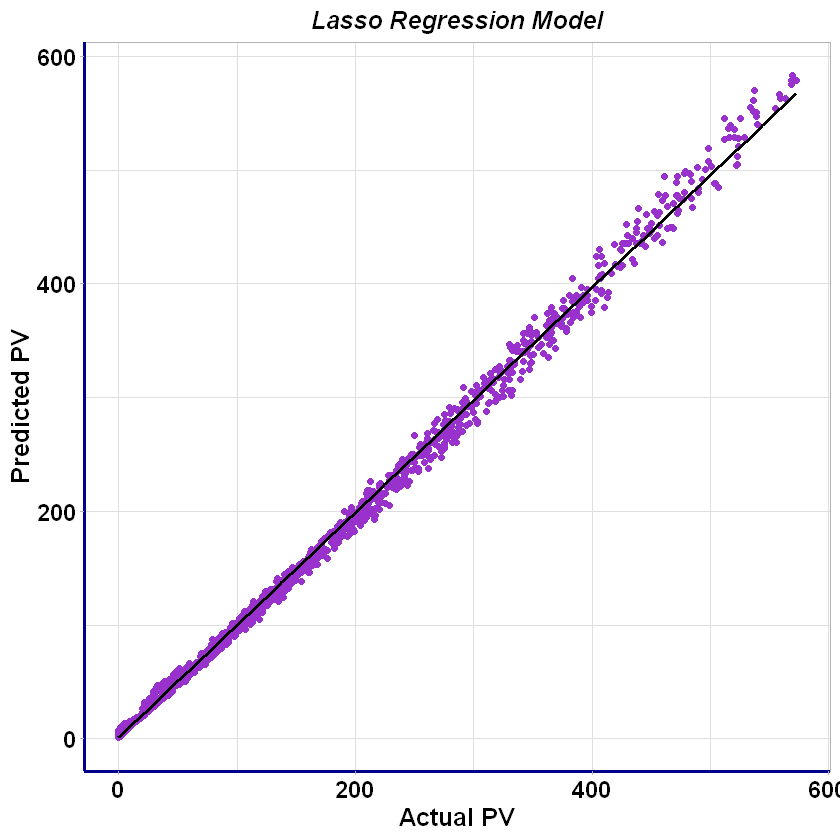

In [323]:
# Build a lasso model specification
lasso_spec <- linear_reg(
  engine = "glmnet",
  mode = "regression",
  penalty = 1,
  mixture = 1)

# Train a lasso regression model
lasso_mod <- lasso_spec %>% 
  fit(PV ~ ., data = Saar_train)

# Make predictions for test data
results_lasso <- Saar_test %>% 
  bind_cols(lasso_mod %>% predict(new_data = Saar_test) %>% 
              rename(predictions = .pred))

# Evaluate the model
lasso_metrics <- eval_metrics(data = results_lasso,
                                    truth = PV,
                                    estimate = predictions) 


# Plot predicted vs actual
theme_set(theme_light())
lasso_plt <- results_lasso %>% 
  ggplot(mapping = aes(x = PV, y = predictions)) +
  geom_point(size = 1.6, color = 'darkorchid') +
  # overlay regression line
  geom_smooth(method = 'lm', color = 'black', se = F) +
  ggtitle("Lasso Regression Model") +
  xlab("Actual PV") +
  ylab("Predicted PV") +
  theme(plot.title = element_text(hjust = 0.5))+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="black", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14, angle = 0),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))

# Return evaluations
list(lasso_metrics, lasso_plt)
  

parsnip model object

n= 6132 

node), split, n, deviance, yval
      * denotes terminal node

 1) root 6132 107739800.0  85.242660  
   2) G_Gk< 202.5 4881   9765720.0  25.735300  
     4) G_Gk< 64.5 3926    694455.4   5.709373 *
     5) G_Gk>=64.5 955   1024135.0 108.061800 *
   3) G_Gk>=202.5 1251  13252350.0 317.421300  
     6) G_Gk< 431.5 792   1895625.0 250.054300  
      12) G_Gk< 304.5 405    219791.1 208.851900 *
      13) G_Gk>=304.5 387    268765.4 293.173100 *
     7) G_Gk>=431.5 459   1560389.0 433.662300  
      14) G_Gk< 557.5 242    171106.5 387.487600 *
      15) G_Gk>=557.5 217    297900.7 485.156700 *

`geom_smooth()` using formula 'y ~ x'



[[1]]
# A tibble: 2 × 3
  .metric .estimator .estimate
  <chr>   <chr>          <dbl>
1 rmse    standard      20.9  
2 rsq     standard       0.976

[[2]]


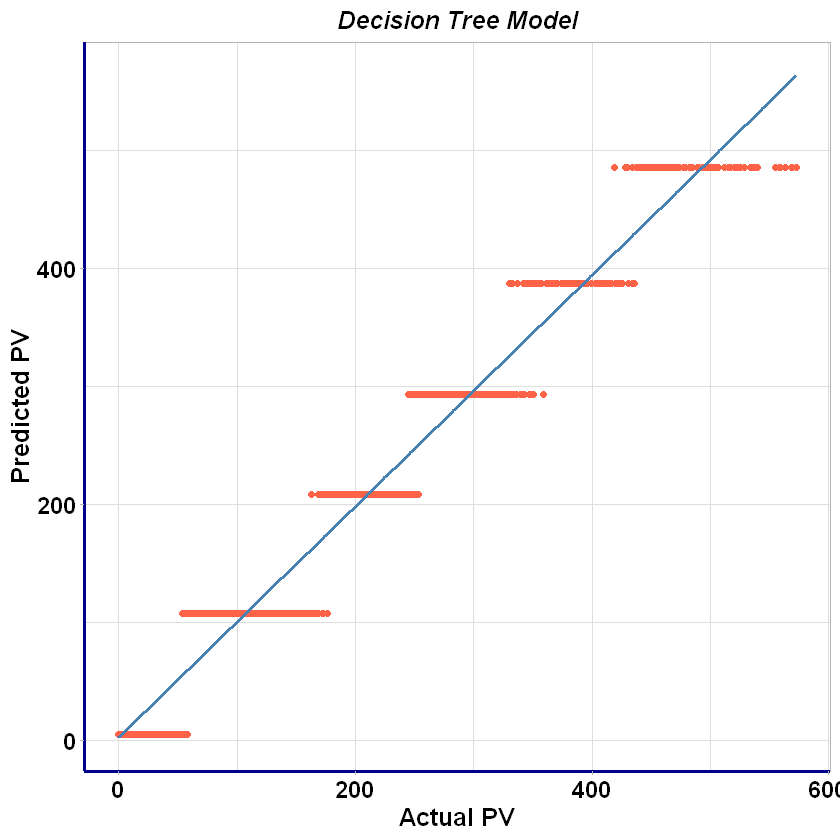

In [324]:
# Build a decision tree specification
tree_spec <- decision_tree(
  engine = "rpart",
  mode = "regression")

# Train a decision tree model 
tree_mod <- tree_spec %>% 
  fit(PV ~ ., data = Saar_train)

# Print model
tree_mod

# Make and bind predictions to test data a
results_DT <- tree_mod %>% 
  augment(new_data = Saar_test) %>% 
  rename(predictions = .pred)

# Evaluate the model
tree_metrics <- eval_metrics(data = results_DT,
                                  truth = PV,
                                  estimate = predictions)

# Plot predicted vs actual
tree_plt <- results_DT %>% 
  ggplot(mapping = aes(x = PV, y = predictions)) +
  geom_point(color = 'tomato') +
  # overlay regression line
  geom_smooth(method = 'lm', color = 'steelblue', se = F) +
  ggtitle("Decision Tree Model") +
  xlab("Actual PV") +
  ylab("Predicted PV") +
  theme(plot.title = element_text(hjust = 0.5))+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="black", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14, angle = 0),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))
# Return evaluations
list(tree_metrics, tree_plt)

parsnip model object


Call:
 randomForest(x = maybe_data_frame(x), y = y) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 5

          Mean of squared residuals: 20.26257
                    % Var explained: 99.88

`geom_smooth()` using formula 'y ~ x'



[[1]]
# A tibble: 2 × 3
  .metric .estimator .estimate
  <chr>   <chr>          <dbl>
1 rmse    standard       4.52 
2 rsq     standard       0.999

[[2]]


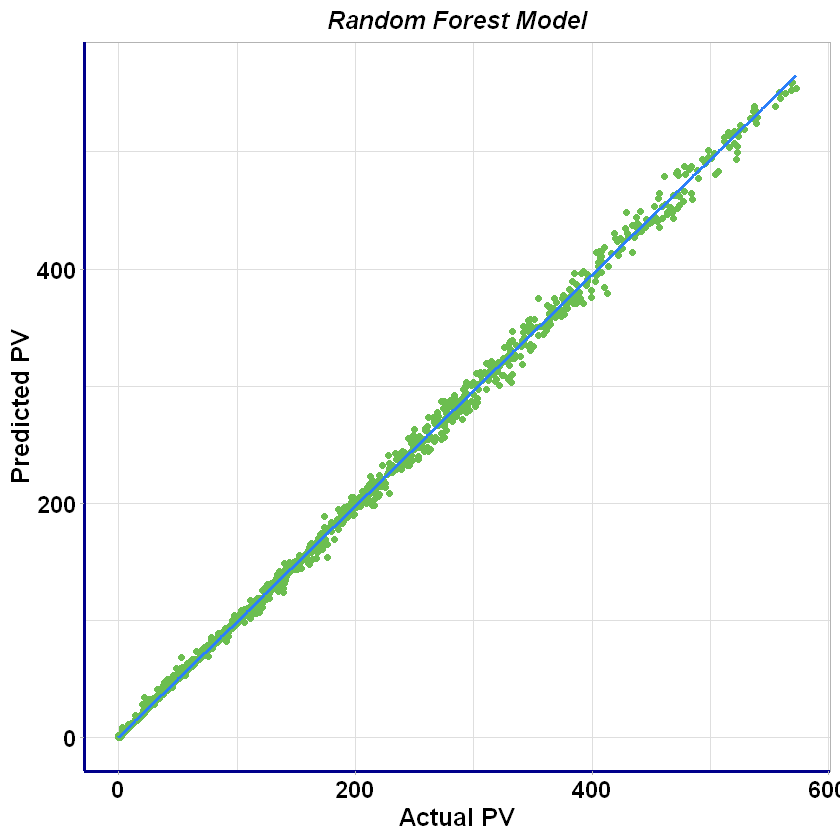

In [325]:
# For reproducibility
set.seed(2056)

# Build a random forest model specification
rf_spec <- rand_forest() %>% 
  set_engine('randomForest') %>% 
  set_mode('regression')

# Train a random forest model 
rf_mod <- rf_spec %>% 
  fit(PV ~ ., data = Saar_train)

# Print model
rf_mod


# Make and bind predictions to test data a
results_RF <- rf_mod %>% 
  augment(new_data = Saar_test) %>% 
  rename(predictions = .pred)


# Evaluate the model
rf_metrics <- eval_metrics(data = results_RF,
                                  truth = PV,
                                  estimate = predictions)


# Plot predicted vs actual
rf_plt <- results_RF %>% 
  ggplot(mapping = aes(x = PV, y = predictions)) +
  geom_point(color = '#6CBE50FF') +
  # overlay regression line
  geom_smooth(method = 'lm', color = '#2B7FF9FF', se = F) +
  ggtitle("Random Forest Model") +
  xlab("Actual PV") +
  ylab("Predicted PV") +
  theme(plot.title = element_text(hjust = 0.5))+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="black", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14, angle = 0),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))

# Return evaluations
list(rf_metrics, rf_plt)


parsnip model object

##### xgb.Booster
raw: 54.5 Kb 
call:
  xgboost::xgb.train(params = list(eta = 0.3, max_depth = 6, gamma = 0, 
    colsample_bytree = 1, colsample_bynode = 1, min_child_weight = 1, 
    subsample = 1), data = x$data, nrounds = 15, watchlist = x$watchlist, 
    verbose = 0, nthread = 1, objective = "reg:squarederror")
params (as set within xgb.train):
  eta = "0.3", max_depth = "6", gamma = "0", colsample_bytree = "1", colsample_bynode = "1", min_child_weight = "1", subsample = "1", nthread = "1", objective = "reg:squarederror", validate_parameters = "TRUE"
xgb.attributes:
  niter
callbacks:
  cb.evaluation.log()
# of features: 81 
niter: 15
nfeatures : 81 
evaluation_log:
    iter training_rmse
       1    110.607027
       2     77.768563
---                   
      14      1.920487
      15      1.646381

`geom_smooth()` using formula 'y ~ x'



[[1]]
# A tibble: 2 × 3
  .metric .estimator .estimate
  <chr>   <chr>          <dbl>
1 rmse    standard        2.26
2 rsq     standard        1.00

[[2]]


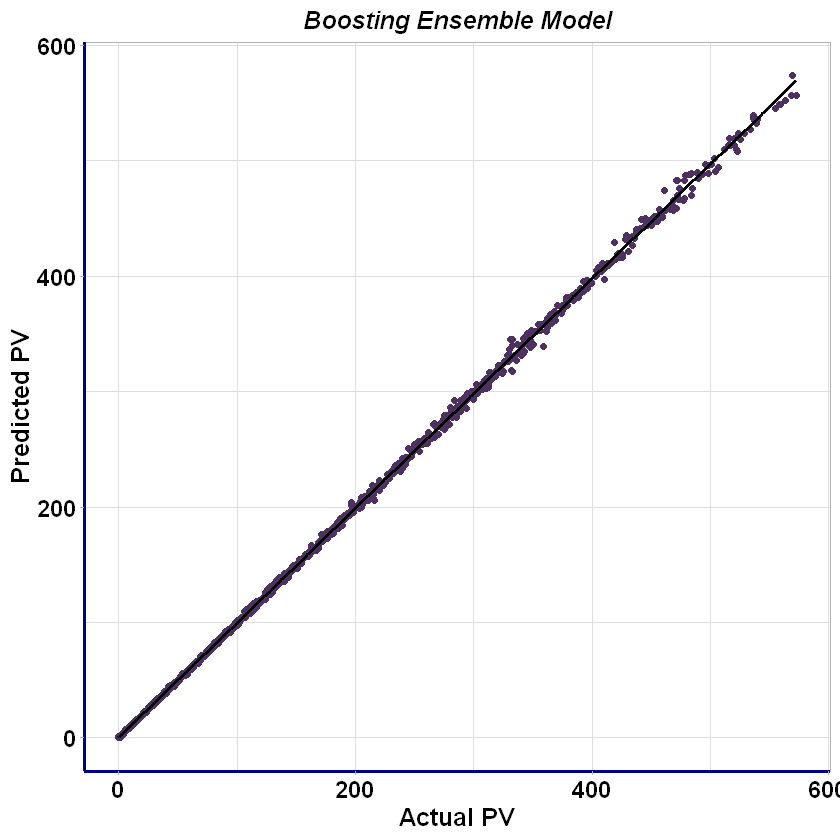

In [326]:
# For reproducibility
set.seed(2056)

# Build an xgboost model specification
boost_spec <- boost_tree() %>% 
  set_engine('xgboost') %>% 
  set_mode('regression')

# Train an xgboost model 
boost_mod <- boost_spec %>% 
  fit(PV ~ ., data = Saar_train)


# Print model
boost_mod


# Make and bind predictions to test data a
results_BT <- boost_mod %>% 
  augment(new_data = Saar_test) %>% 
  rename(predictions = .pred)

# Evaluate the model
boost_metrics <- eval_metrics(data = results_BT,
                                  truth = PV,
                                  estimate = predictions) 

# Plot predicted vs actual
boost_plt <- results_BT %>% 
  ggplot(mapping = aes(x = PV, y = predictions)) +
  geom_point(color = '#4D3161FF') +
  # overlay regression line
  geom_smooth(method = 'lm', color = 'black', se = F) +
  ggtitle("Boosting Ensemble Model") +
  xlab("Actual PV") +
  ylab("Predicted PV") +
  theme(plot.title = element_text(hjust = 0.5))+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="black", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14, angle = 0),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))
# Return evaluations
list(boost_metrics, boost_plt)

In [327]:
# Specify a recipe
Saar_recipe <- recipe(PV ~ ., data = Saar_train) %>% 
  step_normalize(all_numeric_predictors()) %>% 
  step_dummy(all_nominal_predictors()) 

# Print out recipe
Saar_recipe


# Summary of the recipe
summary(Saar_recipe)

Recipe

Inputs:

      role #variables
   outcome          1
 predictor         17

Operations:

Centering and scaling for all_numeric_predictors()
Dummy variables from all_nominal_predictors()

variable,type,role,source
<chr>,<chr>,<chr>,<chr>
m,nominal,predictor,original
dm,nominal,predictor,original
h,nominal,predictor,original
G_Gk,numeric,predictor,original
Lg,numeric,predictor,original
G_Gh,numeric,predictor,original
G_Gref,numeric,predictor,original
hs,numeric,predictor,original
G_Gex,numeric,predictor,original


In [328]:
# xgboost specification
boost_spec <- boost_tree() %>% 
  set_engine('xgboost') %>% 
  set_mode('regression')

# Create the workflow
boost_workflow <- workflow() %>% 
  add_recipe(Saar_recipe) %>% 
  add_model(boost_spec)

# Print out workflow
boost_workflow


══ Workflow ════════════════════════════════════════════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: boost_tree()

── Preprocessor ────────────────────────────────────────────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_normalize()
• step_dummy()

── Model ───────────────────────────────────────────────────────────────────────────────────────────────────────────────
Boosted Tree Model Specification (regression)

Computational engine: xgboost 


In [329]:
# Train the model
boost_workflow <- boost_workflow %>% 
  fit(data = Saar_train)

boost_workflow

boost_workflow %>% 
  predict(new_data = Saar_test %>% dplyr::slice(1:6))



══ Workflow [trained] ══════════════════════════════════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: boost_tree()

── Preprocessor ────────────────────────────────────────────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_normalize()
• step_dummy()

── Model ───────────────────────────────────────────────────────────────────────────────────────────────────────────────
##### xgb.Booster
raw: 54.5 Kb 
call:
  xgboost::xgb.train(params = list(eta = 0.3, max_depth = 6, gamma = 0, 
    colsample_bytree = 1, colsample_bynode = 1, min_child_weight = 1, 
    subsample = 1), data = x$data, nrounds = 15, watchlist = x$watchlist, 
    verbose = 0, nthread = 1, objective = "reg:squarederror")
params (as set within xgb.train):
  eta = "0.3", max_depth = "6", gamma = "0", colsample_bytree = "1", colsample_bynode = "1", min_child_weight = "1", subsample = "1", nthread = "1", objective = "reg:squarederror", validate_p

.pred
<dbl>
0.002852751
0.002852751
0.002852751
25.591062546
35.289718628
0.002852751


In [330]:
args(boost_tree)

function (mode = "unknown", engine = "xgboost", mtry = NULL, 
    trees = NULL, min_n = NULL, tree_depth = NULL, learn_rate = NULL, 
    loss_reduction = NULL, sample_size = NULL, stop_iter = NULL) 
NULL

In [331]:
# Specify a recipe
Saar_recipe <- recipe(PV ~ ., data = Saar_train) %>% 
  step_normalize(all_numeric_predictors()) %>% 
  step_dummy(all_nominal_predictors()) 


# Make a tunable model specification
boost_spec <- boost_tree(trees = 50,
                         tree_depth = tune(),
                         learn_rate = tune()) %>% 
  set_engine('xgboost') %>% 
  set_mode('regression')


# Bundle a recipe and model spec using a workflow
boost_workflow <- workflow() %>% 
  add_recipe(Saar_recipe) %>% 
  add_model(boost_spec)

# Print workflow
boost_workflow



══ Workflow ════════════════════════════════════════════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: boost_tree()

── Preprocessor ────────────────────────────────────────────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_normalize()
• step_dummy()

── Model ───────────────────────────────────────────────────────────────────────────────────────────────────────────────
Boosted Tree Model Specification (regression)

Main Arguments:
  trees = 50
  tree_depth = tune()
  learn_rate = tune()

Computational engine: xgboost 


tree_depth,learn_rate
<int>,<dbl>
1,0.0100
4,0.0100
8,0.0100
11,0.0100
15,0.0100
1,0.0825
4,0.0825
8,0.0825
11,0.0825


tree_depth,learn_rate,.metric,.estimator,mean,n,std_err,.config
<int>,<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
8,0.1550,rmse,standard,1.530959,5,0.1841332,Preprocessor1_Model13
11,0.1550,rmse,standard,1.547182,5,0.1824617,Preprocessor1_Model14
15,0.1550,rmse,standard,1.556148,5,0.1862034,Preprocessor1_Model15
4,0.1550,rmse,standard,1.607901,5,0.1410604,Preprocessor1_Model12
8,0.2275,rmse,standard,1.657188,5,0.1511982,Preprocessor1_Model18


tree_depth,learn_rate,.config
<int>,<dbl>,<chr>
8,0.155,Preprocessor1_Model13


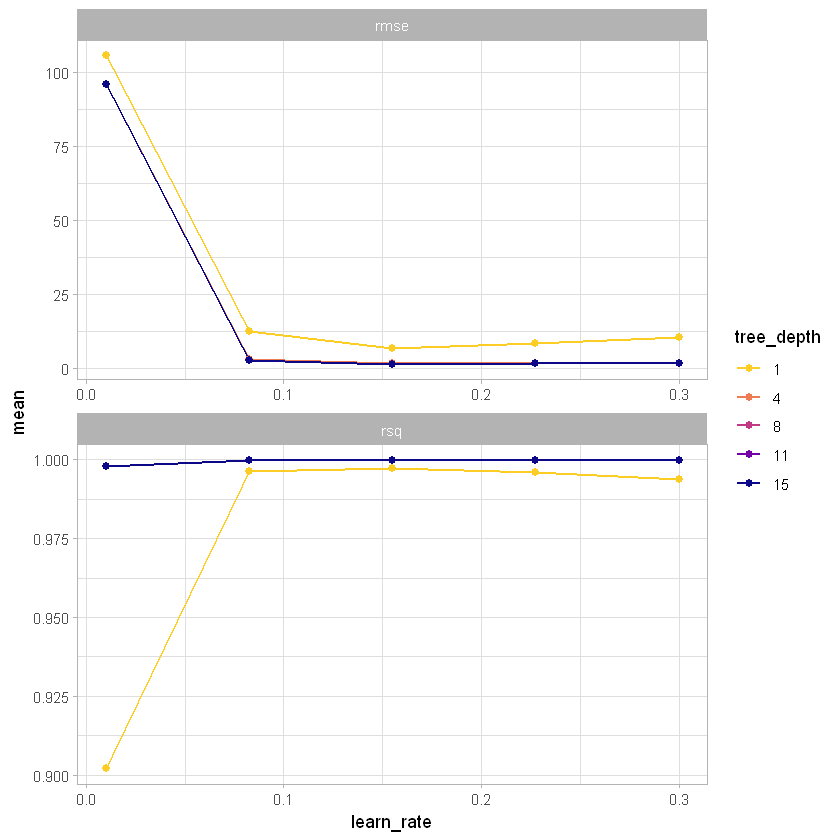

In [332]:
# Create a grid of tuning parameters
tree_grid <- grid_regular(tree_depth(),
                  # You can specify hyperparameter ranges too
learn_rate(range = c(0.01, 0.3), trans = NULL), levels = 5)

# Display hyperparameter combinations that will be used for tuning
tree_grid

set.seed(2056)
# 5 fold CV repeated once
Saar_folds <- vfold_cv(data = Saar_train, v = 5, repeats = 1)


# Allow parallel processing
doParallel::registerDoParallel()

# Model tuning via grid search
set.seed(2020)
tree_grid <- tune_grid(
  object = boost_workflow,
  resamples = Saar_folds,
  grid = tree_grid
)


# Visualize the results
tree_grid %>% 
  collect_metrics() %>% 
  mutate(tree_depth = factor(tree_depth)) %>% 
  ggplot(mapping = aes(x = learn_rate, y = mean,
                       color = tree_depth)) +
  geom_line(size = 0.6) +
  geom_point(size = 2) +
  facet_wrap(~ .metric, scales = 'free', nrow = 2)+
  scale_color_viridis_d(option = "plasma", begin = .9, end = 0)


tree_grid %>% 
  show_best('rmse')

# Select the tree with the best RMSE
best_tree <- tree_grid %>% 
  select_best('rmse')

# Display best tree
best_tree


In [337]:
# Update workflow
final_wf <- boost_workflow %>% 
  finalize_workflow(best_tree)

# Print final workflow
final_wf

# Make a last fit
final_fit <- final_wf %>% 
  last_fit(Saar_split)


# Collect metrics
final_fit %>% 
  collect_metrics()

══ Workflow ════════════════════════════════════════════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: boost_tree()

── Preprocessor ────────────────────────────────────────────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_normalize()
• step_dummy()

── Model ───────────────────────────────────────────────────────────────────────────────────────────────────────────────
Boosted Tree Model Specification (regression)

Main Arguments:
  trees = 50
  tree_depth = 8
  learn_rate = 0.155

Computational engine: xgboost 


.metric,.estimator,.estimate,.config
<chr>,<chr>,<dbl>,<chr>
rmse,standard,1.3363217,Preprocessor1_Model1
rsq,standard,0.9999014,Preprocessor1_Model1


In [338]:
# Extract trained workflow
Saar_boost_model <- final_fit$.workflow[[1]]

# Save trained workflow
saveRDS(Saar_boost_model, 'Saar_boost_model.rds')

# Load the model
loaded_model <- readRDS("Saar_boost_model.rds")

# Extract predictors
bike_new <- Saar_test %>% 
  dplyr::slice(5:9)

# Use the model to predict rentals
results_FN <- loaded_model %>% 
  augment(Saar_test)

# See model predictions 
results_FN

m,dm,h,G_Gk,Lg,G_Gh,G_Gref,hs,G_Gex,G_Bh,Sd,Ld,G_Dk,G_Dh,G_Bn,Ts,Ta,PV,.pred
<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>
1,1,1,0,0,0,0,0.0,0,0,0,0,0,0,0,3.5,6.2,0,0.003549768
1,1,3,0,0,0,0,0.0,0,0,0,0,0,0,0,3.3,6.6,0,0.003549768
1,1,8,0,0,0,0,0.0,0,0,0,0,0,0,0,3.5,6.0,0,0.003549768
1,1,11,28,3446,28,6,12.6,308,0,0,3446,28,28,0,6.2,6.4,25,25.609237671
1,1,12,40,4917,41,8,16.3,396,0,1,4917,40,41,0,6.5,6.7,35,35.328384399
1,1,18,0,0,0,0,0.0,0,0,0,0,0,0,0,4.3,6.2,0,0.004283639
1,1,22,0,0,0,0,0.0,0,0,0,0,0,0,0,2.7,5.4,0,0.003549768
1,1,24,0,0,0,0,0.0,0,0,0,0,0,0,0,2.0,5.1,0,0.003549768
1,2,7,0,0,0,0,0.0,0,0,0,0,0,0,0,1.8,3.5,0,0.003549768


In [339]:
# Replace negatives in column StudyHours with the mean study hours
results_FN <- results_FN %>%
  mutate(predictions = replace(.pred, .pred < 0, 0))
# Print the data frame
results_FN


m,dm,h,G_Gk,Lg,G_Gh,G_Gref,hs,G_Gex,G_Bh,Sd,Ld,G_Dk,G_Dh,G_Bn,Ts,Ta,PV,.pred,predictions
<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
1,1,1,0,0,0,0,0.0,0,0,0,0,0,0,0,3.5,6.2,0,0.003549768,0.003549768
1,1,3,0,0,0,0,0.0,0,0,0,0,0,0,0,3.3,6.6,0,0.003549768,0.003549768
1,1,8,0,0,0,0,0.0,0,0,0,0,0,0,0,3.5,6.0,0,0.003549768,0.003549768
1,1,11,28,3446,28,6,12.6,308,0,0,3446,28,28,0,6.2,6.4,25,25.609237671,25.609237671
1,1,12,40,4917,41,8,16.3,396,0,1,4917,40,41,0,6.5,6.7,35,35.328384399,35.328384399
1,1,18,0,0,0,0,0.0,0,0,0,0,0,0,0,4.3,6.2,0,0.004283639,0.004283639
1,1,22,0,0,0,0,0.0,0,0,0,0,0,0,0,2.7,5.4,0,0.003549768,0.003549768
1,1,24,0,0,0,0,0.0,0,0,0,0,0,0,0,2.0,5.1,0,0.003549768,0.003549768
1,2,7,0,0,0,0,0.0,0,0,0,0,0,0,0,1.8,3.5,0,0.003549768,0.003549768


[[1]]


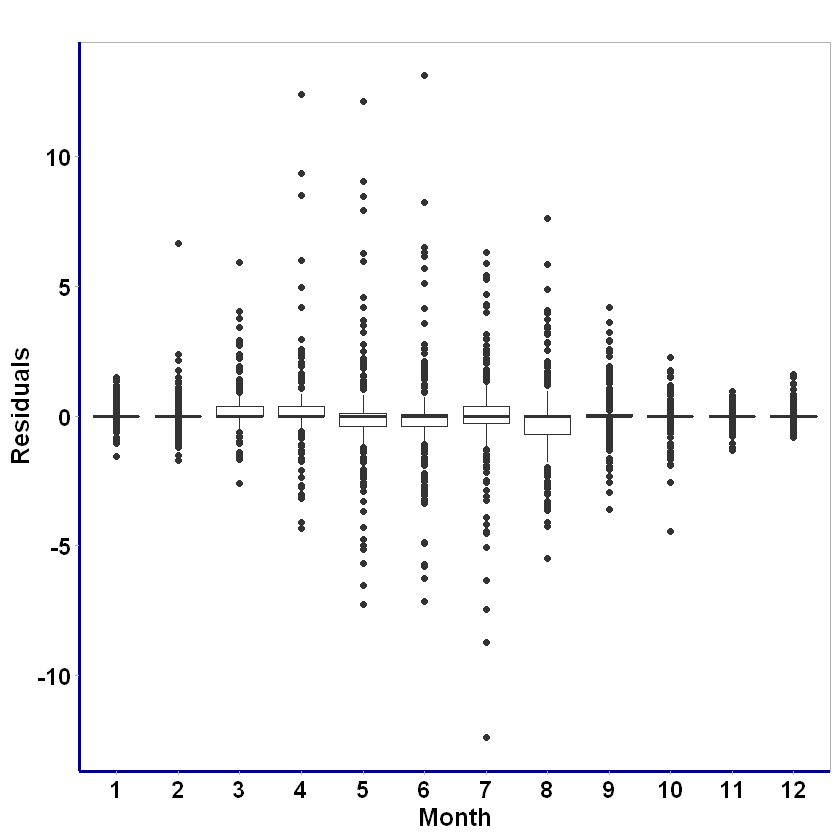

In [431]:

theme_set(theme_light())
Final_mplt <- results_FN %>% 
  select(c(m, PV , predictions)) %>% 

ggplot(mapping = aes(x = m, y = PV-predictions)) +
  geom_boxplot()+
  #, alpha = 0.9, show.legend = F) +
  #facet_wrap(~ h, scales = 'free') +
  # overlay regression line
  ggtitle("") +
  xlab("Month") +
  ylab("Residuals") +
  paletteer::scale_fill_paletteer_d("tvthemes::simpsons")+
  theme(
    panel.grid = element_blank(),
    axis.text.x = element_text(angle = 60))+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="black", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14, angle = 0),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))

 #ggplot(mapping = aes(x = PV, y = predictions)) +
 # geom_point(color = '#4D3161FF') +
 # # overlay regression line
 # geom_smooth(method = 'lm', color = 'black', se = F) +
 # ggtitle("Daily Bike Share Predictions") +
 # xlab("Actual Labels") +
 # ylab("Predicted Labels") +
 # theme(plot.title = element_text(hjust = 0.5))
setwd("C:/Users/Daud/Google Drive/Phd Saarland/Paper by Dd/Phd_Themes/Res.2-Genration modeling (S-01.12.17)/Analysis of weather parameters/T1_RE_P2_Analysis_of_Solar_radiations-Saarbrucken_jan2018_files/New/")
#ggsave("./Pre.png",Final_m_plt)
ggsave(filename = "MonRes.png", width=10, height=5)
#plt.plot

list(Final_mplt)


[[1]]


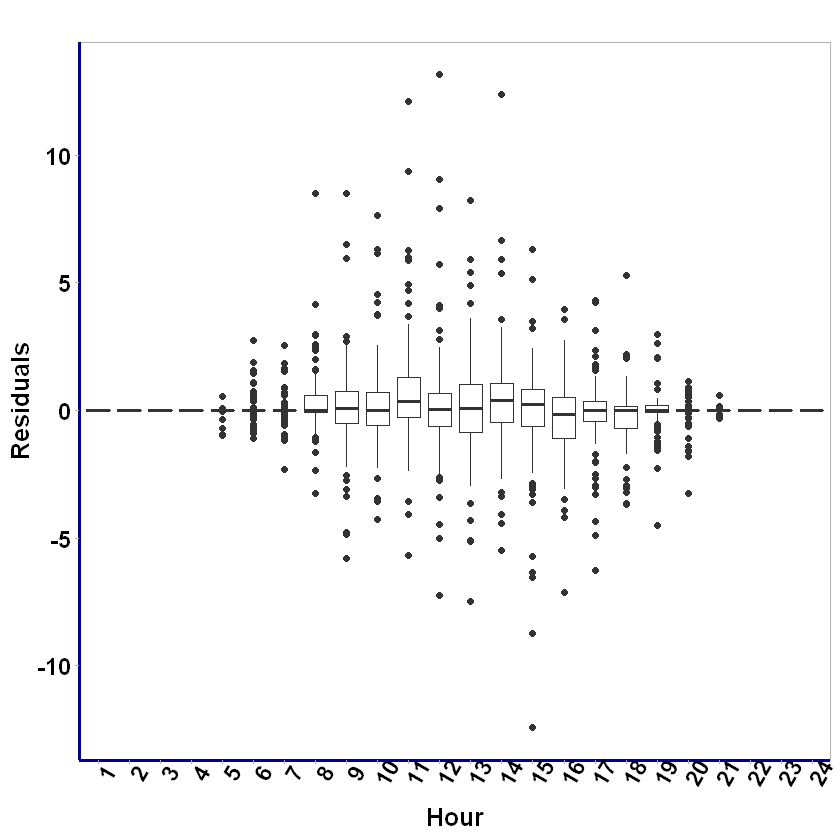

In [393]:
theme_set(theme_light())
Final_hplt <- results_FN %>% 
  select(c(h, PV , predictions)) %>% 

ggplot(mapping = aes(x = h, y = PV-predictions)) +
  geom_boxplot()+
  #, alpha = 0.9, show.legend = F) +
  #facet_wrap(~ h, scales = 'free') +
  ggtitle("") +
  xlab("Hour") +
  ylab("Residuals") +
  paletteer::scale_fill_paletteer_d("tvthemes::simpsons")+
  theme(
    panel.grid = element_blank(),
    axis.text.x = element_text(angle = 60))+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="black", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14, angle = 60),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))


list(Final_hplt)

setwd("C:/Users/Daud/Google Drive/Phd Saarland/Paper by Dd/Phd_Themes/Res.2-Genration modeling (S-01.12.17)/Analysis of weather parameters/T1_RE_P2_Analysis_of_Solar_radiations-Saarbrucken_jan2018_files/New/")
#ggsave("./Pre.png",Final_m_plt)
ggsave(filename = "HrRes.png", width=10, height=5)
#plt.plot



[[1]]


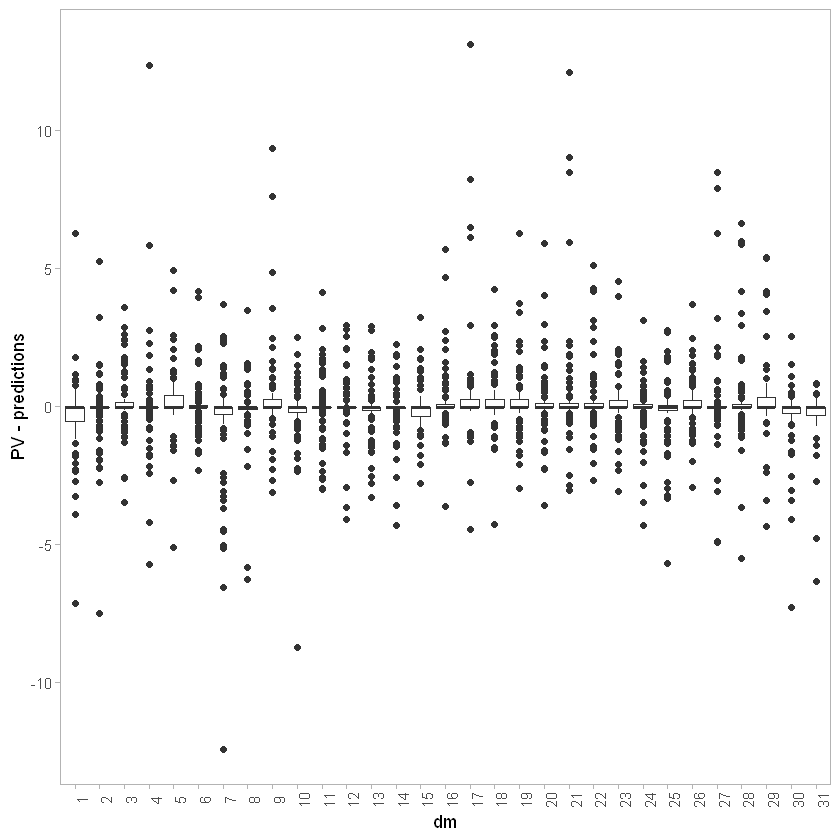

In [394]:
theme_set(theme_light())
Final_dmplt <- results_FN %>% 
  select(c(dm, PV , predictions)) %>% 

ggplot(mapping = aes(x = dm, y = PV-predictions)) +
  geom_boxplot()+
  #, alpha = 0.9, show.legend = F) +
  #facet_wrap(~ h, scales = 'free') +
  paletteer::scale_fill_paletteer_d("tvthemes::simpsons")+
  theme(
    panel.grid = element_blank(),
    axis.text.x = element_text(angle = 90))

 #ggplot(mapping = aes(x = PV, y = predictions)) +
 # geom_point(color = '#4D3161FF') +
 # # overlay regression line
 # geom_smooth(method = 'lm', color = 'black', se = F) +
 # ggtitle("Daily Bike Share Predictions") +
 # xlab("Actual Labels") +
 # ylab("Predicted Labels") +
 # theme(plot.title = element_text(hjust = 0.5))


list(Final_dmplt)

`geom_smooth()` using formula 'y ~ x'



[[1]]
# A tibble: 2 × 3
  .metric .estimator .estimate
  <chr>   <chr>          <dbl>
1 rmse    standard        1.34
2 rsq     standard        1.00

[[2]]


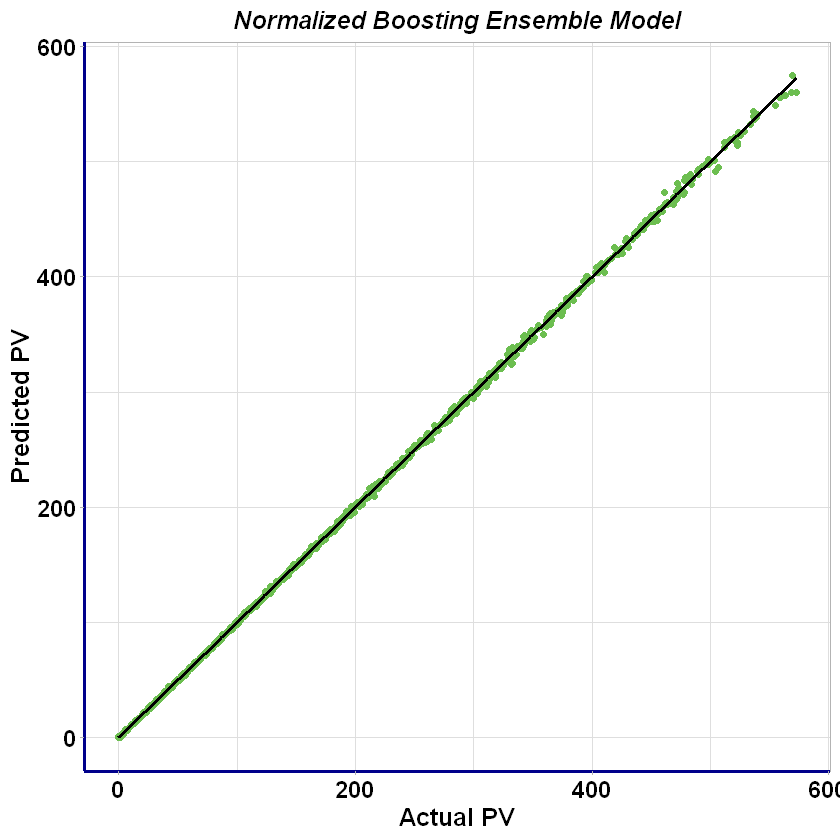

In [347]:
# For reproducibility
set.seed(2056)

# Evaluate the model
boost_metrics <- eval_metrics(data = results_FN,
                                  truth = PV,
                                  estimate = predictions) 

# Plot predicted vs actual
boost_plt <- results_FN %>% 
  ggplot(mapping = aes(x = PV, y = predictions)) +
  geom_point(color = '#6CBE50FF') +
  geom_smooth(method = 'lm', color = 'black', se = F) +
  # overlay regression line
  ggtitle("Normalized Boosting Ensemble Model") +
  xlab("Actual PV") +
  ylab("Predicted PV") +
  theme(plot.title = element_text(hjust = 0.5))+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="black", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14, angle = 0),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))

# Return evaluations
list(boost_metrics, boost_plt)

In [390]:
Final_plt_h <- results_FN %>% 
  select(c(h, PV , predictions)) %>% 
  group_by(h)%>%
  summarise(mean_pv = mean(PV),mean_pre = mean(predictions))
  

#ggplot(mapping = aes(x = h, y = PV)) +
#  geom_boxplot()+
  #, alpha = 0.9, show.legend = F) +
  #facet_wrap(~ h, scales = 'free') +
 # paletteer::scale_fill_paletteer_d("tvthemes::simpsons")+
 # theme(
 #   panel.grid = element_blank(),
 #   axis.text.x = element_text(angle = 90))

list(Final_plt_h)

h,mean_pv,mean_pre
<fct>,<dbl>,<dbl>
1,0.00000000,3.549768e-03
2,0.00000000,3.549768e-03
3,0.00000000,3.549768e-03
4,0.00000000,3.549768e-03
5,0.09401709,1.161111e-01
6,19.12000000,1.907306e+01
7,41.52678571,4.149812e+01
8,122.76842105,1.224694e+02
9,160.79207921,1.606757e+02


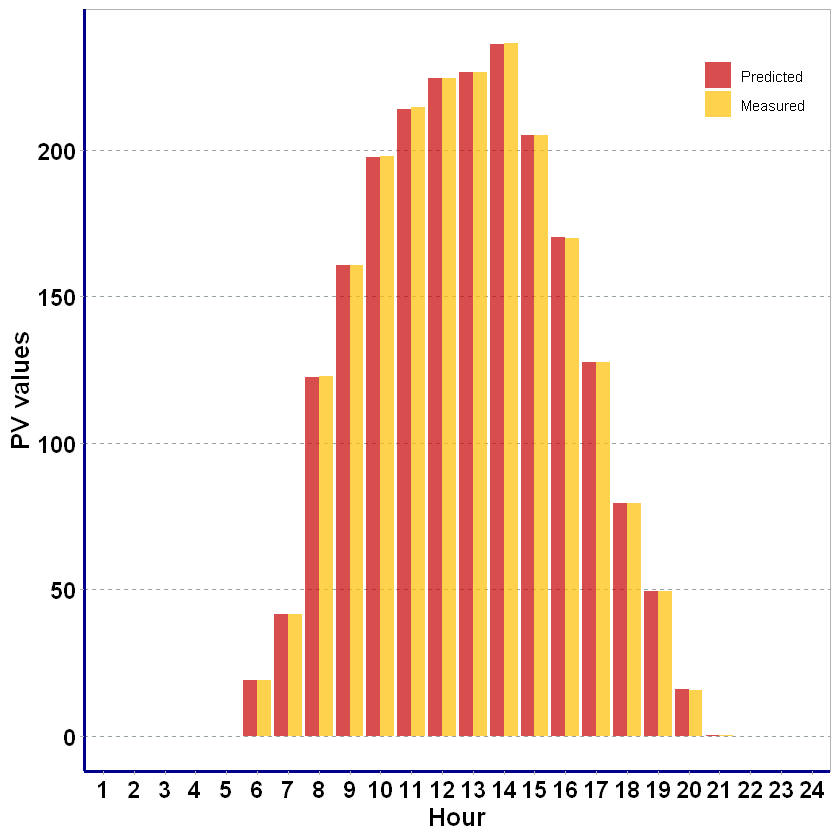

In [391]:
df_final <- Final_plt_h %>% 
  select(h, mean_pv, mean_pre) %>%
  #mutate(m = fct_reorder(m, .desc = TRUE)) %>% 
  pivot_longer(!h, names_to = "Metrics", values_to = "Values")

# Compare numeric variables with bar plots
ggplot(data = df_final) +
  geom_bar(mapping = aes(x = h, y = Values, fill = factor(Metrics,labels=c("Predicted","Measured"))), alpha = 0.7, stat = "identity", position = position_dodge(width = 0.9)) +
  xlab('Hour') +
  ylab('PV values') +
  scale_fill_paletteer_d("calecopal::kelp1") +
  theme(
    panel.grid = element_blank(),
    panel.grid.major.y = element_line(color = '#95a5a6',
                                      linetype = 'dashed',
                                      size = 0.5),
    axis.text.x = element_text(angle = 90),
    legend.title = element_blank()
    
  )+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="black", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14, angle = 0),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))

setwd("C:/Users/Daud/Google Drive/Phd Saarland/Paper by Dd/Phd_Themes/Res.2-Genration modeling (S-01.12.17)/Analysis of weather parameters/T1_RE_P2_Analysis_of_Solar_radiations-Saarbrucken_jan2018_files/New/")
#ggsave("./Pre.png",Final_m_plt)
ggsave(filename = "hpred.png", width=10, height=5)
#plt.plot


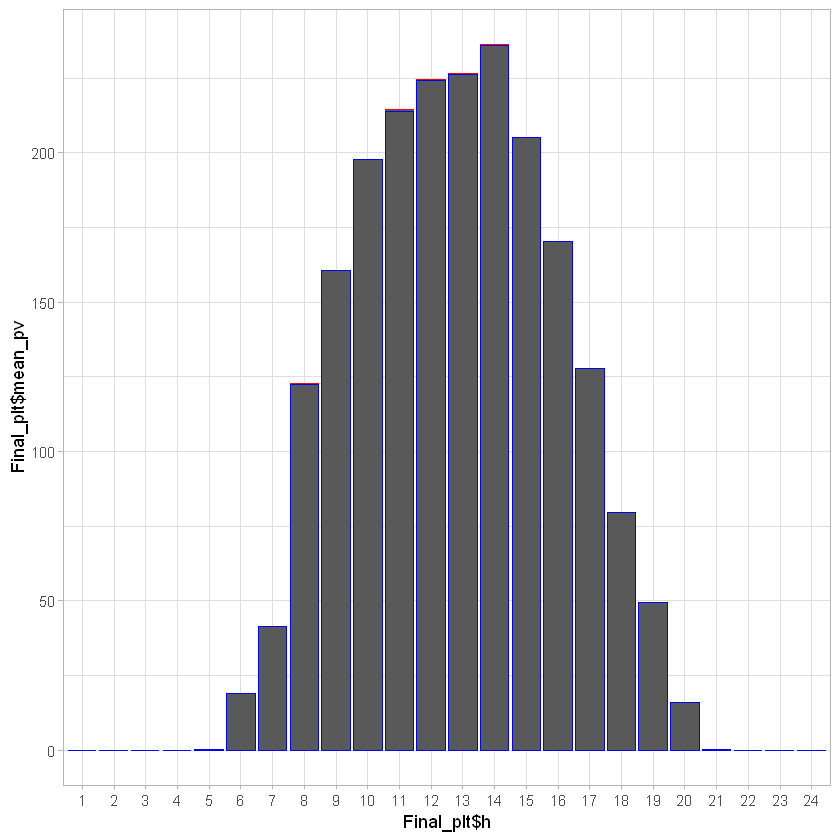

In [260]:
#theme_set(theme_light())
#r_int <- as.integer(Final_plt$mean_pre)
#df<-data.frame(Final_plt$h,Final_plt$mean_pre, Final_plt$mean_pv)
#g<-ggplot(df, aes(Final_plt$h, Final_plt$mean_pv))+ geom_bar(stat = "identity", colour="red")
#g<-g+geom_bar(data=df, aes(Final_plt$h, Final_plt$mean_pre), stat = "identity", colour="blue")
#print(g)

x,y
<fct>,<dbl>
1,3.549768e-03
2,3.549768e-03
3,3.549768e-03
4,3.549768e-03
5,1.161111e-01
6,1.907306e+01
7,4.149812e+01
8,1.224694e+02
9,1.606757e+02


Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.

Bin width defaults to 1/30 of the range of the data. Pick better value with `binwidth`.



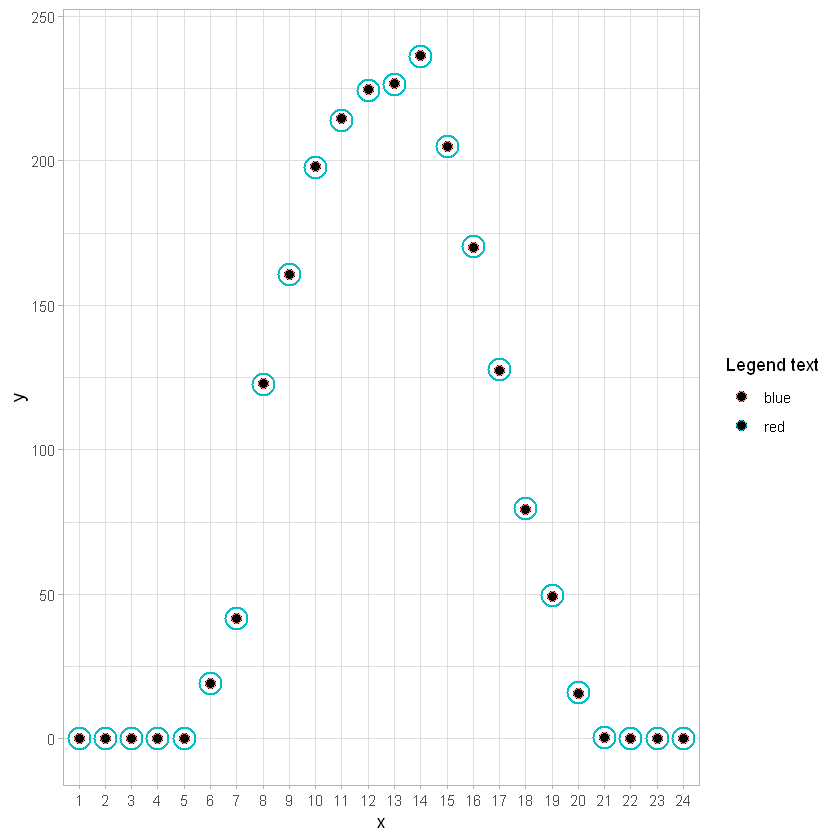

In [254]:
df1<-data.frame(x=Final_plt$h,y=Final_plt$mean_pre)
df2<-data.frame(x=Final_plt$h,y=Final_plt$mean_pv)
df1
ggplot(df1, aes(x,y))+geom_dotplot(aes(colour="red"),binaxis = "y", stackdir = "center", fill = "white", stroke = 2)+
  geom_dotplot(data = df2,aes(colour="blue"),binaxis = "y", stackdir = "center",dotsize = 0.5)+
  labs(color="Legend text")


#ggplot(data=Final_plt1,aes(x = h, y = mean_pre))+geom_line(aes(color="First line"))+
#  geom_line(data=Final_plt2,aes(color="Second line"))+
#  labs(color="Legend text")

m,mean_pv,mean_pre
<fct>,<dbl>,<dbl>
1,17.73967,17.66386
2,32.65728,32.58451
3,75.00000,74.74186
4,120.96154,120.68942
5,154.96279,154.96227
6,159.03587,159.05916
7,155.66376,155.64479
8,143.76682,143.93790
9,85.58515,85.49330


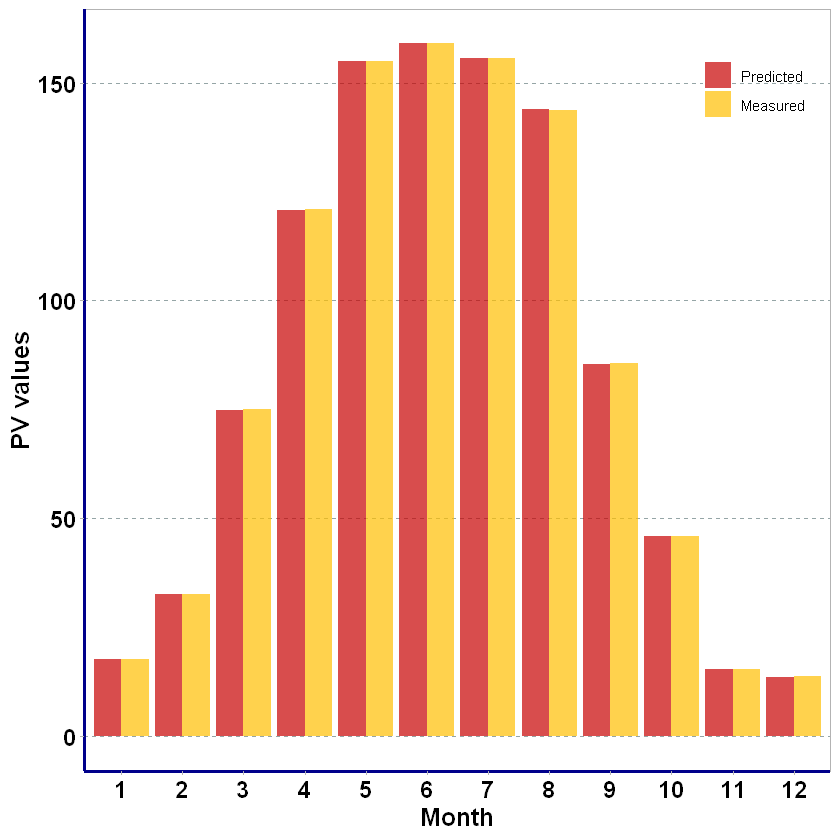

In [430]:
Final_m_plt <- results_FN %>% 
  select(c(m, PV , predictions)) %>% 
  group_by(m)%>%
  summarise(mean_pv = mean(PV),mean_pre = mean(predictions))
  
Final_m_plt

dff_final <- Final_m_plt %>% 
  select(m, mean_pv, mean_pre) %>%
  #mutate(m = fct_reorder(m, .desc = TRUE)) %>% 
  pivot_longer(!m, names_to = "Metrics", values_to = "Values")

# Compare numeric variables with bar plots
ggplot(data = dff_final) +
  geom_bar(mapping = aes(x = m, y = Values, fill = factor(Metrics,labels=c("Predicted","Measured"))), alpha = 0.7, stat = "identity", position = position_dodge(width = 0.9)) +
  xlab('Month') +
  ylab('PV values') +
  scale_fill_paletteer_d("calecopal::kelp1") +
  theme(
    panel.grid = element_blank(),
    panel.grid.major.y = element_line(color = '#95a5a6',
                                      linetype = 'dashed',
                                      size = 0.5),
    axis.text.x = element_text(angle = 90),
    legend.title = element_blank()
    
  )+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="black", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14, angle = 0),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))

setwd("C:/Users/Daud/Google Drive/Phd Saarland/Paper by Dd/Phd_Themes/Res.2-Genration modeling (S-01.12.17)/Analysis of weather parameters/T1_RE_P2_Analysis_of_Solar_radiations-Saarbrucken_jan2018_files/New/")
#ggsave("./Pre.png",Final_m_plt)
ggsave(filename = "mpred.png", width=10, height=5)
#plt.plot

ERROR: Error in results_FN %>% df1 <- data.frame(x = results_FN$m, y = results_FN$predictions): could not find function "%>%<-"
